# A Meal's True Cost

## Introduction
The primary objective of this Exploratory Data Analysis (EDA) is to assess the environmental impact associated with individual food products and, by extension, the composition of entire meals. By shedding light on these impacts, the project aims to inform users and encourage more sustainable dietary choices that contribute to the health of the planet.

The narrative structure of the analysis is organized into three principal sections. The first adopts a global perspective, examining the environmental effects of food production in terms of water withdrawal, greenhouse gas emissions, and land use. These are contextualized by comparing them to impacts generated by other economic sectors.

The second section narrows the focus to the national context of Italy. Here, we investigate consumption patterns and evaluate the environmental footprint of the most frequently consumed food products. This includes analyzing water use and greenhouse gas emissions associated with these items. Furthermore, we propose alternative products with lower environmental costs and compare them to their more impactful counterparts. An additional analysis explores the potential correlation between the price of food products and their environmental burden. Preliminary results suggest a positive relationship, although more comprehensive data is necessary to confirm this trend.

The final section features an interactive component that allows users to construct a virtual meal. The cumulative environmental impact—measured in water usage, greenhouse gas emissions, and economic cost—is then displayed. This interactive tool is designed to reinforce the findings from the previous sections and serve as a call to action, empowering users to apply their knowledge in real-world decision-making.

This notebook is structured into two major parts. The first contains all the code related to procedures for data collection, cleaning, and selection. It also details the methodology used to integrate heterogeneous datasets via AGROVOC, a multilingual, Linked Open Data controlled vocabulary maintained by the Food and Agriculture Organization (FAO). AGROVOC enabled the harmonization of food labels across datasets, and URIs for the matched concepts are also provided.

The second part is devoted to data visualization. It includes both the graphical representations and the accompanying narrative text, which together convey the insights derived from the analysis.

In [ ]:
from fuzzywuzzy import process, fuzz
import re
import matplotlib.pyplot as plt
import numpy as np
from rapidfuzz import fuzz
import os
import json
import string
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON
from sentence_transformers import SentenceTransformer, util
import requests
from bs4 import BeautifulSoup
from io import StringIO

## Getting and parsing the data

### Data sources

The initial phase of the analysis involves parsing and examining the relevant datasets. The data sources are organized according to the two major components of the project: the global environmental impact assessment and the country-specific analysis of Italian food consumption.

For the global section, the following datasets were utilized:

- FAO AQUASTAT: provides comprehensive information on worldwide water withdrawal, with a focus on the agricultural sector.

- FAOSTAT – Land Use: offers data related to land utilization across various economic sectors, including agriculture and forestry.

- FAOSTAT – Greenhouse Gas Emissions: includes estimates of GHG emissions attributed to agricultural and food-related activities, allowing for comparisons across regions and timeframes.

For the second section, which focuses on Italy, and for the interactive game presented at the end of the project, the following datasets were employed:

- EFSA (European Food Safety Authority) Comprehensive Food Consumption Database: contains harmonized data on dietary intake across European countries, including disaggregated information for individual food products consumed in Italy.

- suEATable Dataset: provides detailed environmental impact data—specifically carbon footprint and water footprint values—for a wide range of food items.

- Osservatorio Prezzi e Tariffe – Ministero delle Imprese e del Made in Italy: web-scraped data on retail food prices in Italy, used to complement environmental data with economic information.

These datasets form the foundation for the analytical workflows and visual storytelling developed in the subsequent sections.

#### Why AGROVOC Integration?

The integration of AGROVOC into this analysis was a crucial step in harmonizing labels across multiple datasets, each characterized by differing naming conventions and terminologies for food items. AGROVOC, maintained by the Food and Agriculture Organization (FAO), is a multilingual controlled vocabulary that offers standardized labels and unique identifiers for agricultural and food-related concepts. By leveraging AGROVOC, we ensured consistency and semantic interoperability between datasets, thereby enabling accurate comparisons and meaningful aggregations.

Beyond its role in integrating food item datasets, AGROVOC was also utilized to assign preferred labels and corresponding URIs to various domain-specific entities such as emission sectors and land use categories, further enhancing the semantic robustness of the analysis.

#### Main functions to integrate AGROVOC

* **SPARQLWrapper**: Used to connect and query the AGROVOC SPARQL endpoint (`http://agrovoc.fao.org/sparql`).
* **SentenceTransformer**: An 'all-MiniLM-L6-v2' model is initialized to perform semantic similarity calculations. This is crucial for finding the best match from AGROVOC candidates when a direct exact match is not found.
* **Caching Mechanism**: Functions `load_cache()`and `save_cache()` are defined to store and retrieve AGROVOC query results. This prevents redundant queries to the external endpoint, improving efficiency.`clean_cache()` is designed to clear the cache from empty entries (in the case the SPARQL query did not return anything) by creating a `cleaned_cache` dictionary, including only entries where the `value` dictionary contains a "label" key with a non-`None` value. 

In [2]:
# Initialize SPARQL endpoint and model
sparql = SPARQLWrapper("http://agrovoc.fao.org/sparql")
model = SentenceTransformer('all-MiniLM-L6-v2')

CACHE_PATH = "agro_cache.json"

In [3]:
def load_cache():
    if not os.path.exists(CACHE_PATH):
        return {}
    with open(CACHE_PATH, "r", encoding="utf-8") as f:
        cache = json.load(f)
        return cache

def save_cache(cache):
    with open(CACHE_PATH, "w", encoding="utf-8") as f:
        json.dump(cache, f, indent=2)

def clean_cache():
    if not os.path.exists(CACHE_PATH):
        return
    with open(CACHE_PATH, "r", encoding="utf-8") as f:
        cache = json.load(f)

    cleaned_cache = {
        key: value
        for key, value in cache.items()
        if value.get("label") is not None
    }

    with open(CACHE_PATH, "w", encoding="utf-8") as f:
        json.dump(cleaned_cache, f, indent=2)

* **`semantic_best_match(value, candidates)`**: This function takes an input `value` and a list of `candidates` (from AGROVOC). It encodes both the input and candidates into embeddings and then uses cosine similarity to find the candidate that is semantically closest to the input.

In [4]:
def semantic_best_match(value, candidates):
    input_embedding = model.encode(value, convert_to_tensor=True)
    candidate_texts = []
    for c in candidates:
        candidate_texts.append(c["label"])
    candidate_embeddings = model.encode(candidate_texts, convert_to_tensor=True)
    scores = util.cos_sim(input_embedding, candidate_embeddings)[0]
    best_idx = scores.argmax().item()
    return candidates[best_idx]

* **`query_agrovoc(value, cache)`**: This function first checks if the `value` or its alternative labels are present in the local `cache`. If not, it constructs a SPARQL query to search for the `value` in AGROVOC's `skos:prefLabel` and `skos:altLabel` (alternative labels). The results are then passed to `semantic_best_match` to identify the most relevant concept, which is then stored in the cache for future use.

In [5]:
def query_agrovoc(value, cache):

    norm_value = value.lower().replace(",", "")

    if norm_value in cache:
        print(f"Cache hit: '{value}' found in cache")
        return cache[norm_value]
    
    for entry in cache.values():
        if "altLabels" in entry and value in entry["altLabels"]:
            print(f"Cache hit: '{value}' found in cache")
            return entry
    
    
    print(f"Cache miss: '{value}' not in cache, querying AGROVOC endpoint")
    # Run SPARQL query
    query = f"""
        PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

        SELECT ?concept ?label (GROUP_CONCAT(?altLabel; separator=" | ") AS ?altLabels) WHERE {{
        ?concept skos:prefLabel ?label .
        OPTIONAL {{
            ?concept skos:altLabel ?altLabel .
            FILTER(LANG(?altLabel) = "en")
        }}

        FILTER(LANG(?label) = "en")

        FILTER(
            CONTAINS(LCASE(?label), "{norm_value}") ||
            (BOUND(?altLabel) && CONTAINS(LCASE(?altLabel), "{norm_value}"))
        )
        }}
        GROUP BY ?concept ?label

    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    candidates = []
    for result in results["results"]["bindings"]:
        label = result["label"]["value"]
        uri = result["concept"]["value"]
        altlabels_str = result["altLabels"]["value"] if "altLabels" in result else ""
        altlabels = [al.strip().lower() for al in altlabels_str.split("|") if al.strip()]
        candidate = {"label": label, "uri": uri, "altLabels": altlabels}
        candidates.append(candidate)
        
    if not candidates:
        match = {"label": None, "uri": None, "altLabels": []}
    else:
        best = semantic_best_match(value, candidates)
        match = best
    # Cache the result
    cache[norm_value] = match
    save_cache(cache)
    return match

* **`enrich_with_agrovoc(df, column_name)`**: This function iterates through a specified `column_name` in a DataFrame, queries AGROVOC for each value, and adds two new columns to the DataFrame: `AGROVOC_label` (the preferred label from AGROVOC) and `AGROVOC_uri` (the URI of the AGROVOC concept).

In [6]:
def enrich_with_agrovoc(df, column_name):
    cache = load_cache()
    labels = []
    uris = []
    for val in df[column_name]:
        match = query_agrovoc(val, cache)
        labels.append(match["label"])
        uris.append(match["uri"])
    df["AGROVOC_label"] = labels
    df["AGROVOC_uri"] = uris
    return df

### Parsing, cleaning and selecting the data for the first section

In this section, the datasets are parsed and processed using the Python programming language. After loading the raw data into structured dataframes, a selection phase is carried out to isolate only the relevant variables needed for the subsequent analyses and visualizations. This involves filtering rows based on specific conditions (e.g., geographic scope, sector, or category) and selecting appropriate columns for each research question.

The selected data, comprising both labels (e.g., food item names or sector types) and corresponding values (e.g., consumption quantities, water usage, or greenhouse gas emissions), are then stored in lists. These structures are optimized for use in later stages of the notebook, particularly for generating visualizations that support the narrative flow.

In [7]:
# Load the data on worldwide water withdrawals
world_water_data = pd.read_csv("data/aquastat_world_water_data.csv", encoding="utf-8")

# loading dataset on land use
landuse_data = pd.read_csv("data/FAOSTAT_land_use_data.csv", encoding="utf-8")

# Load the data on greenhouse gas emissions
fao_greenhouse_gas_emissions = pd.read_csv("data/FAOSTAT_emissions_total.csv", encoding="utf-8")

#### World water withdrawal data

In [8]:
# Parsing and cleaning world water data
# Define the variables of interest
variables_of_interest_www = [
    "Agricultural water withdrawal",
    "Industrial water withdrawal",
    "Municipal water withdrawal"
]

# Filter the dataframe
definitive_df_www = world_water_data[
    (world_water_data["Variable"].isin(variables_of_interest_www)) &
    (world_water_data["Year"] == 2022) &
    (world_water_data["Area"] == "World")
]

# Check the data types
print(definitive_df_www.dtypes)

# Extract variables for visualization
selected_variables_www = definitive_df_www["Variable"].tolist()
selected_values_www = definitive_df_www["Value"].tolist()
unit_of_measurement_www = world_water_data[(world_water_data["Variable"] == "Agricultural water withdrawal")]["Unit"].values[0]

VariableGroup     object
Subgroup          object
Variable          object
Area              object
Year               int64
Value            float64
Unit              object
Symbol            object
IsAggregate         bool
dtype: object


#### Land use data

In [9]:
# Checking the unique land use items
landuse_data_item_list = landuse_data["Item"].unique()
print("Unique Land Use Items:", landuse_data_item_list)

Unique Land Use Items: ['Country area' 'Land area' 'Agriculture' 'Agricultural land' 'Cropland'
 'Arable land' 'Temporary crops' 'Temporary meadows and pastures'
 'Temporary fallow' 'Permanent crops' 'Permanent meadows and pastures'
 'Forest land' 'Naturally regenerating forest' 'Planted Forest'
 'Other land' 'Inland waters' 'Land area equipped for irrigation'
 'Agriculture area under organic agric.' 'Primary Forest']


In [10]:
# Filter the land use data
filtered_landuse = landuse_data[
    (landuse_data["Area"] == "World") &
    (landuse_data["Year"] == 2018) &
    (landuse_data["Element"] == "Area") &
    (landuse_data["Item"].isin(["Country land",
                                "Land area", 
                                "Agriculture", 
                                "Forest land", 
                                "Land used for aquaculture", 
                                "Inland waters used for aquac. or holding facilities", 
                                "Inland waters used for capture fishes", 
                                "Coastal waters used for aquac. or holding facilities",
                                "Coastal waters used for capture fishes",
                                "EEZ used for aquac. or holding facilities",
                                "EEZ used for capture fishes"]))
]

# check for data types
print(filtered_landuse.dtypes)

# Keep only relevant columns
filtered_landuse = filtered_landuse[["Area", "Year", "Item", "Value"]]
filtered_landuse

Domain Code          object
Domain               object
Area Code (M49)       int64
Area                 object
Element Code          int64
Element              object
Item Code             int64
Item                 object
Year Code             int64
Year                  int64
Unit                 object
Value               float64
Flag                 object
Flag Description     object
Note                float64
dtype: object


,Area,Year,Item,Value
44,World,2018,Land area,1.303152e+07
69,World,2018,Agriculture,4.841329e+06
532,World,2018,Forest land,4.068924e+06


In [11]:
# Select values for land area, agriculture, forest land
land_area = filtered_landuse[(filtered_landuse["Item"] == "Land area")]["Value"].iloc[0]
agriculture_area = filtered_landuse[(filtered_landuse["Item"] == "Agriculture")]["Value"].iloc[0]
forest_land_area = filtered_landuse[(filtered_landuse["Item"] == "Forest land")]["Value"].iloc[0]

# Calculate the area of "other land use", that is the total land area (excluding inland and coastal waters) minus the areas of agriculture and forest land
# The other land use area includes areas not used for agriculture or forest, such as urban areas, deserts, etc.
other_land_area = land_area - (agriculture_area + forest_land_area)

In [12]:
# Create a perzonalized DataFrame to include the calculated "other land use" area
# This DataFrame will contain the areas of agriculture, forest land, and other land use
land_use_areas = pd.DataFrame({
    "Item": ["Agriculture", "Forest land", "Other land use"],
    "Value": [agriculture_area, forest_land_area, other_land_area]
})

# Convert the DataFrame to lists for visualization
land_use_items = land_use_areas["Item"].tolist()
land_use_values = land_use_areas["Value"].tolist()

#### Greenhouse gas emissions data

For this specific dataset, an additional preprocessing step is required. Given that a stacked bar chart will be employed for visualization, it is essential to limit the number of agrifood categories in order to maintain clarity and readability. To achieve this, a mapping scheme is defined to aggregate granular categories into broader, semantically coherent groups. This aggregation facilitates a more effective visual representation, ensuring that the complexity of the data does not compromise the interpretability of the chart.

In [13]:
# Checking the unique items in the FAOSTAT greenhouse gas emissions dataset
fao_greenhouse_gas_emissions["Item"].unique()

array(['Crop Residues', 'Rice Cultivation', 'Burning - Crop residues',
       'Enteric Fermentation', 'Manure Management',
       'Manure left on Pasture', 'Manure applied to Soils',
       'Synthetic Fertilizers', 'Drained organic soils',
       'Drained organic soils (CO2)', 'Drained organic soils (N2O)',
       'On-farm energy use', 'Forestland', 'Net Forest conversion',
       'Savanna fires', 'Fires in organic soils', 'Forest fires',
       'Fires in humid tropical forests',
       'Agrifood Systems Waste Disposal', 'Fertilizers Manufacturing',
       'Pesticides Manufacturing', 'Food Processing', 'Food Packaging',
       'Food Retail', 'Food Household Consumption', 'Food Transport',
       'Energy', 'IPPU', 'Waste', 'International bunkers', 'Other'],
      dtype=object)

In [14]:
# Define the aggregation map for greenhouse gas emissions to reduce the number of categories
# This map will group similar items into broader categories for better visualization and analysis
aggregation_map = {
    # Crop Production
    'Crop Residues': 'Crop Production',
    'Rice Cultivation': 'Crop Production',
    'Burning - Crop residues': 'Crop Production',
    'Synthetic Fertilizers': 'Crop Production',
    'Drained organic soils': 'Crop Production',
    'Drained organic soils (CO2)': 'Crop Production',
    'Drained organic soils (N2O)': 'Crop Production',
    'Manure applied to Soils': 'Crop Production',

    # Livestock Production
    'Enteric Fermentation': 'Livestock Production',
    'Manure Management': 'Livestock Production',
    'Manure left on Pasture': 'Livestock Production',

    # Land-Use Change
    'Forestland': 'Land-Use Change',
    'Net Forest conversion': 'Land-Use Change',
    'Savanna fires': 'Land-Use Change',
    'Fires in organic soils': 'Land-Use Change',
    'Forest fires': 'Land-Use Change',
    'Fires in humid tropical forests': 'Land-Use Change',

    # On-Farm Energy
    'On-farm energy use': 'On-Farm Energy',

    # Agricultural Inputs
    'Fertilizers Manufacturing': 'Ag. Inputs Manufacturing',
    'Pesticides Manufacturing': 'Ag. Inputs Manufacturing',

    # Processing & Packaging
    'Food Processing': 'Processing & Packaging',
    'Food Packaging': 'Processing & Packaging',

    # Transport & Retail
    'Food Transport': 'Transport & Retail',
    'Food Retail': 'Transport & Retail',

    # Consumption
    'Food Household Consumption': 'Consumption',

    # Waste
    'Agrifood Systems Waste Disposal': 'Waste',

    # Exclude or label as "Other" if unrelated
    'Energy': 'Other',
    'IPPU': 'Other',
    'Waste': 'Other',
    'International bunkers': 'Other',
    'Other': 'Other'
}

# Map the 'Item' column to the new 'Category' using the aggregation map
fao_greenhouse_gas_emissions['Category'] = fao_greenhouse_gas_emissions['Item'].map(aggregation_map)

# Check data types
print(fao_greenhouse_gas_emissions.dtypes)

fao_greenhouse_gas_emissions

Domain Code          object
Domain               object
Area Code (M49)       int64
Area                 object
Element Code          int64
Element              object
Item Code             int64
Item                 object
Year Code             int64
Year                  int64
Source Code           int64
Source               object
Unit                 object
Value               float64
Flag                 object
Flag Description     object
Note                float64
Category             object
dtype: object


,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code,Item,Year Code,Year,Source Code,Source,Unit,Value,Flag,Flag Description,Note,Category
0,GT,Emissions totals,1,World,7234,Direct emissions (N2O),5064,Crop Residues,1999,1999,3050,FAO TIER 1,kt,425.3989,E,Estimated value,NaN,Crop Production
1,GT,Emissions totals,1,World,7236,Indirect emissions (N2O),5064,Crop Residues,1999,1999,3050,FAO TIER 1,kt,95.7152,E,Estimated value,NaN,Crop Production
2,GT,Emissions totals,1,World,7230,Emissions (N2O),5064,Crop Residues,1999,1999,3050,FAO TIER 1,kt,521.1148,E,Estimated value,NaN,Crop Production
3,GT,Emissions totals,1,World,724313,Emissions (CO2eq) from N2O (AR5),5064,Crop Residues,1999,1999,3050,FAO TIER 1,kt,138095.4220,E,Estimated value,NaN,Crop Production
4,GT,Emissions totals,1,World,723113,Emissions (CO2eq) (AR5),5064,Crop Residues,1999,1999,3050,FAO TIER 1,kt,138095.4220,E,Estimated value,NaN,Crop Production
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619,GT,Emissions totals,1,World,7230,Emissions (N2O),6819,Other,2022,2022,3050,FAO TIER 1,kt,601.7354,E,Estimated value,NaN,Other
3620,GT,Emissions totals,1,World,7273,Emissions (CO2),6819,Other,2022,2022,3050,FAO TIER 1,kt,47500.3188,E,Estimated value,NaN,Other
3621,GT,Emissions totals,1,World,724413,Emissions (CO2eq) from CH4 (AR5),6819,Other,2022,2022,3050,FAO TIER 1,kt,4218.9272,E,Estimated value,NaN,Other
3622,GT,Emissions totals,1,World,724313,Emissions (CO2eq) from N2O (AR5),6819,Other,2022,2022,3050,FAO TIER 1,kt,159459.8941,E,Estimated value,NaN,Other


In [15]:
# Select rows for emissions related to the agrifood system
agriculture_sectors_emissions = fao_greenhouse_gas_emissions[(fao_greenhouse_gas_emissions["Category"] != "Other") & 
                                                             (fao_greenhouse_gas_emissions["Area"] == "World") &
                                                                (fao_greenhouse_gas_emissions["Year"] == 2022) &
                                                             (fao_greenhouse_gas_emissions["Element"] == "Emissions (CO2eq) (AR5)")]

# Define and removing the useless drained organic soil items
# These items are not relevant because they are already included in the general "drained organic soils" item
useless_drained_organic_soil = [
    "Drained organic soils (CO2)", "Drained organic soils (N2O)"
]

# Remove rows with "Dried organic soils (CO2)" and "Dried organic soils (N2O)"
agriculture_sectors_emissions = agriculture_sectors_emissions[~agriculture_sectors_emissions["Item"].isin(useless_drained_organic_soil)]

In [16]:
# Group by Category and sum the values
agriculture_sectors_emissions = agriculture_sectors_emissions.groupby("Category").agg({
    "Domain": "first",  # Keep the first value (assuming all rows have the same value)
    "Area": "first",   # Keep the first value (assuming all rows have the same value)
    "Element": "first",  # Keep the first value (assuming all rows have the same value)
    "Year": "first",  # Keep the first value (assuming all rows have the same value)
    "Unit": "first",  # Keep the first value (assuming all rows have the same value)
    "Value": "sum",  # Sum the values
    "Flag Description": "first"  # Keep the first value (assuming all rows have the same value)
}).reset_index()

In [17]:
# Rename category column as "Item"
agriculture_sectors_emissions.rename(columns={"Category": "Item"}, inplace=True)

# Add a new column category column filled with "Agrifood System" (useful for visualization)
agriculture_sectors_emissions["Category"] = "Agrifood System"

In [18]:
agriculture_sectors_emissions # Pietro usa questo

,Item,Domain,Area,Element,Year,Unit,Value,Flag Description,Category
0,Ag. Inputs Manufacturing,Emissions totals,World,Emissions (CO2eq) (AR5),2022,kt,5.550382e+05,Estimated value,Agrifood System
1,Consumption,Emissions totals,World,Emissions (CO2eq) (AR5),2022,kt,1.204485e+06,Estimated value,Agrifood System
2,Crop Production,Emissions totals,World,Emissions (CO2eq) (AR5),2022,kt,2.598559e+06,Estimated value,Agrifood System
3,Land-Use Change,Emissions totals,World,Emissions (CO2eq) (AR5),2022,kt,7.976751e+05,Estimated value,Agrifood System
4,Livestock Production,Emissions totals,World,Emissions (CO2eq) (AR5),2022,kt,4.095916e+06,Estimated value,Agrifood System
5,On-Farm Energy,Emissions totals,World,Emissions (CO2eq) (AR5),2022,kt,9.284939e+05,Estimated value,Agrifood System
6,Processing & Packaging,Emissions totals,World,Emissions (CO2eq) (AR5),2022,kt,9.753780e+05,Estimated value,Agrifood System
7,Transport & Retail,Emissions totals,World,Emissions (CO2eq) (AR5),2022,kt,1.317908e+06,Estimated value,Agrifood System
8,Waste,Emissions totals,World,Emissions (CO2eq) (AR5),2022,kt,1.281260e+06,Estimated value,Agrifood System


In [19]:
# Extracting the values and items for visualization
agriculture_sectors_emissions_values = agriculture_sectors_emissions["Value"].tolist()
agriculture_sectors_emissions_items = agriculture_sectors_emissions["Item"].tolist()

In [20]:
# Filter for emissions related to other sectors
# These are emissions not directly related to the agrifood system, such as energy, IPPU, waste, and international bunkers
Other_sectors_emissions = fao_greenhouse_gas_emissions[(fao_greenhouse_gas_emissions["Category"] == "Other") &
                                                        (fao_greenhouse_gas_emissions["Area"] == "World") &
                                                        (fao_greenhouse_gas_emissions["Year"] == 2022) &
                                                        (fao_greenhouse_gas_emissions["Element"] == "Emissions (CO2eq) (AR5)")]

# Remove columns that are not needed
Other_sectors_emissions = Other_sectors_emissions[["Item", "Domain", "Area", "Element", "Year", "Unit", "Value", "Flag Description", "Category"]]

Other_sectors_emissions # Pietro usa questo

,Item,Domain,Area,Element,Year,Unit,Value,Flag Description,Category
3023,Energy,Emissions totals,World,Emissions (CO2eq) (AR5),2022,kt,3.884379e+07,Estimated value,Other
3191,IPPU,Emissions totals,World,Emissions (CO2eq) (AR5),2022,kt,4.500829e+06,Estimated value,Other
3335,Waste,Emissions totals,World,Emissions (CO2eq) (AR5),2022,kt,2.577948e+06,Estimated value,Other
3479,International bunkers,Emissions totals,World,Emissions (CO2eq) (AR5),2022,kt,1.175800e+06,Estimated value,Other
3623,Other,Emissions totals,World,Emissions (CO2eq) (AR5),2022,kt,2.111791e+05,Estimated value,Other


In [21]:
# Extracting the values and items for visualization
other_sectors_emissions_values = Other_sectors_emissions["Value"].tolist()
other_sectors_emissions_items = Other_sectors_emissions["Item"].tolist()


In [22]:
# Combine the two DataFrames into one to create a csv

### Parsing, cleaning and selecting the data for the second section and the interactive game at the end
#### Prices data
To obtain data on food item prices, a web scraping procedure was implemented. Although the Osservatorio Prezzi e Tariffe, maintained by the Ministero delle Imprese e del Made in Italy, provides price information in tabular form, the platform does not offer any functionality for downloading the data in structured formats. Therefore, it was necessary to programmatically retrieve the data.

Using Python libraries such as requests, BeautifulSoup, and pandas, we automated the extraction process: relevant HTML pages were accessed, parsed, and filtered to isolate and convert the desired tables into dataframes suitable for further analysis. This step was crucial for enriching the dataset with up-to-date price information, which was later aligned with the corresponding food items used in environmental impact assessments.

In [23]:
# Getting the html page
import requests

URL_base = "https://osservaprezzi.mise.gov.it/prezzi/livelli/beni-e-servizi-di-largo-consumo/archivio-rilevazioni-beni-e-servizi-di-largo-consumo?ANNO=2025&MESE=5&f%5BPROVINCIA%5D=Bologna&f%5BTIPO_RECORD_MISE%5D="
URL_alimenti = "altri_alim&submit=Applica"
URL_ortofrutta = "orto&submit=Applica"
URL_ittici = "ittici&submit=Applica"
page_alimenti = requests.get(URL_base+URL_alimenti)
page_ortofrutta = requests.get(URL_base+URL_ortofrutta)
page_ittici = requests.get(URL_base+URL_ittici)

print(page_alimenti.text)

<!DOCTYPE html>
<!--[if IE 8]><html class="no-js ie89 ie8" lang="it-it"><![endif]-->
<!--[if IE 9]><html class="no-js ie89 ie9" lang="it-it"><![endif]-->
<!--[if (gte IE 9)|!(IE)]><!-->
<html class="no-js theme-italia" lang="it-it" dir="ltr">
<!--<![endif]-->
<head>
	<meta charset="utf-8" />
	<meta http-equiv="x-ua-compatible" content="ie=edge">
	<meta name="viewport" content="width=device-width, initial-scale=1">

		<!--[if lt IE 9]><script src="/media/jui/js/html5.js"></script><![endif]-->
	<!-- include html5shim per Explorer 8 -->
	<script src="https://osservaprezzi.mise.gov.it/templates/italiapa/build/vendor/modernizr.js"></script>

	<script>__PUBLIC_PATH__ = 'https://osservaprezzi.mise.gov.it/templates/italiapa/build/'</script>
	<script>__DEFAULT_THEME__ = 'italia'</script>

	<link href='//fonts.googleapis.com/css?family=Titillium+Web:400,400italic,700,' rel='stylesheet' type='text/css' />
	<link href="https://fonts.googleapis.com/icon?family=Material+Icons" rel="stylesheet">

	<b

In [24]:
# parsing the page with BeautifulSoup
soup_al = BeautifulSoup(page_alimenti.content, "html.parser")
soup_ort = BeautifulSoup(page_ortofrutta.content, "html.parser")
soup_itt = BeautifulSoup(page_ittici.content, "html.parser")

In [25]:
# finding the table with id "id-table-results"
results_alimenti = soup_al.find(id="id-table-results")
results_orto = soup_ort.find(id="id-table-results")
results_ittici = soup_itt.find(id="id-table-results")

In [26]:
# Transform the table into a pandas dataframe
df_prices_alimenti = pd.read_html(StringIO(str(results_alimenti)))[0]
df_prices_orto = pd.read_html(StringIO(str(results_orto)))[0]
df_prices_ittici = pd.read_html(StringIO(str(results_ittici)))[0]

prices_data = pd.concat([df_prices_alimenti, df_prices_orto], ignore_index=True)
prices_data = pd.concat([prices_data, df_prices_ittici], ignore_index=True)

In [27]:
prices_data

,Descrizione Prodotto,Quotazione Minima,Quotazione Massima,Quotazione Media,Tipologia di Prodotto
0,Riso (1000 Gr),1.91,5.45,3.10,Alimentari
1,Farina Di Frumento (1000 Gr),0.48,2.13,0.95,Alimentari
2,Pane Fresco Con Farina Di Grano (1000 Gr),3.99,7.80,5.23,Alimentari
3,Pane A Fette (300 Gr),0.61,1.61,0.86,Alimentari
4,Biscotti (1000 Gr),2.68,7.65,4.24,Alimentari
...,...,...,...,...,...
77,Merluzzi O Naselli Freschi Di Pescata (1000 Gr),15.00,22.00,19.69,Ittici
78,Trote Di Allevamento Fresche (1000 Gr),8.90,11.91,10.06,Ittici
79,Salmone Fresco (1000 Gr),14.90,23.00,18.30,Ittici
80,Mitili O Cozze Fresche (1000 Gr),3.90,6.90,5.18,Ittici


#### General considerations on the integration process

To ensure a consistent and semantically coherent dataset, a structured methodology was adopted for integrating heterogeneous data sources. The EFSA dataset on Italian food consumption habits was selected as the foundational dataset, given its central role in the analysis of food-related behaviors within Italy.

The integration process began by aligning the EFSA dataset with AGROVOC, the multilingual controlled vocabulary developed by the Food and Agriculture Organization (FAO). After identifying and retrieving the preferred labels from AGROVOC, these were used as the reference for matching entries across the other datasets.

The first merging step involved aligning the AGROVOC-enhanced EFSA data with the carbon footprint dataset (from the suEATable LIFE project). Matching was performed using semantic similarity methods, and results were manually reviewed to correct misalignments and ensure the integrity of the data. A similar procedure was applied to incorporate the water footprint dataset, also from suEATable LIFE, followed by additional manual verification.

Subsequently, the enriched dataset was merged with the dataset containing food price information, previously obtained through web scraping. In all merging steps, rows with missing values (NaNs) were retained to preserve the full range of data and allow for further imputation or targeted analysis if necessary.

The decision to use the EFSA consumption dataset as the integration anchor was motivated by the need to maintain the accuracy of statistics on food consumption. Since the subsequent sections of the project rely on correctly identifying the most consumed products in Italy, it was essential to ensure that the integration process did not distort the original consumption data.

In addition, mineral water and tap water were excluded from the consumption dataset. These items were deemed irrelevant for the purposes of this analysis, which focuses primarily on solid and nutritional food products with significant environmental footprints.

The entire integration process was executed twice. The first iteration focused on producing a clean and reliable dataset containing the top consumed food items along with their environmental and economic impacts. The second iteration extended the dataset to include a broader selection of food products, thereby enabling the exploration of potential correlations between cost and environmental impact, as well as supporting the design of the interactive game presented at the end of this project. This two-stage approach ensured both statistical robustness and practical relevance for communication and user engagement.

In [28]:
# Loading the other datasets
# Load the food consumption data
df_consumption = pd.read_csv("data/chronic_consumption_gday_allsubjects.csv", encoding="utf-16")

# Load the SuEatableLife dataset
df_wf = pd.read_excel("data/sueatablelife_dataset.xlsx", sheet_name="SEL WF for users")
df_cf = pd.read_excel("data/sueatablelife_dataset.xlsx", sheet_name="SEL CF for users")

##### First iteration

In [29]:
# Remove water from the consumption data
df_consumption = df_consumption[(df_consumption["Exposure hierarchy (L7)"] != "Natural mineral water") &
    (df_consumption["Exposure hierarchy (L7)"] != "Tap water") &
    (df_consumption["Exposure hierarchy (L7)"] != "Filtered tap water")]

# Group by "Exposure hierarchy (L5)" and sum the "Mean" values
top_n = df_consumption.groupby("Exposure hierarchy (L5)", as_index=False)["Mean"].sum().sort_values('Mean', ascending=False).head(15)

top_n[["Exposure hierarchy (L5)", "Mean"]]

,Exposure hierarchy (L5),Mean
147,Cow milk,307.48
120,Coffee (average strength) beverage,175.78
8,Apples,134.45
524,Tomatoes,134.18
396,Potatoes,123.47
554,"Wheat bread and rolls, white (refined flour)",122.61
565,"Wine, red",108.29
95,Chicken fresh meat,99.33
177,Dried pasta,88.81
126,"Cola beverages, caffeinic",85.10


In [30]:
# Merge coffee rows and milk rows
rows_to_merge = top_n[top_n["Exposure hierarchy (L5)"].isin(["Coffee (average strength) beverage", "Coffee espresso (beverage)"])]
merged_row = rows_to_merge.sum(numeric_only=True)
merged_row["Exposure hierarchy (L5)"] = "Coffee"

# Drop the original rows and append the merged row
top_n = top_n[~top_n["Exposure hierarchy (L5)"].isin(["Coffee (average strength) beverage", "Coffee espresso (beverage)"])]
top_n = pd.concat([top_n, pd.DataFrame([merged_row])], ignore_index=True)

In [31]:
top_n

,Exposure hierarchy (L5),Mean
0,Cow milk,307.48
1,Apples,134.45
2,Tomatoes,134.18
3,Potatoes,123.47
4,"Wheat bread and rolls, white (refined flour)",122.61
5,"Wine, red",108.29
6,Chicken fresh meat,99.33
7,Dried pasta,88.81
8,"Cola beverages, caffeinic",85.10
9,"Olive oil, virgin or extra-virgin",79.36


In [32]:
# Sort again by "Mean" values to include the merged rows
top_n = top_n.sort_values("Mean", ascending=False).reset_index(drop=True)

top_n

,Exposure hierarchy (L5),Mean
0,Cow milk,307.48
1,Coffee,253.19
2,Apples,134.45
3,Tomatoes,134.18
4,Potatoes,123.47
5,"Wheat bread and rolls, white (refined flour)",122.61
6,"Wine, red",108.29
7,Chicken fresh meat,99.33
8,Dried pasta,88.81
9,"Cola beverages, caffeinic",85.10


In [33]:
# Enrich the top_n DataFrame with AGROVOC labels and URIs
top_n_enriched = enrich_with_agrovoc(top_n, "Exposure hierarchy (L5)")

top_n_enriched

Cache hit: 'Cow milk' found in cache
Cache hit: 'Coffee' found in cache
Cache hit: 'Apples' found in cache
Cache hit: 'Tomatoes' found in cache
Cache hit: 'Potatoes' found in cache
Cache hit: 'Wheat bread and rolls, white (refined flour)' found in cache
Cache hit: 'Wine, red' found in cache
Cache hit: 'Chicken fresh meat' found in cache
Cache hit: 'Dried pasta' found in cache
Cache hit: 'Cola beverages, caffeinic' found in cache
Cache hit: 'Olive oil, virgin or extra-virgin' found in cache
Cache hit: 'Beer' found in cache
Cache hit: 'Cow, ox or bull fresh meat' found in cache
Cache hit: 'Common peaches' found in cache


,Exposure hierarchy (L5),Mean,AGROVOC_label,AGROVOC_uri
0,Cow milk,307.48,cow milk,http://aims.fao.org/aos/agrovoc/c_16080
1,Coffee,253.19,coffee,http://aims.fao.org/aos/agrovoc/c_1731
2,Apples,134.45,apples,http://aims.fao.org/aos/agrovoc/c_541
3,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805
4,Potatoes,123.47,potatoes,http://aims.fao.org/aos/agrovoc/c_13551
5,"Wheat bread and rolls, white (refined flour)",122.61,bread,http://aims.fao.org/aos/agrovoc/c_1071
6,"Wine, red",108.29,red wines,http://aims.fao.org/aos/agrovoc/c_28614
7,Chicken fresh meat,99.33,chicken meat,http://aims.fao.org/aos/agrovoc/c_24000
8,Dried pasta,88.81,pasta,http://aims.fao.org/aos/agrovoc/c_5621
9,"Cola beverages, caffeinic",85.10,soft drinks,http://aims.fao.org/aos/agrovoc/c_7149


In [34]:
# Functions for pre-processing
# Function to singularize English words based on common pluralization rules.
# List of (pattern, replacement) in priority order:
PLURAL_RULES = [
    # -kies → -kie  (e.g. “cookies” → “cookie”)
    (r'(?i)([a-z]+)kies$', r'\1kie'),
    # -ies → -y      (e.g. “berries” → “berry” but not “cookies”)
    (r'(?i)([a-z]+)ies$', r'\1y'),
    # -ves → -f      (e.g. “wolves” → “wolf”)
    (r'(?i)([a-z]+)ves$', r'\1f'),
    # -oes → -oe     (e.g. “heroes” → “heroe”—rare, you may want 'o')
    (r'(?i)([a-z]+)oes$', r'\1oe'),
    # -ses → -s      (e.g. “dresses” → “dress”)
    (r'(?i)([a-z]+)ses$', r'\1s'),
    # -xes → -x      (e.g. “boxes” → “box”)
    (r'(?i)([a-z]+)xes$', r'\1x'),
    # -ches/-shes → -ch/-sh  (e.g. “churches” → “church”)
    (r'(?i)([a-z]+(?:ch|sh))es$', r'\1'),
    # -s → ''        (catch‑all; e.g. “cars” → “car”)
    (r'(?i)([a-z]+)s$', r'\1'),
]

def singularize(word: str) -> str:
    """Apply common English plural→singular regex rules."""
    for pattern, repl in PLURAL_RULES:
        if re.search(pattern, word):
            return re.sub(pattern, repl, word)
    return word  # no rule matched

In [35]:
# Function to normalize labels
def normalize_label(s, language='en'):
    s = s.lower().strip().replace('-', ' ').replace('_', ' ')
     # Remove numbers and letters in brackets, asteriks, punctuation
    s = re.sub(r'\(.*?\)', '', s)  # Remove text in brackets
    s = re.sub(r'\d+', '', s)  # Remove numbers
    s = re.sub(r'\*', '', s)  # Remove asterisks
    s = re.sub(r'[^a-z0-9 ]+', ' ', s)       # drop punctuation
    s = re.sub(r'\b(semi[- ]skimmed|organic|low[- ]fat|mixed)\b', '', s)
    s = re.sub(r'\s+', ' ', s)               # collapse whitespace
    s = re.sub(r"(fresh|caffeinic|common)", "", s) # remove common useless attributes
    s = re.sub(r"wheat bread", "bread", s)
    s = s.strip()  # Remove leading and trailing whitespace
    s = re.sub(r"meat", "", s) # remove meat to improve the results of fuzzy matching for different animal meat
    s = re.sub(r"\sor\s", " ", s)
    # handling plurals
    if language == 'en':
        s = singularize(s)

    return s

In [36]:
# Normalize the AGROVOC labels of the first dataframe
top_n['clean_label'] = top_n["AGROVOC_label"].apply(normalize_label)

In [37]:
top_n

,Exposure hierarchy (L5),Mean,AGROVOC_label,AGROVOC_uri,clean_label
0,Cow milk,307.48,cow milk,http://aims.fao.org/aos/agrovoc/c_16080,cow milk
1,Coffee,253.19,coffee,http://aims.fao.org/aos/agrovoc/c_1731,coffee
2,Apples,134.45,apples,http://aims.fao.org/aos/agrovoc/c_541,apple
3,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe
4,Potatoes,123.47,potatoes,http://aims.fao.org/aos/agrovoc/c_13551,potatoe
5,"Wheat bread and rolls, white (refined flour)",122.61,bread,http://aims.fao.org/aos/agrovoc/c_1071,bread
6,"Wine, red",108.29,red wines,http://aims.fao.org/aos/agrovoc/c_28614,red wine
7,Chicken fresh meat,99.33,chicken meat,http://aims.fao.org/aos/agrovoc/c_24000,chicken
8,Dried pasta,88.81,pasta,http://aims.fao.org/aos/agrovoc/c_5621,pasta
9,"Cola beverages, caffeinic",85.10,soft drinks,http://aims.fao.org/aos/agrovoc/c_7149,soft drink


In [38]:
# Normalize the labels in the other dataframes
df_cf['clean_label'] = df_cf["Food commodity ITEM"].apply(normalize_label)
df_wf['clean_label'] = df_wf["Food commodity ITEM"].apply(normalize_label)

In [39]:
# Function to create a mapping from a dataframe column to the closest values in another dataframe column using fuzzy matching
def create_fuzzy_mapping(source_df, target_df, source_col, target_col, score_cut):
    matches = {}
    for value in source_df[source_col]:
        result = process.extractOne(value, target_df[target_col], score_cutoff=score_cut)
        if result is not None:
            match, score, _ = result
            matches[value] = match
        # Keep unmatched values as None
        else:
            matches[value] = None
    return matches

In [40]:
matches = create_fuzzy_mapping(top_n, df_cf, 'clean_label', 'clean_label', 85)

In [41]:
# Add the matched food to the top_n DataFrame, but keep unmatched values as None
top_n['matched_food'] = top_n['clean_label'].map(matches)

In [42]:
# Merge the top_n DataFrame with the cF DataFrame on the matched food, keeping unmatched values as None
merged_df = top_n.merge(df_cf, left_on='matched_food', right_on='clean_label', how="left", suffixes=('_cons', '_cf'))

In [43]:
merged_df

,Exposure hierarchy (L5),Mean,AGROVOC_label,AGROVOC_uri,clean_label_cons,matched_food,FOOD COMMODITY GROUP,Food commodity ITEM,Carbon Footprint kg CO2eq/kg or l of food ITEM,Uncertainty low (L) high (H),Suggested CF value,Food commodity TYPOLOGY,Carbon Footprint g CO2eq/g o cc of food TYPOLOGY,Food commodity sub-TYPOLOGY,Carbon Footprint g CO2eq/g o cc of food sub-TYPOLOGY,clean_label_cf
0,Cow milk,307.48,cow milk,http://aims.fao.org/aos/agrovoc/c_16080,cow milk,cow milk,ANIMAL HUSBANDRY,COW MILK,1.305000,L,OK item,MILK,1.437000,-,-,cow milk
1,Coffee,253.19,coffee,http://aims.fao.org/aos/agrovoc/c_1731,coffee,coffee ground,AGRICULTURAL PROCESSED,COFFEE GROUND,5.129286,H,better typology,COFFEE GROUND & PARCHMENT,6.710000,-,-,coffee ground
2,Apples,134.45,apples,http://aims.fao.org/aos/agrovoc/c_541,apple,apple,CROPS,APPLE,0.253900,L,OK item,FRUIT OPENFIELD,0.400000,FRUIT OTHER,0.32,apple
3,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO (G),2.425000,L,OK item,VEGETABLES HEATED GREENHOUSE,2.550000,-,-,tomato
4,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO (g),0.908550,L,OK item,VEGETABLES NOT HEATED GREENHOUSE,1.180000,-,-,tomato
5,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO,0.454100,L,OK item,VEGETABLES OPENFIELD,0.330000,"VEGETABLES (fruits, steems, flowers)",0.33,tomato
6,Potatoes,123.47,potatoes,http://aims.fao.org/aos/agrovoc/c_13551,potatoe,potato,CROPS,POTATO,0.240000,L,OK item,STARCHY TUBERS,0.270000,-,-,potato
7,"Wheat bread and rolls, white (refined flour)",122.61,bread,http://aims.fao.org/aos/agrovoc/c_1071,bread,bread multicereal,AGRICULTURAL PROCESSED,BREAD MULTICEREAL**,0.703000,H,better typology,BREAD,0.860000,-,-,bread multicereal
8,"Wine, red",108.29,red wines,http://aims.fao.org/aos/agrovoc/c_28614,red wine,wine red,AGRICULTURAL PROCESSED,WINE RED,0.873000,L,OK item,WINE,0.660000,-,-,wine red
9,Chicken fresh meat,99.33,chicken meat,http://aims.fao.org/aos/agrovoc/c_24000,chicken,chicken bone free,ANIMAL HUSBANDRY,CHICKEN BONE FREE MEAT,3.676747,L,OK item,POULTRY BONE FREE MEAT,3.880596,-,-,chicken bone free


In [44]:
# Manually fix the data
# Search for coffee rows in the cF DataFrame

df_cf[df_cf["clean_label"].str.contains("coffe", case=False, na=False)]

,FOOD COMMODITY GROUP,Food commodity ITEM,Carbon Footprint kg CO2eq/kg or l of food ITEM,Uncertainty low (L) high (H),Suggested CF value,Food commodity TYPOLOGY,Carbon Footprint g CO2eq/g o cc of food TYPOLOGY,Food commodity sub-TYPOLOGY,Carbon Footprint g CO2eq/g o cc of food sub-TYPOLOGY,clean_label
13,AGRICULTURAL PROCESSED,COFFEE GROUND,5.129286,H,better typology,COFFEE GROUND & PARCHMENT,6.71,-,-,coffee ground
14,AGRICULTURAL PROCESSED,COFFEE PARCHMENT,8.290000,L,OK item,COFFEE GROUND & PARCHMENT,6.71,-,-,coffee parchment
15,AGRICULTURAL PROCESSED,COFFEE DRIP FILTERED (L),0.595000,H,better typology,COFFEE LIQUID,0.55,-,-,coffee drip filtered
16,AGRICULTURAL PROCESSED,COFFEE SOLUBLE POWDER (L),0.330000,H,better typology,COFFEE LIQUID,0.55,-,-,coffee soluble powder
146,CROPS,COFFEE GREEN*,0.486000,L,OK item,COFFEE GREEN*,0.49,-,-,coffee green


In [45]:
# Choose the correct coffee row in the cF DataFrame
single_coffee_row = df_cf[df_cf["clean_label"] == "coffee drip filtered"]

In [46]:
# Function to substitute part of the rows in a DataFrame
# This function substitutes the last n columns of rows in df1 where the specified column matches value
def substitute_part_rows(df1, df2, value1, column_name, n_columns, df3=None, df4=None, value2=None, value3=None):
    for idx, row in df1.iterrows():
        if pd.isna(row[column_name]):
            continue
        if value1 in row[column_name].lower():
            df1.iloc[idx, -n_columns:] = df2.iloc[0,:n_columns].values
        if df3 is not None:
            if value2 in row[column_name].lower():
                df1.iloc[idx, -n_columns:] = df3.iloc[0,:n_columns].values
        if df4 is not None:
            if value3 in row[column_name].lower():
                df1.iloc[idx, -n_columns:] = df4.iloc[0,:n_columns].values

In [47]:
""" # Substitute the values in the merged DataFrame for the coffee row
for idx, row in merged_df.iterrows():
    if row["Food commodity ITEM"] == "COFFEE GROUND":
        merged_df.iloc[idx, -10:] = single_coffee_row.iloc[0,:10].values
        break """

# Use the function to substitute the values in the merged DataFrame for the coffee row
substitute_part_rows(merged_df, single_coffee_row, "COFFEE", "Food commodity ITEM", 10)

In [48]:
merged_df

,Exposure hierarchy (L5),Mean,AGROVOC_label,AGROVOC_uri,clean_label_cons,matched_food,FOOD COMMODITY GROUP,Food commodity ITEM,Carbon Footprint kg CO2eq/kg or l of food ITEM,Uncertainty low (L) high (H),Suggested CF value,Food commodity TYPOLOGY,Carbon Footprint g CO2eq/g o cc of food TYPOLOGY,Food commodity sub-TYPOLOGY,Carbon Footprint g CO2eq/g o cc of food sub-TYPOLOGY,clean_label_cf
0,Cow milk,307.48,cow milk,http://aims.fao.org/aos/agrovoc/c_16080,cow milk,cow milk,ANIMAL HUSBANDRY,COW MILK,1.305000,L,OK item,MILK,1.437000,-,-,cow milk
1,Coffee,253.19,coffee,http://aims.fao.org/aos/agrovoc/c_1731,coffee,coffee ground,AGRICULTURAL PROCESSED,COFFEE GROUND,5.129286,H,better typology,COFFEE GROUND & PARCHMENT,6.710000,-,-,coffee ground
2,Apples,134.45,apples,http://aims.fao.org/aos/agrovoc/c_541,apple,apple,CROPS,APPLE,0.253900,L,OK item,FRUIT OPENFIELD,0.400000,FRUIT OTHER,0.32,apple
3,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO (G),2.425000,L,OK item,VEGETABLES HEATED GREENHOUSE,2.550000,-,-,tomato
4,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO (g),0.908550,L,OK item,VEGETABLES NOT HEATED GREENHOUSE,1.180000,-,-,tomato
5,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO,0.454100,L,OK item,VEGETABLES OPENFIELD,0.330000,"VEGETABLES (fruits, steems, flowers)",0.33,tomato
6,Potatoes,123.47,potatoes,http://aims.fao.org/aos/agrovoc/c_13551,potatoe,potato,CROPS,POTATO,0.240000,L,OK item,STARCHY TUBERS,0.270000,-,-,potato
7,"Wheat bread and rolls, white (refined flour)",122.61,bread,http://aims.fao.org/aos/agrovoc/c_1071,bread,bread multicereal,AGRICULTURAL PROCESSED,BREAD MULTICEREAL**,0.703000,H,better typology,BREAD,0.860000,-,-,bread multicereal
8,"Wine, red",108.29,red wines,http://aims.fao.org/aos/agrovoc/c_28614,red wine,wine red,AGRICULTURAL PROCESSED,WINE RED,0.873000,L,OK item,WINE,0.660000,-,-,wine red
9,Chicken fresh meat,99.33,chicken meat,http://aims.fao.org/aos/agrovoc/c_24000,chicken,chicken bone free,ANIMAL HUSBANDRY,CHICKEN BONE FREE MEAT,3.676747,L,OK item,POULTRY BONE FREE MEAT,3.880596,-,-,chicken bone free


In [49]:
merged_df.drop(columns=["Exposure hierarchy (L5)", "Uncertainty    low (L) high (H)", "matched_food", "FOOD COMMODITY GROUP", "Food commodity sub-TYPOLOGY", "Carbon Footprint g CO2eq/g o cc of food sub-TYPOLOGY", "clean_label_cf"])

,Mean,AGROVOC_label,AGROVOC_uri,clean_label_cons,Food commodity ITEM,Carbon Footprint kg CO2eq/kg or l of food ITEM,Suggested CF value,Food commodity TYPOLOGY,Carbon Footprint g CO2eq/g o cc of food TYPOLOGY
0,307.48,cow milk,http://aims.fao.org/aos/agrovoc/c_16080,cow milk,COW MILK,1.305000,OK item,MILK,1.437000
1,253.19,coffee,http://aims.fao.org/aos/agrovoc/c_1731,coffee,COFFEE GROUND,5.129286,better typology,COFFEE GROUND & PARCHMENT,6.710000
2,134.45,apples,http://aims.fao.org/aos/agrovoc/c_541,apple,APPLE,0.253900,OK item,FRUIT OPENFIELD,0.400000
3,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,TOMATO (G),2.425000,OK item,VEGETABLES HEATED GREENHOUSE,2.550000
4,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,TOMATO (g),0.908550,OK item,VEGETABLES NOT HEATED GREENHOUSE,1.180000
5,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,TOMATO,0.454100,OK item,VEGETABLES OPENFIELD,0.330000
6,123.47,potatoes,http://aims.fao.org/aos/agrovoc/c_13551,potatoe,POTATO,0.240000,OK item,STARCHY TUBERS,0.270000
7,122.61,bread,http://aims.fao.org/aos/agrovoc/c_1071,bread,BREAD MULTICEREAL**,0.703000,better typology,BREAD,0.860000
8,108.29,red wines,http://aims.fao.org/aos/agrovoc/c_28614,red wine,WINE RED,0.873000,OK item,WINE,0.660000
9,99.33,chicken meat,http://aims.fao.org/aos/agrovoc/c_24000,chicken,CHICKEN BONE FREE MEAT,3.676747,OK item,POULTRY BONE FREE MEAT,3.880596


In [50]:
matches = create_fuzzy_mapping(merged_df, df_wf, 'clean_label_cons', 'clean_label', 85)

In [51]:
merged_df['matched_food_wf'] = merged_df['clean_label_cons'].map(matches)

In [52]:
new_merged_df = merged_df.merge(df_wf, left_on='matched_food_wf', right_on='clean_label', how="left", suffixes=('_cons', '_wf'))

In [53]:
new_merged_df

,Exposure hierarchy (L5),Mean,AGROVOC_label,AGROVOC_uri,clean_label_cons,matched_food,FOOD COMMODITY GROUP_cons,Food commodity ITEM_cons,Carbon Footprint kg CO2eq/kg or l of food ITEM,Uncertainty low (L) high (H),...,FOOD COMMODITY GROUP_wf,Food commodity ITEM_wf,Water Footprint liters water/kg o liter of food ITEM,Uncertainty low (L) high (H),Suggested WF value,Food commodity TYPOLOGY_wf,Water Footprint cc water/g o cc of food TYPOLOGY,Food commodity sub-TYPOLOGY_wf,Water Footprint cc water/g o cc of food sub-TYPOLOGY,clean_label
0,Cow milk,307.48,cow milk,http://aims.fao.org/aos/agrovoc/c_16080,cow milk,cow milk,ANIMAL HUSBANDRY,COW MILK,1.305000,L,...,ANIMAL HUSBANDRY,COW MILK,1260.5,L,ok item,MILK,1599.0,-,-,cow milk
1,Coffee,253.19,coffee,http://aims.fao.org/aos/agrovoc/c_1731,coffee,coffee ground,AGRICULTURAL PROCESSED,COFFEE GROUND,5.129286,H,...,AGRICULTURAL PROCESSED,COFFEE ROASTED,19956.0,H,item matching typology,COFFEE GROUND & PARCHMENT* (coffee roasted),19956.0,-,-,coffee roasted
2,Apples,134.45,apples,http://aims.fao.org/aos/agrovoc/c_541,apple,apple,CROPS,APPLE,0.253900,L,...,CROPS,APPLE,622.0,L,ok item,FRUIT,748.0,"FRUIT (excluded citrus, wild berries and olives)",1506,apple
3,Apples,134.45,apples,http://aims.fao.org/aos/agrovoc/c_541,apple,apple,CROPS,APPLE,0.253900,L,...,CROPS,APPLES,6847.0,L,ok item,DRIED FRUIT,2636.0,-,-,apple
4,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO (G),2.425000,L,...,CROPS,TOMATO,41.0,L,ok item,VEGETABLES,336.0,"VEGETABLES (fruits, steems, flowers)",362,tomato
5,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO (g),0.908550,L,...,CROPS,TOMATO,41.0,L,ok item,VEGETABLES,336.0,"VEGETABLES (fruits, steems, flowers)",362,tomato
6,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO,0.454100,L,...,CROPS,TOMATO,41.0,L,ok item,VEGETABLES,336.0,"VEGETABLES (fruits, steems, flowers)",362,tomato
7,Potatoes,123.47,potatoes,http://aims.fao.org/aos/agrovoc/c_13551,potatoe,potato,CROPS,POTATO,0.240000,L,...,AGRICULTURAL PROCESSED,POTATOES (F),575.0,L,ok item,VEGETABLES FROZEN,750.0,-,-,potatoe
8,"Wheat bread and rolls, white (refined flour)",122.61,bread,http://aims.fao.org/aos/agrovoc/c_1071,bread,bread multicereal,AGRICULTURAL PROCESSED,BREAD MULTICEREAL**,0.703000,H,...,AGRICULTURAL PROCESSED,BREAD,667.0,L,ok item,BREAD,902.0,-,-,bread
9,"Wine, red",108.29,red wines,http://aims.fao.org/aos/agrovoc/c_28614,red wine,wine red,AGRICULTURAL PROCESSED,WINE RED,0.873000,L,...,AGRICULTURAL PROCESSED,WINE*,524.0,L,item matching typology,WINE*,524.0,-,-,wine


In [54]:
# Remove dried apples (wrong match)
new_merged_df = new_merged_df[~(new_merged_df["Food commodity ITEM_wf"] == "APPLES")]

In [55]:
# Manually fix the data
# Choose the correct coffee
df_wf[df_wf["clean_label"].str.contains("coffee", case=False, na=False)]

,FOOD COMMODITY GROUP,Food commodity ITEM,Water Footprint liters water/kg o liter of food ITEM,Uncertainty low (L) high (H),Suggested WF value,Food commodity TYPOLOGY,Water Footprint cc water/g o cc of food TYPOLOGY,Food commodity sub-TYPOLOGY,Water Footprint cc water/g o cc of food sub-TYPOLOGY,clean_label
20,AGRICULTURAL PROCESSED,COFFEE ROASTED,19956.0,H,item matching typology,COFFEE GROUND & PARCHMENT* (coffee roasted),19956.0,-,-,coffee roasted
21,AGRICULTURAL PROCESSED,COFFEE SOLUBLE,640.0,H,better typology,COFFEE LIQUID,960.0,-,-,coffee soluble
22,AGRICULTURAL PROCESSED,COFFEE STANDARD,1120.0,H,better typology,COFFEE LIQUID,960.0,-,-,coffee standard
23,AGRICULTURAL PROCESSED,COFFEE STRONG,1600.0,H,better typology,COFFEE LIQUID,960.0,-,-,coffee strong
24,AGRICULTURAL PROCESSED,COFFEE WEAK,800.0,H,better typology,COFFEE LIQUID,960.0,-,-,coffee weak
201,CROPS,COFFEE BEAN,19928.0,L,ok item,COFFEE (GREEN),17912.0,-,-,coffee bean
202,CROPS,COFFEE GREEN,15897.0,L,ok item,COFFEE (GREEN),17912.0,-,-,coffee green


In [56]:
single_coffee_row = df_wf[df_wf["clean_label"] == "coffee standard"]

In [57]:
substitute_part_rows(new_merged_df, single_coffee_row, "COFFEE ROASTED", "Food commodity ITEM_wf", 10)

In [58]:
# Apply preprocessing to the prices data
prices_data['clean_label'] = prices_data["Descrizione Prodotto"].apply(normalize_label, language='it')

prices_data

,Descrizione Prodotto,Quotazione Minima,Quotazione Massima,Quotazione Media,Tipologia di Prodotto,clean_label
0,Riso (1000 Gr),1.91,5.45,3.10,Alimentari,riso
1,Farina Di Frumento (1000 Gr),0.48,2.13,0.95,Alimentari,farina di frumento
2,Pane Fresco Con Farina Di Grano (1000 Gr),3.99,7.80,5.23,Alimentari,pane fresco con farina di grano
3,Pane A Fette (300 Gr),0.61,1.61,0.86,Alimentari,pane a fette
4,Biscotti (1000 Gr),2.68,7.65,4.24,Alimentari,biscotti
...,...,...,...,...,...,...
77,Merluzzi O Naselli Freschi Di Pescata (1000 Gr),15.00,22.00,19.69,Ittici,merluzzi o naselli freschi di pescata
78,Trote Di Allevamento Fresche (1000 Gr),8.90,11.91,10.06,Ittici,trote di allevamento fresche
79,Salmone Fresco (1000 Gr),14.90,23.00,18.30,Ittici,salmone fresco
80,Mitili O Cozze Fresche (1000 Gr),3.90,6.90,5.18,Ittici,mitili o cozze fresche


In [59]:
import torch

def find_semantic_matches(source_df, candidate_df, source_column, candidate_column, model_name='paraphrase-multilingual-mpnet-base-v2'):
    """
    Finds the best semantic match for each item in a source DataFrame column from a candidate DataFrame column.

    Args:
        source_df (pd.DataFrame): The DataFrame containing the items to be matched.
        candidate_df (pd.DataFrame): The DataFrame containing the pool of candidate items.
        source_column (str): The name of the column in source_df to match from.
        candidate_column (str): The name of the column in candidate_df to match against.
        model_name (str): The name of the sentence-transformer model to use.

    Returns:
        pd.DataFrame: The source DataFrame with a new 'best_match' column.
    """
    # 1. Load the pre-trained multilingual model
    model = SentenceTransformer(model_name)

    # 2. Get the lists of strings to compare
    source_items = source_df[source_column]
    candidate_items = candidate_df[candidate_column]

    # 3. Encode the candidate strings into embeddings (done only once for efficiency)
    print("Encoding candidate embeddings...")
    candidate_embeddings = model.encode(candidate_items.tolist(), convert_to_tensor=True)
    print("Encoding complete.")

    # 4. Iterate through the source column to find the best match for each item
    best_matches = []
    print(f"Finding best matches for {len(source_items)} source items...")
    for item in source_items:
        # Encode the source item
        item_embedding = model.encode(item, convert_to_tensor=True)
        
        # Compute cosine similarity between the item and all candidates
        cosine_scores = util.cos_sim(item_embedding, candidate_embeddings)
        
        # Find the index of the highest score
        best_match_index = torch.argmax(cosine_scores).item()
        
        # Get the best matching string from the candidate list
        best_match_string = candidate_items.iloc[best_match_index]
        
        best_matches.append(best_match_string)
    
    print("Matching complete.")
    # 5. Add the results to the source DataFrame
    source_df['best_match'] = best_matches
    
    return source_df

# --- Example of how to use the function with your actual data ---
# Find the best price description for each food item in your merged dataframe
final_df = find_semantic_matches(
    source_df=new_merged_df,
    candidate_df=prices_data,
    source_column='clean_label_cons',
    candidate_column='clean_label'
)

# Display the key columns to check the results
final_df[['clean_label_cons', 'best_match']]

Encoding candidate embeddings...
Encoding complete.
Finding best matches for 16 source items...
Matching complete.


C:\Users\casaz\AppData\Local\Temp\ipykernel_13136\1308364272.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source_df['best_match'] = best_matches


,clean_label_cons,best_match
0,cow milk,fior di latte
1,coffee,caff tostato
2,apple,mele fuji
4,tomatoe,passata di pomodoro
5,tomatoe,passata di pomodoro
6,tomatoe,passata di pomodoro
7,potatoe,patate novelle
8,bread,pane a fette
9,red wine,vino da tavola
10,chicken,petto di pollo


In [60]:
# Merging the final DataFrame with prices data
final_prices_df = final_df.merge(prices_data, left_on='best_match', right_on='clean_label', how="left", suffixes=('_con', '_price'))

In [61]:
final_prices_df

,Exposure hierarchy (L5),Mean,AGROVOC_label,AGROVOC_uri,clean_label_cons,matched_food,FOOD COMMODITY GROUP_cons,Food commodity ITEM_cons,Carbon Footprint kg CO2eq/kg or l of food ITEM,Uncertainty low (L) high (H),...,Food commodity sub-TYPOLOGY_wf,Water Footprint cc water/g o cc of food sub-TYPOLOGY,clean_label_con,best_match,Descrizione Prodotto,Quotazione Minima,Quotazione Massima,Quotazione Media,Tipologia di Prodotto,clean_label_price
0,Cow milk,307.48,cow milk,http://aims.fao.org/aos/agrovoc/c_16080,cow milk,cow milk,ANIMAL HUSBANDRY,COW MILK,1.305000,L,...,-,-,cow milk,fior di latte,Fior Di Latte (1000 Gr),6.17,16.04,8.12,Alimentari,fior di latte
1,Coffee,253.19,coffee,http://aims.fao.org/aos/agrovoc/c_1731,coffee,coffee ground,AGRICULTURAL PROCESSED,COFFEE GROUND,5.129286,H,...,-,-,coffee roasted,caff tostato,Caffè Tostato (1000 Gr),9.90,28.51,16.94,Alimentari,caff tostato
2,Apples,134.45,apples,http://aims.fao.org/aos/agrovoc/c_541,apple,apple,CROPS,APPLE,0.253900,L,...,"FRUIT (excluded citrus, wild berries and olives)",1506,apple,mele fuji,Mele Fuji (1000 Gr),2.49,2.81,2.54,Ortofrutta,mele fuji
3,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO (G),2.425000,L,...,"VEGETABLES (fruits, steems, flowers)",362,tomato,passata di pomodoro,Passata Di Pomodoro (1000 Gr),1.20,4.23,2.15,Alimentari,passata di pomodoro
4,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO (g),0.908550,L,...,"VEGETABLES (fruits, steems, flowers)",362,tomato,passata di pomodoro,Passata Di Pomodoro (1000 Gr),1.20,4.23,2.15,Alimentari,passata di pomodoro
5,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO,0.454100,L,...,"VEGETABLES (fruits, steems, flowers)",362,tomato,passata di pomodoro,Passata Di Pomodoro (1000 Gr),1.20,4.23,2.15,Alimentari,passata di pomodoro
6,Potatoes,123.47,potatoes,http://aims.fao.org/aos/agrovoc/c_13551,potatoe,potato,CROPS,POTATO,0.240000,L,...,-,-,potatoe,patate novelle,Patate Novelle (1000 Gr),1.69,2.69,1.98,Ortofrutta,patate novelle
7,"Wheat bread and rolls, white (refined flour)",122.61,bread,http://aims.fao.org/aos/agrovoc/c_1071,bread,bread multicereal,AGRICULTURAL PROCESSED,BREAD MULTICEREAL**,0.703000,H,...,-,-,bread,pane a fette,Pane A Fette (300 Gr),0.61,1.61,0.86,Alimentari,pane a fette
8,"Wine, red",108.29,red wines,http://aims.fao.org/aos/agrovoc/c_28614,red wine,wine red,AGRICULTURAL PROCESSED,WINE RED,0.873000,L,...,-,-,wine,vino da tavola,Vino Da Tavola (100 Cl),1.09,7.59,2.32,Alimentari,vino da tavola
9,Chicken fresh meat,99.33,chicken meat,http://aims.fao.org/aos/agrovoc/c_24000,chicken,chicken bone free,ANIMAL HUSBANDRY,CHICKEN BONE FREE MEAT,3.676747,L,...,-,-,chicken bone free,petto di pollo,Petto Di Pollo (1000 Gr),9.89,22.90,15.61,Alimentari,petto di pollo


In [62]:
# Manually fix the data
# Choose the correct food items
# For beef, pasta, and tomato, we will select the rows that match our criteria

beef_price_row = prices_data[prices_data["Descrizione Prodotto"].str.contains("bovino adulto", case=False, na=False)]
pasta_price_row = prices_data[prices_data["Descrizione Prodotto"].str.contains("pasta", case=False, na=False)]
tomato_price_row = prices_data[prices_data["Descrizione Prodotto"].str.contains("pomodori", case=False, na=False)]

tomato_price_row.shape

(1, 6)

In [63]:
# substitute the values in the final_prices_df
substitute_part_rows(final_prices_df, beef_price_row, "carne", "Descrizione Prodotto", 6, df3=pasta_price_row, value2="pasta", df4=tomato_price_row, value3="pomodoro")

""" for idx, row in final_prices_df.iterrows():
    if "carne" in row["Descrizione Prodotto"].lower():
        final_prices_df.iloc[idx, -6:] = beef_price_row.iloc[0,:6].values
    elif "pasta" in row["Descrizione Prodotto"].lower():
        final_prices_df.iloc[idx, -6:] = pasta_price_row.iloc[0,:6].values
    elif "pomodoro" in row["Descrizione Prodotto"].lower():
        final_prices_df.iloc[idx, -6:] = tomato_price_row.iloc[0,:6].values """

' for idx, row in final_prices_df.iterrows():\n    if "carne" in row["Descrizione Prodotto"].lower():\n        final_prices_df.iloc[idx, -6:] = beef_price_row.iloc[0,:6].values\n    elif "pasta" in row["Descrizione Prodotto"].lower():\n        final_prices_df.iloc[idx, -6:] = pasta_price_row.iloc[0,:6].values\n    elif "pomodoro" in row["Descrizione Prodotto"].lower():\n        final_prices_df.iloc[idx, -6:] = tomato_price_row.iloc[0,:6].values '

In [64]:
final_prices_df

,Exposure hierarchy (L5),Mean,AGROVOC_label,AGROVOC_uri,clean_label_cons,matched_food,FOOD COMMODITY GROUP_cons,Food commodity ITEM_cons,Carbon Footprint kg CO2eq/kg or l of food ITEM,Uncertainty low (L) high (H),...,Food commodity sub-TYPOLOGY_wf,Water Footprint cc water/g o cc of food sub-TYPOLOGY,clean_label_con,best_match,Descrizione Prodotto,Quotazione Minima,Quotazione Massima,Quotazione Media,Tipologia di Prodotto,clean_label_price
0,Cow milk,307.48,cow milk,http://aims.fao.org/aos/agrovoc/c_16080,cow milk,cow milk,ANIMAL HUSBANDRY,COW MILK,1.305000,L,...,-,-,cow milk,fior di latte,Fior Di Latte (1000 Gr),6.17,16.04,8.12,Alimentari,fior di latte
1,Coffee,253.19,coffee,http://aims.fao.org/aos/agrovoc/c_1731,coffee,coffee ground,AGRICULTURAL PROCESSED,COFFEE GROUND,5.129286,H,...,-,-,coffee roasted,caff tostato,Caffè Tostato (1000 Gr),9.90,28.51,16.94,Alimentari,caff tostato
2,Apples,134.45,apples,http://aims.fao.org/aos/agrovoc/c_541,apple,apple,CROPS,APPLE,0.253900,L,...,"FRUIT (excluded citrus, wild berries and olives)",1506,apple,mele fuji,Mele Fuji (1000 Gr),2.49,2.81,2.54,Ortofrutta,mele fuji
3,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO (G),2.425000,L,...,"VEGETABLES (fruits, steems, flowers)",362,tomato,passata di pomodoro,Pomodori Da Insalata Ciliegini Rossi A Grappol...,3.80,15.00,6.66,Ortofrutta,pomodori da insalata ciliegini rossi a grappolo
4,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO (g),0.908550,L,...,"VEGETABLES (fruits, steems, flowers)",362,tomato,passata di pomodoro,Pomodori Da Insalata Ciliegini Rossi A Grappol...,3.80,15.00,6.66,Ortofrutta,pomodori da insalata ciliegini rossi a grappolo
5,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO,0.454100,L,...,"VEGETABLES (fruits, steems, flowers)",362,tomato,passata di pomodoro,Pomodori Da Insalata Ciliegini Rossi A Grappol...,3.80,15.00,6.66,Ortofrutta,pomodori da insalata ciliegini rossi a grappolo
6,Potatoes,123.47,potatoes,http://aims.fao.org/aos/agrovoc/c_13551,potatoe,potato,CROPS,POTATO,0.240000,L,...,-,-,potatoe,patate novelle,Patate Novelle (1000 Gr),1.69,2.69,1.98,Ortofrutta,patate novelle
7,"Wheat bread and rolls, white (refined flour)",122.61,bread,http://aims.fao.org/aos/agrovoc/c_1071,bread,bread multicereal,AGRICULTURAL PROCESSED,BREAD MULTICEREAL**,0.703000,H,...,-,-,bread,pane a fette,Pane A Fette (300 Gr),0.61,1.61,0.86,Alimentari,pane a fette
8,"Wine, red",108.29,red wines,http://aims.fao.org/aos/agrovoc/c_28614,red wine,wine red,AGRICULTURAL PROCESSED,WINE RED,0.873000,L,...,-,-,wine,vino da tavola,Vino Da Tavola (100 Cl),1.09,7.59,2.32,Alimentari,vino da tavola
9,Chicken fresh meat,99.33,chicken meat,http://aims.fao.org/aos/agrovoc/c_24000,chicken,chicken bone free,ANIMAL HUSBANDRY,CHICKEN BONE FREE MEAT,3.676747,L,...,-,-,chicken bone free,petto di pollo,Petto Di Pollo (1000 Gr),9.89,22.90,15.61,Alimentari,petto di pollo


In [65]:
# Manually fix the data for peaches
# Put NaN for last seven columns of the row with peaches

peach_row = final_prices_df[final_prices_df["clean_label_con"].str.contains("peach", case=False, na=False)]

for idx, row in peach_row.iterrows():
    final_prices_df.iloc[idx, -7:] = [np.nan] * 7  # Set the last seven columns to NaN

final_prices_df

,Exposure hierarchy (L5),Mean,AGROVOC_label,AGROVOC_uri,clean_label_cons,matched_food,FOOD COMMODITY GROUP_cons,Food commodity ITEM_cons,Carbon Footprint kg CO2eq/kg or l of food ITEM,Uncertainty low (L) high (H),...,Food commodity sub-TYPOLOGY_wf,Water Footprint cc water/g o cc of food sub-TYPOLOGY,clean_label_con,best_match,Descrizione Prodotto,Quotazione Minima,Quotazione Massima,Quotazione Media,Tipologia di Prodotto,clean_label_price
0,Cow milk,307.48,cow milk,http://aims.fao.org/aos/agrovoc/c_16080,cow milk,cow milk,ANIMAL HUSBANDRY,COW MILK,1.305000,L,...,-,-,cow milk,fior di latte,Fior Di Latte (1000 Gr),6.17,16.04,8.12,Alimentari,fior di latte
1,Coffee,253.19,coffee,http://aims.fao.org/aos/agrovoc/c_1731,coffee,coffee ground,AGRICULTURAL PROCESSED,COFFEE GROUND,5.129286,H,...,-,-,coffee roasted,caff tostato,Caffè Tostato (1000 Gr),9.90,28.51,16.94,Alimentari,caff tostato
2,Apples,134.45,apples,http://aims.fao.org/aos/agrovoc/c_541,apple,apple,CROPS,APPLE,0.253900,L,...,"FRUIT (excluded citrus, wild berries and olives)",1506,apple,mele fuji,Mele Fuji (1000 Gr),2.49,2.81,2.54,Ortofrutta,mele fuji
3,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO (G),2.425000,L,...,"VEGETABLES (fruits, steems, flowers)",362,tomato,passata di pomodoro,Pomodori Da Insalata Ciliegini Rossi A Grappol...,3.80,15.00,6.66,Ortofrutta,pomodori da insalata ciliegini rossi a grappolo
4,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO (g),0.908550,L,...,"VEGETABLES (fruits, steems, flowers)",362,tomato,passata di pomodoro,Pomodori Da Insalata Ciliegini Rossi A Grappol...,3.80,15.00,6.66,Ortofrutta,pomodori da insalata ciliegini rossi a grappolo
5,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO,0.454100,L,...,"VEGETABLES (fruits, steems, flowers)",362,tomato,passata di pomodoro,Pomodori Da Insalata Ciliegini Rossi A Grappol...,3.80,15.00,6.66,Ortofrutta,pomodori da insalata ciliegini rossi a grappolo
6,Potatoes,123.47,potatoes,http://aims.fao.org/aos/agrovoc/c_13551,potatoe,potato,CROPS,POTATO,0.240000,L,...,-,-,potatoe,patate novelle,Patate Novelle (1000 Gr),1.69,2.69,1.98,Ortofrutta,patate novelle
7,"Wheat bread and rolls, white (refined flour)",122.61,bread,http://aims.fao.org/aos/agrovoc/c_1071,bread,bread multicereal,AGRICULTURAL PROCESSED,BREAD MULTICEREAL**,0.703000,H,...,-,-,bread,pane a fette,Pane A Fette (300 Gr),0.61,1.61,0.86,Alimentari,pane a fette
8,"Wine, red",108.29,red wines,http://aims.fao.org/aos/agrovoc/c_28614,red wine,wine red,AGRICULTURAL PROCESSED,WINE RED,0.873000,L,...,-,-,wine,vino da tavola,Vino Da Tavola (100 Cl),1.09,7.59,2.32,Alimentari,vino da tavola
9,Chicken fresh meat,99.33,chicken meat,http://aims.fao.org/aos/agrovoc/c_24000,chicken,chicken bone free,ANIMAL HUSBANDRY,CHICKEN BONE FREE MEAT,3.676747,L,...,-,-,chicken bone free,petto di pollo,Petto Di Pollo (1000 Gr),9.89,22.90,15.61,Alimentari,petto di pollo


In [66]:
import numpy as np

# Helper function to determine the final CF and WF values
def get_final_values(row):
    cf_value = np.nan
    wf_value = np.nan
    
    if row["Suggested CF value"] in ["OK item", "Item matching typology"]:
        cf_value = row["Carbon Footprint kg CO2eq/kg or l of food ITEM"]
    elif row["Suggested CF value"] == "better subtypology":
        cf_value = row["Carbon Footprint g CO2eq/g o cc of food sub-TYPOLOGY"]
    elif row["Suggested CF value"] == "better typology":
        cf_value = row["Carbon Footprint g CO2eq/g o cc of food TYPOLOGY"]
    
    if row["Suggested WF value"] in ["ok item", "item matching typology"]:
        wf_value = row["Water Footprint liters water/kg o liter of food ITEM"]
    elif row["Suggested WF value"] == "better subtypology":
        wf_value = row["Water Footprint cc water/g o cc of food sub-TYPOLOGY"]
    elif row["Suggested WF value"] == "better typology":
        wf_value = row["Water Footprint cc water/g o cc of food TYPOLOGY"]
    
    return pd.Series([cf_value, wf_value])

# Apply the helper function to the DataFrame
final_prices_df[["Final CF value", "Final WF value"]] = final_prices_df.apply(get_final_values, axis=1)

# Display the final DataFrame with the new columns
final_prices_df[["Food commodity ITEM_cons", "Final CF value", "Food commodity ITEM_wf", "Final WF value"]]

,Food commodity ITEM_cons,Final CF value,Food commodity ITEM_wf,Final WF value
0,COW MILK,1.305000,COW MILK,1260.5
1,COFFEE GROUND,6.710000,COFFEE ROASTED,19956.0
2,APPLE,0.253900,APPLE,622.0
3,TOMATO (G),2.425000,TOMATO,41.0
4,TOMATO (g),0.908550,TOMATO,41.0
5,TOMATO,0.454100,TOMATO,41.0
6,POTATO,0.240000,POTATOES (F),575.0
7,BREAD MULTICEREAL**,0.860000,BREAD,667.0
8,WINE RED,0.873000,WINE*,524.0
9,CHICKEN BONE FREE MEAT,3.676747,CHICKEN BONE FREE MEAT,3960.0


In [67]:
final_prices_df["Descrizione Prodotto"]

0                               Fior Di Latte (1000 Gr)
1                               Caffè Tostato (1000 Gr)
2                                   Mele Fuji (1000 Gr)
3     Pomodori Da Insalata Ciliegini Rossi A Grappol...
4     Pomodori Da Insalata Ciliegini Rossi A Grappol...
5     Pomodori Da Insalata Ciliegini Rossi A Grappol...
6                              Patate Novelle (1000 Gr)
7                                 Pane A Fette (300 Gr)
8                               Vino Da Tavola (100 Cl)
9                              Petto Di Pollo (1000 Gr)
10                        Parmigiano Reggiano (1000 Gr)
11                           Bevande Vegetali (1000 Ml)
12                 Olio Extra Vergine Di Oliva (100 Cl)
13                                       Birra (100 Cl)
14    Carne Fresca Bovino Adulto, Primo Taglio (1000...
15                                                  NaN
Name: Descrizione Prodotto, dtype: object

In [68]:
# Function to extract the food quantity and unit from the description
def extract_food_quantity(description):
    # Use regex to find the quantity in the description
    if isinstance(description, str):
        match = re.search(r"(\d+)\s*([a-zA-Z]{2})", description, re.IGNORECASE)
        if match:
            quantity = match.group(1)
            unit = match.group(2).lower()
            return int(quantity), unit
    return None, None  # Return None if no match is found

In [69]:
# Apply the function to extract food quantity and unit
final_prices_df['food_quantity'], final_prices_df['food_unit'] = zip(*final_prices_df['Descrizione Prodotto'].apply(extract_food_quantity))
# Display the final DataFrame with the new columns
final_prices_df[["Food commodity ITEM_cons", "Final CF value", "Food commodity ITEM_wf", "Final WF value", "food_quantity", "food_unit"]]

,Food commodity ITEM_cons,Final CF value,Food commodity ITEM_wf,Final WF value,food_quantity,food_unit
0,COW MILK,1.305000,COW MILK,1260.5,1000.0,gr
1,COFFEE GROUND,6.710000,COFFEE ROASTED,19956.0,1000.0,gr
2,APPLE,0.253900,APPLE,622.0,1000.0,gr
3,TOMATO (G),2.425000,TOMATO,41.0,1000.0,gr
4,TOMATO (g),0.908550,TOMATO,41.0,1000.0,gr
5,TOMATO,0.454100,TOMATO,41.0,1000.0,gr
6,POTATO,0.240000,POTATOES (F),575.0,1000.0,gr
7,BREAD MULTICEREAL**,0.860000,BREAD,667.0,300.0,gr
8,WINE RED,0.873000,WINE*,524.0,100.0,cl
9,CHICKEN BONE FREE MEAT,3.676747,CHICKEN BONE FREE MEAT,3960.0,1000.0,gr


In [70]:
# Function to calculate the cost per kg or liter
def calculate_cost_per_kg_or_liter(row):
    if row['food_unit'] in ['kg', 'l']:
        return row['Quotazione Media'] / row['food_quantity']
    elif row['food_unit'] in ['gr', 'ml']:
        return (row['Quotazione Media'] / row['food_quantity']) * 1000  # Convert g to kg and cc to l
    elif row['food_unit'] in ["cl"]:
        return (row['Quotazione Media'] / row['food_quantity']) * 100
    else:
        return None  # Return None for unsupported units

In [71]:
# Apply the function to calculate the cost per kg or liter
final_prices_df['cost_per_kg_or_l'] = final_prices_df.apply(calculate_cost_per_kg_or_liter, axis=1)

# Display the final DataFrame with the new column
final_prices_df[["Food commodity ITEM_cons", "Final CF value", "Food commodity ITEM_wf", "Final WF value", "food_quantity", "food_unit", "cost_per_kg_or_l"]]

,Food commodity ITEM_cons,Final CF value,Food commodity ITEM_wf,Final WF value,food_quantity,food_unit,cost_per_kg_or_l
0,COW MILK,1.305000,COW MILK,1260.5,1000.0,gr,8.120000
1,COFFEE GROUND,6.710000,COFFEE ROASTED,19956.0,1000.0,gr,16.940000
2,APPLE,0.253900,APPLE,622.0,1000.0,gr,2.540000
3,TOMATO (G),2.425000,TOMATO,41.0,1000.0,gr,6.660000
4,TOMATO (g),0.908550,TOMATO,41.0,1000.0,gr,6.660000
5,TOMATO,0.454100,TOMATO,41.0,1000.0,gr,6.660000
6,POTATO,0.240000,POTATOES (F),575.0,1000.0,gr,1.980000
7,BREAD MULTICEREAL**,0.860000,BREAD,667.0,300.0,gr,2.866667
8,WINE RED,0.873000,WINE*,524.0,100.0,cl,2.320000
9,CHICKEN BONE FREE MEAT,3.676747,CHICKEN BONE FREE MEAT,3960.0,1000.0,gr,15.610000


In [72]:
final_prices_df.columns.tolist()

['Exposure hierarchy (L5)',
 'Mean',
 'AGROVOC_label',
 'AGROVOC_uri',
 'clean_label_cons',
 'matched_food',
 'FOOD COMMODITY GROUP_cons',
 'Food commodity ITEM_cons',
 'Carbon Footprint kg CO2eq/kg or l of food ITEM',
 'Uncertainty    low (L) high (H)',
 'Suggested CF value',
 'Food commodity TYPOLOGY_cons',
 'Carbon Footprint g CO2eq/g o cc of food TYPOLOGY',
 'Food commodity sub-TYPOLOGY_cons',
 'Carbon Footprint g CO2eq/g o cc of food sub-TYPOLOGY',
 'clean_label_cf',
 'matched_food_wf',
 'FOOD COMMODITY GROUP_wf',
 'Food commodity ITEM_wf',
 'Water Footprint liters water/kg o liter of food ITEM',
 'Uncertainty    low  (L)  high (H)',
 'Suggested WF value',
 'Food commodity TYPOLOGY_wf',
 'Water Footprint cc water/g o cc of food TYPOLOGY',
 'Food commodity sub-TYPOLOGY_wf',
 'Water Footprint cc water/g o cc of food sub-TYPOLOGY',
 'clean_label_con',
 'best_match',
 'Descrizione Prodotto',
 'Quotazione Minima',
 'Quotazione Massima',
 'Quotazione Media',
 'Tipologia di Prodotto',
 '

In [73]:
# Keep only the relevant columns
final_prices_df = final_prices_df[["AGROVOC_label", "AGROVOC_uri", "FOOD COMMODITY GROUP_cons", "Mean", "Final CF value", "Final WF value", "cost_per_kg_or_l"]]

final_prices_df

,AGROVOC_label,AGROVOC_uri,FOOD COMMODITY GROUP_cons,Mean,Final CF value,Final WF value,cost_per_kg_or_l
0,cow milk,http://aims.fao.org/aos/agrovoc/c_16080,ANIMAL HUSBANDRY,307.48,1.305000,1260.5,8.120000
1,coffee,http://aims.fao.org/aos/agrovoc/c_1731,AGRICULTURAL PROCESSED,253.19,6.710000,19956.0,16.940000
2,apples,http://aims.fao.org/aos/agrovoc/c_541,CROPS,134.45,0.253900,622.0,2.540000
3,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,CROPS,134.18,2.425000,41.0,6.660000
4,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,CROPS,134.18,0.908550,41.0,6.660000
5,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,CROPS,134.18,0.454100,41.0,6.660000
6,potatoes,http://aims.fao.org/aos/agrovoc/c_13551,CROPS,123.47,0.240000,575.0,1.980000
7,bread,http://aims.fao.org/aos/agrovoc/c_1071,AGRICULTURAL PROCESSED,122.61,0.860000,667.0,2.866667
8,red wines,http://aims.fao.org/aos/agrovoc/c_28614,AGRICULTURAL PROCESSED,108.29,0.873000,524.0,2.320000
9,chicken meat,http://aims.fao.org/aos/agrovoc/c_24000,ANIMAL HUSBANDRY,99.33,3.676747,3960.0,15.610000


In [74]:
# Rename the columns for clarity
final_prices_df.columns = ["AGROVOC_label", "AGROVOC_uri", "food_typology", "Mean_consumption_italy_(g/day)", "Carbon Footprint (g CO2eq/g o cc)", "Water Footprint liters (water/kg o liter)", "cost_per_kg_or_l"]

In [75]:
# Merging the three tomato rows into one by averaging the values
definitive_df = final_prices_df.groupby("AGROVOC_label").agg({"AGROVOC_uri": "first", "food_typology": "first", "Mean_consumption_italy_(g/day)": "first", "Carbon Footprint (g CO2eq/g o cc)": "mean", "Water Footprint liters (water/kg o liter)": "mean", "cost_per_kg_or_l": "first"}).reset_index()


In [76]:
# Sorting the definitive DataFrame by Mean_consumption_italy
definitive_df = definitive_df.sort_values(by="Mean_consumption_italy_(g/day)", ascending=False).reset_index(drop=True)

definitive_df

,AGROVOC_label,AGROVOC_uri,food_typology,Mean_consumption_italy_(g/day),Carbon Footprint (g CO2eq/g o cc),Water Footprint liters (water/kg o liter),cost_per_kg_or_l
0,cow milk,http://aims.fao.org/aos/agrovoc/c_16080,ANIMAL HUSBANDRY,307.48,1.305000,1260.5,8.120000
1,coffee,http://aims.fao.org/aos/agrovoc/c_1731,AGRICULTURAL PROCESSED,253.19,6.710000,19956.0,16.940000
2,apples,http://aims.fao.org/aos/agrovoc/c_541,CROPS,134.45,0.253900,622.0,2.540000
3,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,CROPS,134.18,1.262550,41.0,6.660000
4,potatoes,http://aims.fao.org/aos/agrovoc/c_13551,CROPS,123.47,0.240000,575.0,1.980000
5,bread,http://aims.fao.org/aos/agrovoc/c_1071,AGRICULTURAL PROCESSED,122.61,0.860000,667.0,2.866667
6,red wines,http://aims.fao.org/aos/agrovoc/c_28614,AGRICULTURAL PROCESSED,108.29,0.873000,524.0,2.320000
7,chicken meat,http://aims.fao.org/aos/agrovoc/c_24000,ANIMAL HUSBANDRY,99.33,3.676747,3960.0,15.610000
8,pasta,http://aims.fao.org/aos/agrovoc/c_5621,AGRICULTURAL PROCESSED,88.81,1.205500,1508.0,23.150000
9,soft drinks,http://aims.fao.org/aos/agrovoc/c_7149,None,85.10,NaN,NaN,1.980000


In [77]:
# Drop the nan values and save the final DataFrame to a CSV file
definitive_df = definitive_df.dropna(subset=["AGROVOC_label", "food_typology", "Mean_consumption_italy_(g/day)", "Carbon Footprint (g CO2eq/g o cc)", "Water Footprint liters (water/kg o liter)", "cost_per_kg_or_l"])
definitive_df.to_csv("site/final_data/italy_food_data.csv", index=False, encoding="utf-8")

In [78]:
# Assigning the correct data types to the first three columns
definitive_df["AGROVOC_label"] = definitive_df["AGROVOC_label"].astype(str)
definitive_df["AGROVOC_uri"] = definitive_df["AGROVOC_uri"].astype(str)
definitive_df["food_typology"] = definitive_df["food_typology"].astype(str)

print(definitive_df.dtypes)

AGROVOC_label                                 object
AGROVOC_uri                                   object
food_typology                                 object
Mean_consumption_italy_(g/day)               float64
Carbon Footprint (g CO2eq/g o cc)            float64
Water Footprint liters (water/kg o liter)    float64
cost_per_kg_or_l                             float64
dtype: object


C:\Users\casaz\AppData\Local\Temp\ipykernel_13136\1595976961.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  definitive_df["AGROVOC_label"] = definitive_df["AGROVOC_label"].astype(str)
C:\Users\casaz\AppData\Local\Temp\ipykernel_13136\1595976961.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  definitive_df["AGROVOC_uri"] = definitive_df["AGROVOC_uri"].astype(str)
C:\Users\casaz\AppData\Local\Temp\ipykernel_13136\1595976961.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

##### Second iteration: selecting other food for the menu and creating the dataframe with all the useful variables

In [79]:
food_consumption = df_consumption.groupby("Exposure hierarchy (L5)", as_index=False)["Mean"].sum().sort_values('Mean', ascending=False)

In [80]:
# Function to select rows based on a list of food items (even if they are not exact matches)
def select_rows_by_food_items(df, food_items):
    selected_rows = []
    for item in food_items:
        # Use regex to find rows that contain the food item (case-insensitive)
        pattern = re.compile(re.escape(item), re.IGNORECASE)
        matching_rows = df[df['Exposure hierarchy (L5)'].str.contains(pattern, na=False)]
        selected_rows.append(matching_rows)
    return pd.concat(selected_rows, ignore_index=True)

In [81]:
list_food_items = ["yogurt", "ham", "tuna", "soya drink", "peas", "pears", "rice", "onion", "carrot", "zucch", "juice, orange", "salad", "eggplant", "orange", "banana", "salmon", "cod", "chocolate", "ice cream, milk-based"]

In [82]:
rows_food = select_rows_by_food_items(food_consumption, list_food_items)

print(rows_food["Exposure hierarchy (L5)"].to_list())

['Cooked pork ham', 'Ham, pork', 'Ham, beef', 'Bechamel sauce', 'Sandwich bread (hamburger roll-type)', 'Canned tunas and similar', 'Tuna and bonito (generic)', 'Soya drink', 'Garden peas (without pods)', 'Chickpeas (without pods)', 'Chickpeas (dry)', 'Garden peas (with pods)', 'Garden peas (dry)', 'Pears', 'Prickly pears', 'Rice grain', 'Rice drink', 'Puffed rice textured bread', 'Rice, popped', 'Liquorice candies', 'Liquorice extract', 'Rice starch', 'Rice flour', 'Onion bulbs for fresh consumption', 'Carrots', 'Juice, multi-fruit-carrot', 'Juice, orange', 'Oranges', 'Juice, orange', 'Nectar, orange', 'Common banana', 'Salmons', 'Smoked salmon', 'Canned salmon', 'Cod', 'Salted cod', 'Biscuits, chocolate', 'Chocolate spread', 'Croissant, filled with chocolate', 'Chocolate cake', 'Filled chocolate', 'Bitter chocolate', 'Milk chocolate', 'Chocolate coated confectionery', 'Chocolate-based cakes', 'White chocolate', 'Gianduja chocolate', 'Couverture chocolate', 'Chocolate sauce', 'Ice cre

In [83]:
# Function to remove rows that contain specific substrings in a column
def remove_rows_with_substrings(df, column_name, substrings):
    for substring in substrings:
        pattern = re.compile(re.escape(substring), re.IGNORECASE)
        df = df[~df[column_name].str.contains(pattern, na=False)]
    return df

In [84]:
food_rows = remove_rows_with_substrings(rows_food, "Exposure hierarchy (L5)", ["Broad", "Simple", "with pods", "French", "Fried", "Boiled", "Poached", "Common Quail", "cake", "chocolate sauce", "Couverture chocolate", "chocolate cake", "croissant", "chocolate spread", "Chocolate coated confectionery", "Cooked", "Ham, beef", "Bechamel", "Sandwich", "without pods", "Rice drink", "bread", "popped", "Liquorice", "Starch", "flour", "Smoked", "Canned", "Salted"])

# Remove duplicates based on the "Exposure hierarchy (L5)" column
food_rows = food_rows.drop_duplicates(subset=["Exposure hierarchy (L5)"])
# Reset the index of the DataFrame
food_rows = food_rows.reset_index(drop=True)

food_rows

,Exposure hierarchy (L5),Mean
0,"Ham, pork",18.78
1,Tuna and bonito (generic),3.01
2,Soya drink,10.99
3,Chickpeas (dry),0.36
4,Garden peas (dry),0.01
5,Pears,39.13
6,Prickly pears,3.07
7,Rice grain,24.55
8,Onion bulbs for fresh consumption,16.39
9,Carrots,24.36


In [85]:
# Merging the chocolate rows and take the mean of the values
chocolate_rows = food_rows[food_rows["Exposure hierarchy (L5)"].str.contains("chocolate", case=False, na=False)]
chocolate_rows = chocolate_rows[~chocolate_rows["Exposure hierarchy (L5)"].str.contains("biscuit", case=False, na=False)]

# Remove attributes like Bitter, Milk, White, Dark, etc. from the chocolate rows
chocolate_rows["Exposure hierarchy (L5)"] = chocolate_rows["Exposure hierarchy (L5)"].str.replace(r'\b(bitter|milk|white|Filled|Gianduja)\b', '', regex=True, case=False).str.strip()

chocolate_rows = chocolate_rows.groupby("Exposure hierarchy (L5)", as_index=False).mean()

chocolate_rows

,Exposure hierarchy (L5),Mean
0,chocolate,1.108


In [86]:
# Remove rows containing "chocolate" but keep "Biscuits, chocolate"
food_rows = food_rows[~(food_rows["Exposure hierarchy (L5)"].str.contains("chocolate", case=False, na=False) & 
                        ~food_rows["Exposure hierarchy (L5)"].str.contains("Biscuits, chocolate", case=False, na=False))]

# Append the merged chocolate rows
food_rows = pd.concat([food_rows, chocolate_rows], ignore_index=True)

food_rows

,Exposure hierarchy (L5),Mean
0,"Ham, pork",18.780
1,Tuna and bonito (generic),3.010
2,Soya drink,10.990
3,Chickpeas (dry),0.360
4,Garden peas (dry),0.010
5,Pears,39.130
6,Prickly pears,3.070
7,Rice grain,24.550
8,Onion bulbs for fresh consumption,16.390
9,Carrots,24.360


In [87]:
# Remove rows 3, 6, 10, 13
rows_to_remove = [3, 6, 10, 13]
food_rows = food_rows.drop(index=rows_to_remove).reset_index(drop=True)

food_rows

,Exposure hierarchy (L5),Mean
0,"Ham, pork",18.780
1,Tuna and bonito (generic),3.010
2,Soya drink,10.990
3,Garden peas (dry),0.010
4,Pears,39.130
5,Rice grain,24.550
6,Onion bulbs for fresh consumption,16.390
7,Carrots,24.360
8,"Juice, orange",39.800
9,Oranges,56.190


In [88]:
# Enrich the food_rows DataFrame with AGROVOC labels and URIs
food_rows_enriched = enrich_with_agrovoc(food_rows, "Exposure hierarchy (L5)")

food_rows_enriched

Cache hit: 'Ham, pork' found in cache
Cache hit: 'Tuna and bonito (generic)' found in cache
Cache hit: 'Soya drink' found in cache
Cache hit: 'Garden peas (dry)' found in cache
Cache hit: 'Pears' found in cache
Cache hit: 'Rice grain' found in cache
Cache hit: 'Onion bulbs for fresh consumption' found in cache
Cache hit: 'Carrots' found in cache
Cache hit: 'Juice, orange' found in cache
Cache hit: 'Oranges' found in cache
Cache hit: 'Common banana' found in cache
Cache hit: 'Salmons' found in cache
Cache hit: 'Cod' found in cache
Cache hit: 'Biscuits, chocolate' found in cache
Cache hit: 'Ice cream, milk-based' found in cache
Cache hit: 'chocolate' found in cache


,Exposure hierarchy (L5),Mean,AGROVOC_label,AGROVOC_uri
0,"Ham, pork",18.780,hams,http://aims.fao.org/aos/agrovoc/c_3481
1,Tuna and bonito (generic),3.010,tuna,http://aims.fao.org/aos/agrovoc/c_8003
2,Soya drink,10.990,soy milk,http://aims.fao.org/aos/agrovoc/c_15563
3,Garden peas (dry),0.010,peas,http://aims.fao.org/aos/agrovoc/c_13177
4,Pears,39.130,pears,http://aims.fao.org/aos/agrovoc/c_5645
5,Rice grain,24.550,rice,http://aims.fao.org/aos/agrovoc/c_6599
6,Onion bulbs for fresh consumption,16.390,onions,http://aims.fao.org/aos/agrovoc/c_12934
7,Carrots,24.360,carrots,http://aims.fao.org/aos/agrovoc/c_9640
8,"Juice, orange",39.800,orange juice,http://aims.fao.org/aos/agrovoc/c_25492
9,Oranges,56.190,sweet oranges,http://aims.fao.org/aos/agrovoc/c_7550


In [89]:
# Cleaning the labels in the food_rows DataFrame
food_rows['clean_label'] = food_rows["AGROVOC_label"].apply(normalize_label, language='en')

food_rows

,Exposure hierarchy (L5),Mean,AGROVOC_label,AGROVOC_uri,clean_label
0,"Ham, pork",18.780,hams,http://aims.fao.org/aos/agrovoc/c_3481,ham
1,Tuna and bonito (generic),3.010,tuna,http://aims.fao.org/aos/agrovoc/c_8003,tuna
2,Soya drink,10.990,soy milk,http://aims.fao.org/aos/agrovoc/c_15563,soy milk
3,Garden peas (dry),0.010,peas,http://aims.fao.org/aos/agrovoc/c_13177,pea
4,Pears,39.130,pears,http://aims.fao.org/aos/agrovoc/c_5645,pear
5,Rice grain,24.550,rice,http://aims.fao.org/aos/agrovoc/c_6599,rice
6,Onion bulbs for fresh consumption,16.390,onions,http://aims.fao.org/aos/agrovoc/c_12934,onion
7,Carrots,24.360,carrots,http://aims.fao.org/aos/agrovoc/c_9640,carrot
8,"Juice, orange",39.800,orange juice,http://aims.fao.org/aos/agrovoc/c_25492,orange juice
9,Oranges,56.190,sweet oranges,http://aims.fao.org/aos/agrovoc/c_7550,sweet orange


In [90]:
# Search for matches with the cf DataFrame using semantic matching
food_rows_matched = find_semantic_matches(
    source_df=food_rows,
    candidate_df=df_cf,
    source_column='clean_label',
    candidate_column='clean_label'
)

Encoding candidate embeddings...
Encoding complete.
Finding best matches for 16 source items...
Matching complete.


In [91]:
food_rows_matched

,Exposure hierarchy (L5),Mean,AGROVOC_label,AGROVOC_uri,clean_label,best_match
0,"Ham, pork",18.780,hams,http://aims.fao.org/aos/agrovoc/c_3481,ham,hake
1,Tuna and bonito (generic),3.010,tuna,http://aims.fao.org/aos/agrovoc/c_8003,tuna,tuna
2,Soya drink,10.990,soy milk,http://aims.fao.org/aos/agrovoc/c_15563,soy milk,soy milk
3,Garden peas (dry),0.010,peas,http://aims.fao.org/aos/agrovoc/c_13177,pea,pea
4,Pears,39.130,pears,http://aims.fao.org/aos/agrovoc/c_5645,pear,pear
5,Rice grain,24.550,rice,http://aims.fao.org/aos/agrovoc/c_6599,rice,rice
6,Onion bulbs for fresh consumption,16.390,onions,http://aims.fao.org/aos/agrovoc/c_12934,onion,onion
7,Carrots,24.360,carrots,http://aims.fao.org/aos/agrovoc/c_9640,carrot,carrot
8,"Juice, orange",39.800,orange juice,http://aims.fao.org/aos/agrovoc/c_25492,orange juice,orange juice
9,Oranges,56.190,sweet oranges,http://aims.fao.org/aos/agrovoc/c_7550,sweet orange,orange


In [92]:
# Merge the food_rows DataFrame with the cF DataFrame on the matched food, keeping unmatched values as None
food_rows_merged = food_rows_matched.merge(df_cf, left_on='best_match', right_on='clean_label', how="left", suffixes=('_food', '_cf'))

In [93]:
food_rows_merged

,Exposure hierarchy (L5),Mean,AGROVOC_label,AGROVOC_uri,clean_label_food,best_match,FOOD COMMODITY GROUP,Food commodity ITEM,Carbon Footprint kg CO2eq/kg or l of food ITEM,Uncertainty low (L) high (H),Suggested CF value,Food commodity TYPOLOGY,Carbon Footprint g CO2eq/g o cc of food TYPOLOGY,Food commodity sub-TYPOLOGY,Carbon Footprint g CO2eq/g o cc of food sub-TYPOLOGY,clean_label_cf
0,"Ham, pork",18.780,hams,http://aims.fao.org/aos/agrovoc/c_3481,ham,hake,FISHING,HAKE,10.400600,L,OK item,FISH,5.194,-,-,hake
1,Tuna and bonito (generic),3.010,tuna,http://aims.fao.org/aos/agrovoc/c_8003,tuna,tuna,FISHING,TUNA,3.675625,L,OK item,FISH,5.194,-,-,tuna
2,Tuna and bonito (generic),3.010,tuna,http://aims.fao.org/aos/agrovoc/c_8003,tuna,tuna,FISHING,TUNA (F),2.640000,L,OK item,FISH FROZEN,2.200,-,-,tuna
3,Soya drink,10.990,soy milk,http://aims.fao.org/aos/agrovoc/c_15563,soy milk,soy milk,AGRICULTURAL PROCESSED,SOY MILK,0.780000,L,OK item,VEGETAL MILK,0.540,-,-,soy milk
4,Garden peas (dry),0.010,peas,http://aims.fao.org/aos/agrovoc/c_13177,pea,pea,CROPS,PEA,0.446000,L,OK item,LEGUMES,0.520,-,-,pea
5,Pears,39.130,pears,http://aims.fao.org/aos/agrovoc/c_5645,pear,pear,CROPS,PEAR,0.274000,L,OK item,FRUIT OPENFIELD,0.400,FRUIT OTHER,0.32,pear
6,Rice grain,24.550,rice,http://aims.fao.org/aos/agrovoc/c_6599,rice,rice,CROPS,RICE*,2.188780,L,OK item,RICE*,2.190,-,-,rice
7,Onion bulbs for fresh consumption,16.390,onions,http://aims.fao.org/aos/agrovoc/c_12934,onion,onion,CROPS,ONION,0.222300,L,OK item,VEGETABLES OPENFIELD,0.330,ROOTS & BULBS,0.25,onion
8,Carrots,24.360,carrots,http://aims.fao.org/aos/agrovoc/c_9640,carrot,carrot,AGRICULTURAL PROCESSED,CARROTS (F),0.267000,H,better typology,VEGETABLES FROZEN,0.810,-,-,carrot
9,Carrots,24.360,carrots,http://aims.fao.org/aos/agrovoc/c_9640,carrot,carrot,CROPS,CARROT,0.235000,L,OK item,VEGETABLES OPENFIELD,0.330,ROOTS & BULBS,0.25,carrot


In [94]:
# Manually fix the data
# Choose the correct ham row in the cF DataFrame
ham_rows = df_cf[df_cf["clean_label"].str.contains("ham", case=False, na=False)]

ham_row = ham_rows.iloc[1].to_frame().T

In [95]:
# Choose the correct biscuit row in the cF DataFrame
biscuit_rows = df_cf[df_cf["clean_label"].str.contains("biscuit|cookie", case=False, na=False)]
biscuit_row = biscuit_rows.iloc[0].to_frame().T

In [96]:
# Choose the correct chocolate row in the cF DataFrame
chocolate_rows = df_cf[df_cf["clean_label"].str.contains("dark chocolate|milk chocolate|white chocolate", case=False, na=False)]

chocolate_row = chocolate_rows.iloc[0].to_frame().T

In [97]:
# Substitute the values in the food_rows_merged DataFrame for the ham, biscuit, and chocolate rows
substitute_part_rows(food_rows_merged, ham_row, "hake", "best_match", 10, df3=biscuit_row, value2="crispbread", df4=chocolate_row, value3="chocolate")

food_rows_merged

,Exposure hierarchy (L5),Mean,AGROVOC_label,AGROVOC_uri,clean_label_food,best_match,FOOD COMMODITY GROUP,Food commodity ITEM,Carbon Footprint kg CO2eq/kg or l of food ITEM,Uncertainty low (L) high (H),Suggested CF value,Food commodity TYPOLOGY,Carbon Footprint g CO2eq/g o cc of food TYPOLOGY,Food commodity sub-TYPOLOGY,Carbon Footprint g CO2eq/g o cc of food sub-TYPOLOGY,clean_label_cf
0,"Ham, pork",18.780,hams,http://aims.fao.org/aos/agrovoc/c_3481,ham,hake,ANIMAL HUSBANDRY,PORK HAM,7.945000,L,OK item,PORK CURED MEAT,5.985,-,-,pork ham
1,Tuna and bonito (generic),3.010,tuna,http://aims.fao.org/aos/agrovoc/c_8003,tuna,tuna,FISHING,TUNA,3.675625,L,OK item,FISH,5.194,-,-,tuna
2,Tuna and bonito (generic),3.010,tuna,http://aims.fao.org/aos/agrovoc/c_8003,tuna,tuna,FISHING,TUNA (F),2.640000,L,OK item,FISH FROZEN,2.200,-,-,tuna
3,Soya drink,10.990,soy milk,http://aims.fao.org/aos/agrovoc/c_15563,soy milk,soy milk,AGRICULTURAL PROCESSED,SOY MILK,0.780000,L,OK item,VEGETAL MILK,0.540,-,-,soy milk
4,Garden peas (dry),0.010,peas,http://aims.fao.org/aos/agrovoc/c_13177,pea,pea,CROPS,PEA,0.446000,L,OK item,LEGUMES,0.520,-,-,pea
5,Pears,39.130,pears,http://aims.fao.org/aos/agrovoc/c_5645,pear,pear,CROPS,PEAR,0.274000,L,OK item,FRUIT OPENFIELD,0.400,FRUIT OTHER,0.32,pear
6,Rice grain,24.550,rice,http://aims.fao.org/aos/agrovoc/c_6599,rice,rice,CROPS,RICE*,2.188780,L,OK item,RICE*,2.190,-,-,rice
7,Onion bulbs for fresh consumption,16.390,onions,http://aims.fao.org/aos/agrovoc/c_12934,onion,onion,CROPS,ONION,0.222300,L,OK item,VEGETABLES OPENFIELD,0.330,ROOTS & BULBS,0.25,onion
8,Carrots,24.360,carrots,http://aims.fao.org/aos/agrovoc/c_9640,carrot,carrot,AGRICULTURAL PROCESSED,CARROTS (F),0.267000,H,better typology,VEGETABLES FROZEN,0.810,-,-,carrot
9,Carrots,24.360,carrots,http://aims.fao.org/aos/agrovoc/c_9640,carrot,carrot,CROPS,CARROT,0.235000,L,OK item,VEGETABLES OPENFIELD,0.330,ROOTS & BULBS,0.25,carrot


In [98]:
# Remove duplicates. To choose the best row, we will keep the one without the (F) in the "Food commodity ITEM" column
def keep_best_rows(df, column_name):
    def pick_best(group, column_name=column_name):
        # Try to find a row without (F)
        non_f = group[~group[column_name].str.contains(r"\(F\)|\(fresh\)", na=False)]
        if not non_f.empty:
            return non_f.iloc[0]
        else:
            return group.iloc[0]
    return df.groupby("best_match", as_index=False, group_keys=False).apply(pick_best, include_groups = False).reset_index(drop=True)



In [99]:
food_rows_merged = keep_best_rows(food_rows_merged, "Food commodity ITEM")

In [100]:
food_rows_merged

,best_match,Exposure hierarchy (L5),Mean,AGROVOC_label,AGROVOC_uri,clean_label_food,FOOD COMMODITY GROUP,Food commodity ITEM,Carbon Footprint kg CO2eq/kg or l of food ITEM,Uncertainty low (L) high (H),Suggested CF value,Food commodity TYPOLOGY,Carbon Footprint g CO2eq/g o cc of food TYPOLOGY,Food commodity sub-TYPOLOGY,Carbon Footprint g CO2eq/g o cc of food sub-TYPOLOGY,clean_label_cf
0,banana,Common banana,60.210,bananas,http://aims.fao.org/aos/agrovoc/c_806,banana,CROPS,BANANA (I),0.817500,L,OK item,FRUIT IMPORTED,1.070,-,-,banana
1,carrot,Carrots,24.360,carrots,http://aims.fao.org/aos/agrovoc/c_9640,carrot,CROPS,CARROT,0.235000,L,OK item,VEGETABLES OPENFIELD,0.330,ROOTS & BULBS,0.25,carrot
2,chocolate,chocolate,1.108,chocolate,http://aims.fao.org/aos/agrovoc/c_1582,chocolate,AGRICULTURAL PROCESSED,DARK CHOCOLATE,2.710000,H,better typology,CHOCOLATE,3.160,-,-,dark chocolate
3,cod,Cod,16.520,cod,http://aims.fao.org/aos/agrovoc/c_1717,cod,FISHING,COD,3.080000,L,OK item,FISH,5.194,-,-,cod
4,crispbread,"Biscuits, chocolate",8.820,biscuits,http://aims.fao.org/aos/agrovoc/c_16475,biscuit,AGRICULTURAL PROCESSED,CHOCOLATE OR CREAM FILLED COOKIES**,1.533000,L,OK item,BISCUITS,1.470,-,-,chocolate cream filled cookie
5,hake,"Ham, pork",18.780,hams,http://aims.fao.org/aos/agrovoc/c_3481,ham,ANIMAL HUSBANDRY,PORK HAM,7.945000,L,OK item,PORK CURED MEAT,5.985,-,-,pork ham
6,ice cream,"Ice cream, milk-based",33.050,ice cream,None,ice cream,AGRICULTURAL PROCESSED,ICE CREAM,1.020000,H,better typology,ICE CREAM,4.300,-,-,ice cream
7,onion,Onion bulbs for fresh consumption,16.390,onions,http://aims.fao.org/aos/agrovoc/c_12934,onion,CROPS,ONION,0.222300,L,OK item,VEGETABLES OPENFIELD,0.330,ROOTS & BULBS,0.25,onion
8,orange,Oranges,56.190,sweet oranges,http://aims.fao.org/aos/agrovoc/c_7550,sweet orange,CROPS,ORANGE,0.300000,L,OK item,FRUIT OPENFIELD,0.400,CITRUS FRUIT,0.34,orange
9,orange juice,"Juice, orange",39.800,orange juice,http://aims.fao.org/aos/agrovoc/c_25492,orange juice,AGRICULTURAL PROCESSED,ORANGE JUICE,0.461000,L,OK item,FRUIT JUICE LOCAL,0.480,-,-,orange juice


In [101]:
# Semantic matching with the water footprint DataFrame
food_rows_wf_matched = find_semantic_matches(
    source_df=food_rows_merged,
    candidate_df=df_wf,
    source_column='clean_label_food',
    candidate_column='clean_label'
)

Encoding candidate embeddings...
Encoding complete.
Finding best matches for 16 source items...
Matching complete.


In [102]:
food_rows_wf_matched

,best_match,Exposure hierarchy (L5),Mean,AGROVOC_label,AGROVOC_uri,clean_label_food,FOOD COMMODITY GROUP,Food commodity ITEM,Carbon Footprint kg CO2eq/kg or l of food ITEM,Uncertainty low (L) high (H),Suggested CF value,Food commodity TYPOLOGY,Carbon Footprint g CO2eq/g o cc of food TYPOLOGY,Food commodity sub-TYPOLOGY,Carbon Footprint g CO2eq/g o cc of food sub-TYPOLOGY,clean_label_cf
0,banana,Common banana,60.210,bananas,http://aims.fao.org/aos/agrovoc/c_806,banana,CROPS,BANANA (I),0.817500,L,OK item,FRUIT IMPORTED,1.070,-,-,banana
1,carrot,Carrots,24.360,carrots,http://aims.fao.org/aos/agrovoc/c_9640,carrot,CROPS,CARROT,0.235000,L,OK item,VEGETABLES OPENFIELD,0.330,ROOTS & BULBS,0.25,carrot
2,chocolate,chocolate,1.108,chocolate,http://aims.fao.org/aos/agrovoc/c_1582,chocolate,AGRICULTURAL PROCESSED,DARK CHOCOLATE,2.710000,H,better typology,CHOCOLATE,3.160,-,-,dark chocolate
3,cod,Cod,16.520,cod,http://aims.fao.org/aos/agrovoc/c_1717,cod,FISHING,COD,3.080000,L,OK item,FISH,5.194,-,-,cod
4,crispbread,"Biscuits, chocolate",8.820,biscuits,http://aims.fao.org/aos/agrovoc/c_16475,biscuit,AGRICULTURAL PROCESSED,CHOCOLATE OR CREAM FILLED COOKIES**,1.533000,L,OK item,BISCUITS,1.470,-,-,chocolate cream filled cookie
5,kephir,"Ham, pork",18.780,hams,http://aims.fao.org/aos/agrovoc/c_3481,ham,ANIMAL HUSBANDRY,PORK HAM,7.945000,L,OK item,PORK CURED MEAT,5.985,-,-,pork ham
6,cream,"Ice cream, milk-based",33.050,ice cream,None,ice cream,AGRICULTURAL PROCESSED,ICE CREAM,1.020000,H,better typology,ICE CREAM,4.300,-,-,ice cream
7,onion,Onion bulbs for fresh consumption,16.390,onions,http://aims.fao.org/aos/agrovoc/c_12934,onion,CROPS,ONION,0.222300,L,OK item,VEGETABLES OPENFIELD,0.330,ROOTS & BULBS,0.25,onion
8,orange,Oranges,56.190,sweet oranges,http://aims.fao.org/aos/agrovoc/c_7550,sweet orange,CROPS,ORANGE,0.300000,L,OK item,FRUIT OPENFIELD,0.400,CITRUS FRUIT,0.34,orange
9,orange juice,"Juice, orange",39.800,orange juice,http://aims.fao.org/aos/agrovoc/c_25492,orange juice,AGRICULTURAL PROCESSED,ORANGE JUICE,0.461000,L,OK item,FRUIT JUICE LOCAL,0.480,-,-,orange juice


In [103]:
# Merge the merged DataFrame with the water footprint DataFrame on the matched food, keeping unmatched values as None
food_rows_wf_merged = food_rows_wf_matched.merge(df_wf, left_on='best_match', right_on='clean_label', how="left", suffixes=('_food', '_wf'))

In [104]:
food_rows_wf_merged

,best_match,Exposure hierarchy (L5),Mean,AGROVOC_label,AGROVOC_uri,clean_label_food,FOOD COMMODITY GROUP_food,Food commodity ITEM_food,Carbon Footprint kg CO2eq/kg or l of food ITEM,Uncertainty low (L) high (H),...,FOOD COMMODITY GROUP_wf,Food commodity ITEM_wf,Water Footprint liters water/kg o liter of food ITEM,Uncertainty low (L) high (H),Suggested WF value,Food commodity TYPOLOGY_wf,Water Footprint cc water/g o cc of food TYPOLOGY,Food commodity sub-TYPOLOGY_wf,Water Footprint cc water/g o cc of food sub-TYPOLOGY,clean_label
0,banana,Common banana,60.210,bananas,http://aims.fao.org/aos/agrovoc/c_806,banana,CROPS,BANANA (I),0.817500,L,...,CROPS,BANANA,500.0,H,better typology,FRUIT,748.0,"FRUIT (excluded citrus, wild berries and olives)",1506,banana
1,carrot,Carrots,24.360,carrots,http://aims.fao.org/aos/agrovoc/c_9640,carrot,CROPS,CARROT,0.235000,L,...,CROPS,CARROT,195.0,L,ok item,VEGETABLES,336.0,ROOTS & BULBS,272,carrot
2,chocolate,chocolate,1.108,chocolate,http://aims.fao.org/aos/agrovoc/c_1582,chocolate,AGRICULTURAL PROCESSED,DARK CHOCOLATE,2.710000,H,...,AGRICULTURAL PROCESSED,CHOCOLATE,17196.0,L,ok item,COCOA DERIVATES,20717.0,-,-,chocolate
3,cod,Cod,16.520,cod,http://aims.fao.org/aos/agrovoc/c_1717,cod,FISHING,COD,3.080000,L,...,FISHING,COD,2782.0,L,ok item,FISH,2313.0,-,-,cod
4,crispbread,"Biscuits, chocolate",8.820,biscuits,http://aims.fao.org/aos/agrovoc/c_16475,biscuit,AGRICULTURAL PROCESSED,CHOCOLATE OR CREAM FILLED COOKIES**,1.533000,L,...,AGRICULTURAL PROCESSED,CRISPBREAD**,1423.0,L,item matching typology,CRISPBREAD**,1423.0,-,-,crispbread
5,kephir,"Ham, pork",18.780,hams,http://aims.fao.org/aos/agrovoc/c_3481,ham,ANIMAL HUSBANDRY,PORK HAM,7.945000,L,...,ANIMAL HUSBANDRY,KEPHIR,1599.0,L,ok item,MILK,1599.0,-,-,kephir
6,cream,"Ice cream, milk-based",33.050,ice cream,None,ice cream,AGRICULTURAL PROCESSED,ICE CREAM,1.020000,H,...,ANIMAL HUSBANDRY,CREAM,3838.0,L,ok item,CHEESE,5253.0,-,-,cream
7,onion,Onion bulbs for fresh consumption,16.390,onions,http://aims.fao.org/aos/agrovoc/c_12934,onion,CROPS,ONION,0.222300,L,...,CROPS,ONION,290.0,L,ok item,VEGETABLES,336.0,ROOTS & BULBS,272,onion
8,orange,Oranges,56.190,sweet oranges,http://aims.fao.org/aos/agrovoc/c_7550,sweet orange,CROPS,ORANGE,0.300000,L,...,CROPS,ORANGE,654.0,L,ok item,FRUIT,748.0,CITRUS FRUIT,654,orange
9,orange juice,"Juice, orange",39.800,orange juice,http://aims.fao.org/aos/agrovoc/c_25492,orange juice,AGRICULTURAL PROCESSED,ORANGE JUICE,0.461000,L,...,AGRICULTURAL PROCESSED,ORANGE JUICE,1019.0,L,ok item,JUICE,1019.0,-,-,orange juice


In [105]:
# Manually fix the data
# Choose the correct ham row in the wF DataFrame
ham_rows = df_wf[df_wf["clean_label"].str.contains("ham", case=False, na=False)]

ham_row = ham_rows.iloc[0].to_frame().T

In [106]:
# Choose the correct biscuit row in the wF DataFrame
biscuit_rows = df_wf[df_wf["clean_label"].str.contains("biscuit|cookie", case=False, na=False)]
biscuit_row = biscuit_rows.iloc[0].to_frame().T

In [107]:
# Choose the correct ice cream row in the wF DataFrame
ice_cream_rows = df_wf[df_wf["clean_label"].str.contains("ice cream", case=False, na=False)]

ice_cream_rows

,FOOD COMMODITY GROUP,Food commodity ITEM,Water Footprint liters water/kg o liter of food ITEM,Uncertainty low (L) high (H),Suggested WF value,Food commodity TYPOLOGY,Water Footprint cc water/g o cc of food TYPOLOGY,Food commodity sub-TYPOLOGY,Water Footprint cc water/g o cc of food sub-TYPOLOGY,clean_label


In [108]:
# Choose the correct tuna row in the wF DataFrame
tuna_rows = df_wf[df_wf["clean_label"].str.contains("tuna", case=False, na=False)]
tuna_rows

,FOOD COMMODITY GROUP,Food commodity ITEM,Water Footprint liters water/kg o liter of food ITEM,Uncertainty low (L) high (H),Suggested WF value,Food commodity TYPOLOGY,Water Footprint cc water/g o cc of food TYPOLOGY,Food commodity sub-TYPOLOGY,Water Footprint cc water/g o cc of food sub-TYPOLOGY,clean_label


In [109]:
# Substitute the values in the food_rows_merged DataFrame for the ham, biscuit, and chocolate rows
substitute_part_rows(food_rows_wf_merged, ham_row, "kephir", "best_match", 10, df3=biscuit_row, value2="crispbread")

food_rows_wf_merged

,best_match,Exposure hierarchy (L5),Mean,AGROVOC_label,AGROVOC_uri,clean_label_food,FOOD COMMODITY GROUP_food,Food commodity ITEM_food,Carbon Footprint kg CO2eq/kg or l of food ITEM,Uncertainty low (L) high (H),...,FOOD COMMODITY GROUP_wf,Food commodity ITEM_wf,Water Footprint liters water/kg o liter of food ITEM,Uncertainty low (L) high (H),Suggested WF value,Food commodity TYPOLOGY_wf,Water Footprint cc water/g o cc of food TYPOLOGY,Food commodity sub-TYPOLOGY_wf,Water Footprint cc water/g o cc of food sub-TYPOLOGY,clean_label
0,banana,Common banana,60.210,bananas,http://aims.fao.org/aos/agrovoc/c_806,banana,CROPS,BANANA (I),0.817500,L,...,CROPS,BANANA,500.0,H,better typology,FRUIT,748.0,"FRUIT (excluded citrus, wild berries and olives)",1506,banana
1,carrot,Carrots,24.360,carrots,http://aims.fao.org/aos/agrovoc/c_9640,carrot,CROPS,CARROT,0.235000,L,...,CROPS,CARROT,195.0,L,ok item,VEGETABLES,336.0,ROOTS & BULBS,272,carrot
2,chocolate,chocolate,1.108,chocolate,http://aims.fao.org/aos/agrovoc/c_1582,chocolate,AGRICULTURAL PROCESSED,DARK CHOCOLATE,2.710000,H,...,AGRICULTURAL PROCESSED,CHOCOLATE,17196.0,L,ok item,COCOA DERIVATES,20717.0,-,-,chocolate
3,cod,Cod,16.520,cod,http://aims.fao.org/aos/agrovoc/c_1717,cod,FISHING,COD,3.080000,L,...,FISHING,COD,2782.0,L,ok item,FISH,2313.0,-,-,cod
4,crispbread,"Biscuits, chocolate",8.820,biscuits,http://aims.fao.org/aos/agrovoc/c_16475,biscuit,AGRICULTURAL PROCESSED,CHOCOLATE OR CREAM FILLED COOKIES**,1.533000,L,...,AGRICULTURAL PROCESSED,CHOCOLATE OR CREAM FILLED COOKIES**,2902.0,L,ok item,BISCUITS,1870.0,-,-,chocolate cream filled cookie
5,kephir,"Ham, pork",18.780,hams,http://aims.fao.org/aos/agrovoc/c_3481,ham,ANIMAL HUSBANDRY,PORK HAM,7.945000,L,...,ANIMAL HUSBANDRY,CURED HAM BONE FREE,9850.0,H,better typology,PORK CURED MEAT,6177.0,-,-,cured ham bone free
6,cream,"Ice cream, milk-based",33.050,ice cream,None,ice cream,AGRICULTURAL PROCESSED,ICE CREAM,1.020000,H,...,ANIMAL HUSBANDRY,CREAM,3838.0,L,ok item,CHEESE,5253.0,-,-,cream
7,onion,Onion bulbs for fresh consumption,16.390,onions,http://aims.fao.org/aos/agrovoc/c_12934,onion,CROPS,ONION,0.222300,L,...,CROPS,ONION,290.0,L,ok item,VEGETABLES,336.0,ROOTS & BULBS,272,onion
8,orange,Oranges,56.190,sweet oranges,http://aims.fao.org/aos/agrovoc/c_7550,sweet orange,CROPS,ORANGE,0.300000,L,...,CROPS,ORANGE,654.0,L,ok item,FRUIT,748.0,CITRUS FRUIT,654,orange
9,orange juice,"Juice, orange",39.800,orange juice,http://aims.fao.org/aos/agrovoc/c_25492,orange juice,AGRICULTURAL PROCESSED,ORANGE JUICE,0.461000,L,...,AGRICULTURAL PROCESSED,ORANGE JUICE,1019.0,L,ok item,JUICE,1019.0,-,-,orange juice


In [110]:
food_rows_wf_merged = keep_best_rows(food_rows_wf_merged, "Food commodity ITEM_wf")

In [111]:
# Since there are no tuna and no ice cream rows in the wF DataFrame, we will assign NaN to the last seven columns of the tuna and ice cream rows in the food_rows_wf_merged DataFrame
for idx, row in food_rows_wf_merged.iterrows():
    if "tuna" in row["Food commodity ITEM_food"].lower():
        food_rows_wf_merged.iloc[idx, -10:] = [np.nan] * 10  # Set the last seven columns to NaN
    elif "ice cream" in row["Food commodity ITEM_food"].lower():
        food_rows_wf_merged.iloc[idx, -10:] = [np.nan] * 10  # Set the last seven columns to NaN

In [112]:
food_rows_wf_merged

,best_match,Exposure hierarchy (L5),Mean,AGROVOC_label,AGROVOC_uri,clean_label_food,FOOD COMMODITY GROUP_food,Food commodity ITEM_food,Carbon Footprint kg CO2eq/kg or l of food ITEM,Uncertainty low (L) high (H),...,FOOD COMMODITY GROUP_wf,Food commodity ITEM_wf,Water Footprint liters water/kg o liter of food ITEM,Uncertainty low (L) high (H),Suggested WF value,Food commodity TYPOLOGY_wf,Water Footprint cc water/g o cc of food TYPOLOGY,Food commodity sub-TYPOLOGY_wf,Water Footprint cc water/g o cc of food sub-TYPOLOGY,clean_label
0,banana,Common banana,60.210,bananas,http://aims.fao.org/aos/agrovoc/c_806,banana,CROPS,BANANA (I),0.817500,L,...,CROPS,BANANA,500.0,H,better typology,FRUIT,748.0,"FRUIT (excluded citrus, wild berries and olives)",1506,banana
1,carrot,Carrots,24.360,carrots,http://aims.fao.org/aos/agrovoc/c_9640,carrot,CROPS,CARROT,0.235000,L,...,CROPS,CARROT,195.0,L,ok item,VEGETABLES,336.0,ROOTS & BULBS,272,carrot
2,chocolate,chocolate,1.108,chocolate,http://aims.fao.org/aos/agrovoc/c_1582,chocolate,AGRICULTURAL PROCESSED,DARK CHOCOLATE,2.710000,H,...,AGRICULTURAL PROCESSED,CHOCOLATE,17196.0,L,ok item,COCOA DERIVATES,20717.0,-,-,chocolate
3,cod,Cod,16.520,cod,http://aims.fao.org/aos/agrovoc/c_1717,cod,FISHING,COD,3.080000,L,...,FISHING,COD,2782.0,L,ok item,FISH,2313.0,-,-,cod
4,cream,"Ice cream, milk-based",33.050,ice cream,None,ice cream,AGRICULTURAL PROCESSED,ICE CREAM,1.020000,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,crispbread,"Biscuits, chocolate",8.820,biscuits,http://aims.fao.org/aos/agrovoc/c_16475,biscuit,AGRICULTURAL PROCESSED,CHOCOLATE OR CREAM FILLED COOKIES**,1.533000,L,...,AGRICULTURAL PROCESSED,CHOCOLATE OR CREAM FILLED COOKIES**,2902.0,L,ok item,BISCUITS,1870.0,-,-,chocolate cream filled cookie
6,kephir,"Ham, pork",18.780,hams,http://aims.fao.org/aos/agrovoc/c_3481,ham,ANIMAL HUSBANDRY,PORK HAM,7.945000,L,...,ANIMAL HUSBANDRY,CURED HAM BONE FREE,9850.0,H,better typology,PORK CURED MEAT,6177.0,-,-,cured ham bone free
7,onion,Onion bulbs for fresh consumption,16.390,onions,http://aims.fao.org/aos/agrovoc/c_12934,onion,CROPS,ONION,0.222300,L,...,CROPS,ONION,290.0,L,ok item,VEGETABLES,336.0,ROOTS & BULBS,272,onion
8,orange,Oranges,56.190,sweet oranges,http://aims.fao.org/aos/agrovoc/c_7550,sweet orange,CROPS,ORANGE,0.300000,L,...,CROPS,ORANGE,654.0,L,ok item,FRUIT,748.0,CITRUS FRUIT,654,orange
9,orange juice,"Juice, orange",39.800,orange juice,http://aims.fao.org/aos/agrovoc/c_25492,orange juice,AGRICULTURAL PROCESSED,ORANGE JUICE,0.461000,L,...,AGRICULTURAL PROCESSED,ORANGE JUICE,1019.0,L,ok item,JUICE,1019.0,-,-,orange juice


In [113]:
# Semantic matching with prices DataFrame
food_rows_prices_matched = find_semantic_matches(
    source_df=food_rows_wf_merged,
    candidate_df=prices_data,
    source_column='clean_label_food',
    candidate_column='clean_label'
)

Encoding candidate embeddings...
Encoding complete.
Finding best matches for 16 source items...
Matching complete.


In [114]:
food_rows_prices_matched

,best_match,Exposure hierarchy (L5),Mean,AGROVOC_label,AGROVOC_uri,clean_label_food,FOOD COMMODITY GROUP_food,Food commodity ITEM_food,Carbon Footprint kg CO2eq/kg or l of food ITEM,Uncertainty low (L) high (H),...,FOOD COMMODITY GROUP_wf,Food commodity ITEM_wf,Water Footprint liters water/kg o liter of food ITEM,Uncertainty low (L) high (H),Suggested WF value,Food commodity TYPOLOGY_wf,Water Footprint cc water/g o cc of food TYPOLOGY,Food commodity sub-TYPOLOGY_wf,Water Footprint cc water/g o cc of food sub-TYPOLOGY,clean_label
0,banane,Common banana,60.210,bananas,http://aims.fao.org/aos/agrovoc/c_806,banana,CROPS,BANANA (I),0.817500,L,...,CROPS,BANANA,500.0,H,better typology,FRUIT,748.0,"FRUIT (excluded citrus, wild berries and olives)",1506,banana
1,carote,Carrots,24.360,carrots,http://aims.fao.org/aos/agrovoc/c_9640,carrot,CROPS,CARROT,0.235000,L,...,CROPS,CARROT,195.0,L,ok item,VEGETABLES,336.0,ROOTS & BULBS,272,carrot
2,cioccolato in tavolette,chocolate,1.108,chocolate,http://aims.fao.org/aos/agrovoc/c_1582,chocolate,AGRICULTURAL PROCESSED,DARK CHOCOLATE,2.710000,H,...,AGRICULTURAL PROCESSED,CHOCOLATE,17196.0,L,ok item,COCOA DERIVATES,20717.0,-,-,chocolate
3,burro,Cod,16.520,cod,http://aims.fao.org/aos/agrovoc/c_1717,cod,FISHING,COD,3.080000,L,...,FISHING,COD,2782.0,L,ok item,FISH,2313.0,-,-,cod
4,vaschetta di gelato,"Ice cream, milk-based",33.050,ice cream,None,ice cream,AGRICULTURAL PROCESSED,ICE CREAM,1.020000,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,biscotti,"Biscuits, chocolate",8.820,biscuits,http://aims.fao.org/aos/agrovoc/c_16475,biscuit,AGRICULTURAL PROCESSED,CHOCOLATE OR CREAM FILLED COOKIES**,1.533000,L,...,AGRICULTURAL PROCESSED,CHOCOLATE OR CREAM FILLED COOKIES**,2902.0,L,ok item,BISCUITS,1870.0,-,-,chocolate cream filled cookie
6,burro,"Ham, pork",18.780,hams,http://aims.fao.org/aos/agrovoc/c_3481,ham,ANIMAL HUSBANDRY,PORK HAM,7.945000,L,...,ANIMAL HUSBANDRY,CURED HAM BONE FREE,9850.0,H,better typology,PORK CURED MEAT,6177.0,-,-,cured ham bone free
7,cipolle rosse,Onion bulbs for fresh consumption,16.390,onions,http://aims.fao.org/aos/agrovoc/c_12934,onion,CROPS,ONION,0.222300,L,...,CROPS,ONION,290.0,L,ok item,VEGETABLES,336.0,ROOTS & BULBS,272,onion
8,succo di frutta,Oranges,56.190,sweet oranges,http://aims.fao.org/aos/agrovoc/c_7550,sweet orange,CROPS,ORANGE,0.300000,L,...,CROPS,ORANGE,654.0,L,ok item,FRUIT,748.0,CITRUS FRUIT,654,orange
9,succo di frutta,"Juice, orange",39.800,orange juice,http://aims.fao.org/aos/agrovoc/c_25492,orange juice,AGRICULTURAL PROCESSED,ORANGE JUICE,0.461000,L,...,AGRICULTURAL PROCESSED,ORANGE JUICE,1019.0,L,ok item,JUICE,1019.0,-,-,orange juice


In [115]:
# Merge the food_prices_matched DataFrame with the prices DataFrame on the matched food, keeping unmatched values as None
food_rows_prices_merged = food_rows_prices_matched.merge(prices_data, left_on='best_match', right_on='clean_label', how="left", suffixes=('_food1', '_price'))

In [116]:
food_rows_prices_merged

,best_match,Exposure hierarchy (L5),Mean,AGROVOC_label,AGROVOC_uri,clean_label_food,FOOD COMMODITY GROUP_food,Food commodity ITEM_food,Carbon Footprint kg CO2eq/kg or l of food ITEM,Uncertainty low (L) high (H),...,Water Footprint cc water/g o cc of food TYPOLOGY,Food commodity sub-TYPOLOGY_wf,Water Footprint cc water/g o cc of food sub-TYPOLOGY,clean_label_food1,Descrizione Prodotto,Quotazione Minima,Quotazione Massima,Quotazione Media,Tipologia di Prodotto,clean_label_price
0,banane,Common banana,60.210,bananas,http://aims.fao.org/aos/agrovoc/c_806,banana,CROPS,BANANA (I),0.817500,L,...,748.0,"FRUIT (excluded citrus, wild berries and olives)",1506,banana,Banane (1000 Gr),1.50,2.01,1.84,Ortofrutta,banane
1,carote,Carrots,24.360,carrots,http://aims.fao.org/aos/agrovoc/c_9640,carrot,CROPS,CARROT,0.235000,L,...,336.0,ROOTS & BULBS,272,carrot,Carote (1000 Gr),1.30,2.01,1.64,Ortofrutta,carote
2,cioccolato in tavolette,chocolate,1.108,chocolate,http://aims.fao.org/aos/agrovoc/c_1582,chocolate,AGRICULTURAL PROCESSED,DARK CHOCOLATE,2.710000,H,...,20717.0,-,-,chocolate,Cioccolato In Tavolette (100 Gr),0.78,2.86,1.65,Alimentari,cioccolato in tavolette
3,burro,Cod,16.520,cod,http://aims.fao.org/aos/agrovoc/c_1717,cod,FISHING,COD,3.080000,L,...,2313.0,-,-,cod,Burro (1000 Gr),9.82,18.02,12.73,Alimentari,burro
4,vaschetta di gelato,"Ice cream, milk-based",33.050,ice cream,None,ice cream,AGRICULTURAL PROCESSED,ICE CREAM,1.020000,H,...,NaN,NaN,NaN,NaN,Vaschetta Di Gelato (1000 Gr),4.46,8.99,6.76,Alimentari,vaschetta di gelato
5,biscotti,"Biscuits, chocolate",8.820,biscuits,http://aims.fao.org/aos/agrovoc/c_16475,biscuit,AGRICULTURAL PROCESSED,CHOCOLATE OR CREAM FILLED COOKIES**,1.533000,L,...,1870.0,-,-,chocolate cream filled cookie,Biscotti (1000 Gr),2.68,7.65,4.24,Alimentari,biscotti
6,burro,"Ham, pork",18.780,hams,http://aims.fao.org/aos/agrovoc/c_3481,ham,ANIMAL HUSBANDRY,PORK HAM,7.945000,L,...,6177.0,-,-,cured ham bone free,Burro (1000 Gr),9.82,18.02,12.73,Alimentari,burro
7,cipolle rosse,Onion bulbs for fresh consumption,16.390,onions,http://aims.fao.org/aos/agrovoc/c_12934,onion,CROPS,ONION,0.222300,L,...,336.0,ROOTS & BULBS,272,onion,Cipolle Rosse (1000 Gr),1.60,4.00,2.10,Ortofrutta,cipolle rosse
8,succo di frutta,Oranges,56.190,sweet oranges,http://aims.fao.org/aos/agrovoc/c_7550,sweet orange,CROPS,ORANGE,0.300000,L,...,748.0,CITRUS FRUIT,654,orange,Succo Di Frutta (100 Cl),0.98,7.72,2.34,Alimentari,succo di frutta
9,succo di frutta,"Juice, orange",39.800,orange juice,http://aims.fao.org/aos/agrovoc/c_25492,orange juice,AGRICULTURAL PROCESSED,ORANGE JUICE,0.461000,L,...,1019.0,-,-,orange juice,Succo Di Frutta (100 Cl),0.98,7.72,2.34,Alimentari,succo di frutta


In [117]:
# Manually fix the data
# Choose the correct ham row in the prices DataFrame
ham_rows = prices_data[prices_data["clean_label"].str.contains("prosciutto", case=False, na=False)]
ham_row = ham_rows.iloc[0].to_frame().T

# Choose the correct cod row in the prices DataFrame
cod_rows = prices_data[prices_data["clean_label"].str.contains("merluzzi", case=False, na=False)]
cod_row = cod_rows.iloc[0].to_frame().T

# Choose the correct orange row in the prices DataFrame
orange_rows = prices_data[prices_data["clean_label"].str.contains("arance", case=False, na=False)]
orange_row = orange_rows.iloc[0].to_frame().T

# Choose the correct rice row in the prices DataFrame
rice_rows = prices_data[prices_data["clean_label"].str.contains("riso", case=False, na=False)]
rice_row = rice_rows.iloc[0].to_frame().T

# Choose the correct soy milk row in the prices DataFrame
soy_milk_rows = prices_data[prices_data["clean_label"].str.contains("vegetali", case=False, na=False)]
soy_milk_row = soy_milk_rows.iloc[0].to_frame().T

# Choose the correct peas row in the prices DataFrame
peas_rows = prices_data[prices_data["clean_label"].str.contains("piselli", case=False, na=False)]
peas_row = peas_rows.iloc[0].to_frame().T

# Choose the correct pear row in the prices DataFrame
pear_rows = prices_data[prices_data["clean_label"].str.contains("pere", case=False, na=False)]
pear_row = pear_rows.iloc[0].to_frame().T

In [118]:
# Substitute the values in the food_rows_prices_merged DataFrame for the ham, cod, orange, rice, and soy milk rows
substitute_part_rows(food_rows_prices_merged, ham_row, "hams", "AGROVOC_label", 6, df3=cod_row, value2="cod", df4=orange_row, value3="sweet oranges")
substitute_part_rows(food_rows_prices_merged, rice_row, "rice", "AGROVOC_label", 6, df3=soy_milk_row, value2="soy milk", df4=peas_row, value3="peas")
substitute_part_rows(food_rows_prices_merged, pear_row, "pears", "AGROVOC_label", 6)

In [119]:
food_rows_prices_merged

,best_match,Exposure hierarchy (L5),Mean,AGROVOC_label,AGROVOC_uri,clean_label_food,FOOD COMMODITY GROUP_food,Food commodity ITEM_food,Carbon Footprint kg CO2eq/kg or l of food ITEM,Uncertainty low (L) high (H),...,Water Footprint cc water/g o cc of food TYPOLOGY,Food commodity sub-TYPOLOGY_wf,Water Footprint cc water/g o cc of food sub-TYPOLOGY,clean_label_food1,Descrizione Prodotto,Quotazione Minima,Quotazione Massima,Quotazione Media,Tipologia di Prodotto,clean_label_price
0,banane,Common banana,60.210,bananas,http://aims.fao.org/aos/agrovoc/c_806,banana,CROPS,BANANA (I),0.817500,L,...,748.0,"FRUIT (excluded citrus, wild berries and olives)",1506,banana,Banane (1000 Gr),1.50,2.01,1.84,Ortofrutta,banane
1,carote,Carrots,24.360,carrots,http://aims.fao.org/aos/agrovoc/c_9640,carrot,CROPS,CARROT,0.235000,L,...,336.0,ROOTS & BULBS,272,carrot,Carote (1000 Gr),1.30,2.01,1.64,Ortofrutta,carote
2,cioccolato in tavolette,chocolate,1.108,chocolate,http://aims.fao.org/aos/agrovoc/c_1582,chocolate,AGRICULTURAL PROCESSED,DARK CHOCOLATE,2.710000,H,...,20717.0,-,-,chocolate,Cioccolato In Tavolette (100 Gr),0.78,2.86,1.65,Alimentari,cioccolato in tavolette
3,burro,Cod,16.520,cod,http://aims.fao.org/aos/agrovoc/c_1717,cod,FISHING,COD,3.080000,L,...,2313.0,-,-,cod,Merluzzi O Naselli Freschi Di Pescata (1000 Gr),15.00,22.00,19.69,Ittici,merluzzi o naselli freschi di pescata
4,vaschetta di gelato,"Ice cream, milk-based",33.050,ice cream,None,ice cream,AGRICULTURAL PROCESSED,ICE CREAM,1.020000,H,...,NaN,NaN,NaN,NaN,Vaschetta Di Gelato (1000 Gr),4.46,8.99,6.76,Alimentari,vaschetta di gelato
5,biscotti,"Biscuits, chocolate",8.820,biscuits,http://aims.fao.org/aos/agrovoc/c_16475,biscuit,AGRICULTURAL PROCESSED,CHOCOLATE OR CREAM FILLED COOKIES**,1.533000,L,...,1870.0,-,-,chocolate cream filled cookie,Biscotti (1000 Gr),2.68,7.65,4.24,Alimentari,biscotti
6,burro,"Ham, pork",18.780,hams,http://aims.fao.org/aos/agrovoc/c_3481,ham,ANIMAL HUSBANDRY,PORK HAM,7.945000,L,...,6177.0,-,-,cured ham bone free,Prosciutto Cotto (1000 Gr),21.90,38.00,29.47,Alimentari,prosciutto cotto
7,cipolle rosse,Onion bulbs for fresh consumption,16.390,onions,http://aims.fao.org/aos/agrovoc/c_12934,onion,CROPS,ONION,0.222300,L,...,336.0,ROOTS & BULBS,272,onion,Cipolle Rosse (1000 Gr),1.60,4.00,2.10,Ortofrutta,cipolle rosse
8,succo di frutta,Oranges,56.190,sweet oranges,http://aims.fao.org/aos/agrovoc/c_7550,sweet orange,CROPS,ORANGE,0.300000,L,...,748.0,CITRUS FRUIT,654,orange,Arance Navel (1000 Gr),2.00,3.01,2.48,Ortofrutta,arance navel
9,succo di frutta,"Juice, orange",39.800,orange juice,http://aims.fao.org/aos/agrovoc/c_25492,orange juice,AGRICULTURAL PROCESSED,ORANGE JUICE,0.461000,L,...,1019.0,-,-,orange juice,Succo Di Frutta (100 Cl),0.98,7.72,2.34,Alimentari,succo di frutta


In [120]:
# Apply the helper function to the DataFrame
food_rows_prices_merged[["Final CF value", "Final WF value"]] = food_rows_prices_merged.apply(get_final_values, axis=1)

# Apply the function to extract food quantity and unit
food_rows_prices_merged['food_quantity'], food_rows_prices_merged['food_unit'] = zip(*food_rows_prices_merged['Descrizione Prodotto'].apply(extract_food_quantity))

# Apply the function to calculate the cost per kg or liter
food_rows_prices_merged['cost_per_kg_or_l'] = food_rows_prices_merged.apply(calculate_cost_per_kg_or_liter, axis=1)

# Keep only the relevant columns
food_rows_prices_merged = food_rows_prices_merged[["AGROVOC_label", "AGROVOC_uri", "FOOD COMMODITY GROUP_food", "Mean", "Final CF value", "Final WF value", "cost_per_kg_or_l"]]

# Rename the columns for clarity
food_rows_prices_merged.columns = ["AGROVOC_label", "AGROVOC_uri", "food_typology", "Mean_consumption_italy_(g/day)", "Carbon Footprint (g CO2eq/g o cc)", "Water Footprint liters (water/kg o liter)", "cost_per_kg_or_l"]

# Sorting the definitive DataFrame by Mean_consumption_italy
definitive_df_more_food = food_rows_prices_merged.sort_values(by="Mean_consumption_italy_(g/day)", ascending=False).reset_index(drop=True)

definitive_df_more_food

,AGROVOC_label,AGROVOC_uri,food_typology,Mean_consumption_italy_(g/day),Carbon Footprint (g CO2eq/g o cc),Water Footprint liters (water/kg o liter),cost_per_kg_or_l
0,bananas,http://aims.fao.org/aos/agrovoc/c_806,CROPS,60.210,0.817500,748.0,1.84
1,sweet oranges,http://aims.fao.org/aos/agrovoc/c_7550,CROPS,56.190,0.300000,654.0,2.48
2,orange juice,http://aims.fao.org/aos/agrovoc/c_25492,AGRICULTURAL PROCESSED,39.800,0.461000,1019.0,2.34
3,pears,http://aims.fao.org/aos/agrovoc/c_5645,CROPS,39.130,0.274000,922.0,3.01
4,ice cream,None,AGRICULTURAL PROCESSED,33.050,4.300000,NaN,6.76
5,rice,http://aims.fao.org/aos/agrovoc/c_6599,CROPS,24.550,2.188780,1597.0,3.10
6,carrots,http://aims.fao.org/aos/agrovoc/c_9640,CROPS,24.360,0.235000,195.0,1.64
7,hams,http://aims.fao.org/aos/agrovoc/c_3481,ANIMAL HUSBANDRY,18.780,7.945000,6177.0,29.47
8,cod,http://aims.fao.org/aos/agrovoc/c_1717,FISHING,16.520,3.080000,2782.0,19.69
9,onions,http://aims.fao.org/aos/agrovoc/c_12934,CROPS,16.390,0.222300,290.0,2.10


In [121]:
# Concat the two definitive DataFrames
final_definitive_df = pd.concat([definitive_df, definitive_df_more_food], ignore_index=True)

In [122]:
# Save the final DataFrame to a CSV file
final_definitive_df_nona = final_definitive_df.dropna(subset=["Mean_consumption_italy_(g/day)", "Carbon Footprint (g CO2eq/g o cc)", "Water Footprint liters (water/kg o liter)", "cost_per_kg_or_l"])
final_definitive_df.to_csv("site/final_data/game_data.csv", index=False, encoding="utf-8")

In [123]:
# Check correlation between carbon footprint and price
final_definitive_df_nona = final_definitive_df.dropna(subset=["Mean_consumption_italy_(g/day)", "Carbon Footprint (g CO2eq/g o cc)", "Water Footprint liters (water/kg o liter)", "cost_per_kg_or_l"])
final_definitive_df_nona

,AGROVOC_label,AGROVOC_uri,food_typology,Mean_consumption_italy_(g/day),Carbon Footprint (g CO2eq/g o cc),Water Footprint liters (water/kg o liter),cost_per_kg_or_l
0,cow milk,http://aims.fao.org/aos/agrovoc/c_16080,ANIMAL HUSBANDRY,307.480,1.305000,1260.5,8.120000
1,coffee,http://aims.fao.org/aos/agrovoc/c_1731,AGRICULTURAL PROCESSED,253.190,6.710000,19956.0,16.940000
2,apples,http://aims.fao.org/aos/agrovoc/c_541,CROPS,134.450,0.253900,622.0,2.540000
3,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,CROPS,134.180,1.262550,41.0,6.660000
4,potatoes,http://aims.fao.org/aos/agrovoc/c_13551,CROPS,123.470,0.240000,575.0,1.980000
5,bread,http://aims.fao.org/aos/agrovoc/c_1071,AGRICULTURAL PROCESSED,122.610,0.860000,667.0,2.866667
6,red wines,http://aims.fao.org/aos/agrovoc/c_28614,AGRICULTURAL PROCESSED,108.290,0.873000,524.0,2.320000
7,chicken meat,http://aims.fao.org/aos/agrovoc/c_24000,ANIMAL HUSBANDRY,99.330,3.676747,3960.0,15.610000
8,pasta,http://aims.fao.org/aos/agrovoc/c_5621,AGRICULTURAL PROCESSED,88.810,1.205500,1508.0,23.150000
9,olive oil,http://aims.fao.org/aos/agrovoc/c_25491,AGRICULTURAL PROCESSED,79.360,3.265000,14415.0,8.270000


In [124]:
# Correlation matrix
numeric_df_final = final_definitive_df_nona.select_dtypes(include=['float64', 'int64'])
correlation_matrix_final = numeric_df_final.corr()

correlation_matrix_final

,Mean_consumption_italy_(g/day),Carbon Footprint (g CO2eq/g o cc),Water Footprint liters (water/kg o liter),cost_per_kg_or_l
Mean_consumption_italy_(g/day),1.000000,0.041482,0.149427,0.009187
Carbon Footprint (g CO2eq/g o cc),0.041482,1.000000,0.608654,0.658620
Water Footprint liters (water/kg o liter),0.149427,0.608654,1.000000,0.547192
cost_per_kg_or_l,0.009187,0.658620,0.547192,1.000000


## Data visualization and storytelling

This section of the notebook represents a draft of what is available on the website. We outline the general storytelling with the proper research questions, plot the charts and explain why we are choosing them, with respect to type of chart, colors, titles and other attributes.

### World water withdrawal for food?

To address the question of how much water is withdrawn globally for food production, we chose to represent the data using a pie chart. This visualization is particularly well-suited to highlight proportional relationships among categorical variables—specifically, the different sectors contributing to global freshwater withdrawal.

Although data are available for multiple years, temporal variation is not the focus of this analysis. Instead, the aim is to emphasize the relative share of water withdrawn by the agricultural sector compared to other sectors such as industry and domestic use. Therefore, the pie chart effectively communicates the dominance of food production in global water consumption without introducing unnecessary complexity through time series analysis.

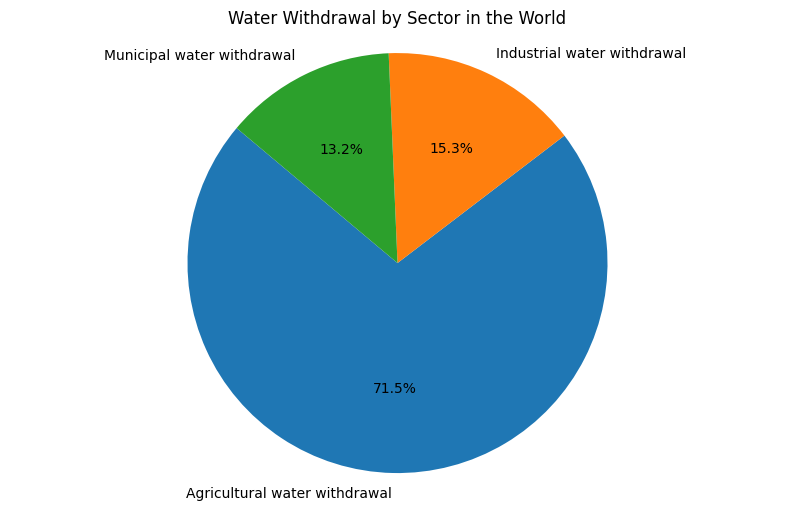

In [125]:
# Plot a simple pie chart for the water withdrawal in the world
data = selected_values_www
labels = selected_variables_www

plt.figure(figsize=(10, 6))
plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Water Withdrawal by Sector in the World')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is a circle.
plt.show()

To enhance the readability and aesthetic quality of the pie chart, we apply a number of stylistic adjustments. Specifically, we modify the color palette to recall the water theme. Additionally, we improve the typography by selecting appropriate font sizes and weights for titles and labels. An impactful title is also added to provide the take-home message of the chart.

Text(0.5, 1.0, "More of 70% of the world's water withdrawal is used for agriculture")

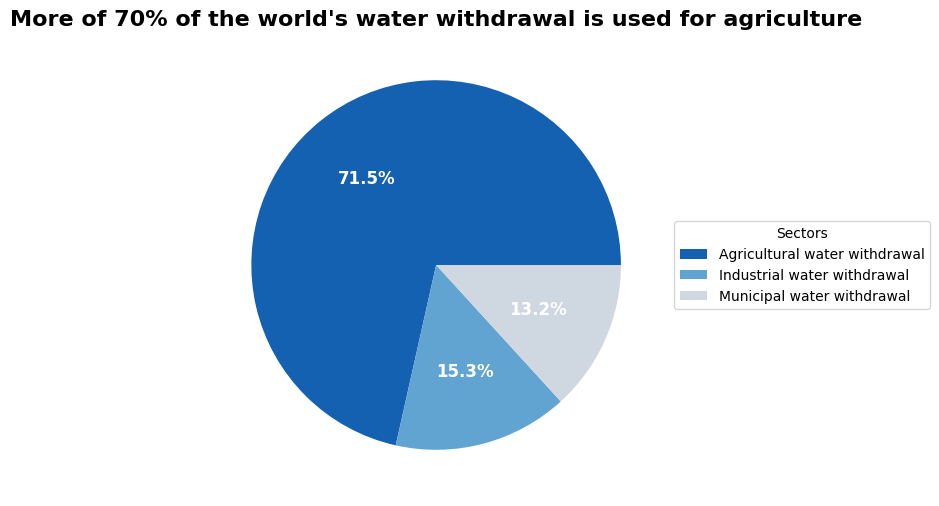

In [ ]:
# Tweak the pie chart to make it more visually appealing
# Add nice colors
colors = ["#1361B0", "#61A3D1", "#CFD7E1"]

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))

data = selected_values_www
labels = selected_variables_www

# Add percentages inside the pie chart to better readibility
# Add autopct to display percentages inside the pie
wedges, texts, autotexts = ax.pie(
    data,
    colors=colors,
    textprops=dict(color="w"),
    autopct='%1.1f%%'  # This adds the percentage labels
)

ax.legend(wedges, labels,
          title="Sectors",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(texts, size=12, weight="bold")
plt.setp(autotexts, size=12, weight="bold")  # Style the percentage labels

# Set a nice title. It should report the take home message of the pie chart, not a descriptive title
ax.set_title("More of 70% of the world's water withdrawal is used for agriculture", fontsize=16, weight="bold")

### Land use per sector?
To answer this question, we adopt the same visualization strategy used for the analysis of global water withdrawal. A pie chart is employed to highlight the proportion of land use attributed to different sectors. This type of chart is particularly suitable for showing categorical distributions and emphasizing the predominance of one category over others. In this case, we aim to illustrate the extent to which agricultural activities dominate land use globally, without focusing on temporal trends. A static representation is sufficient to convey the relative impact of each sector.

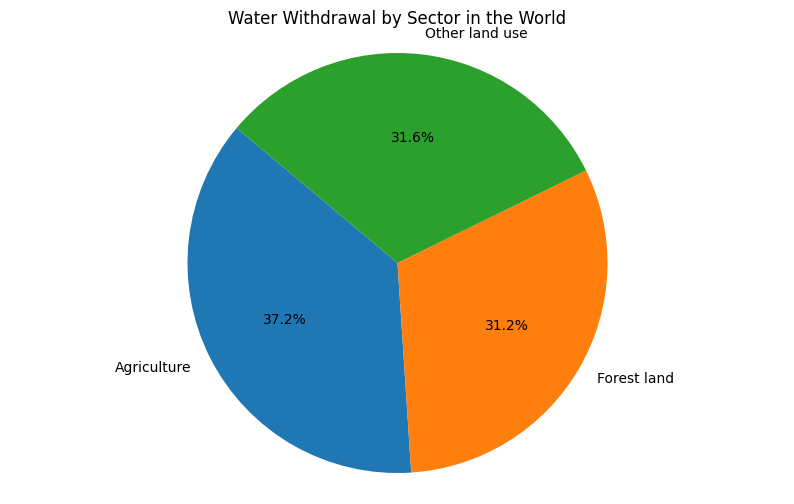

In [127]:
# Plot a simple pie chart for the water withdrawal in the world
labels = land_use_items
data = land_use_values

plt.figure(figsize=(10, 6))
plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Water Withdrawal by Sector in the World')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is a circle.
plt.show()

Also in this case, the chart must be tweaked.

Text(0.5, 1.0, 'One third of land area is used for agriculture')

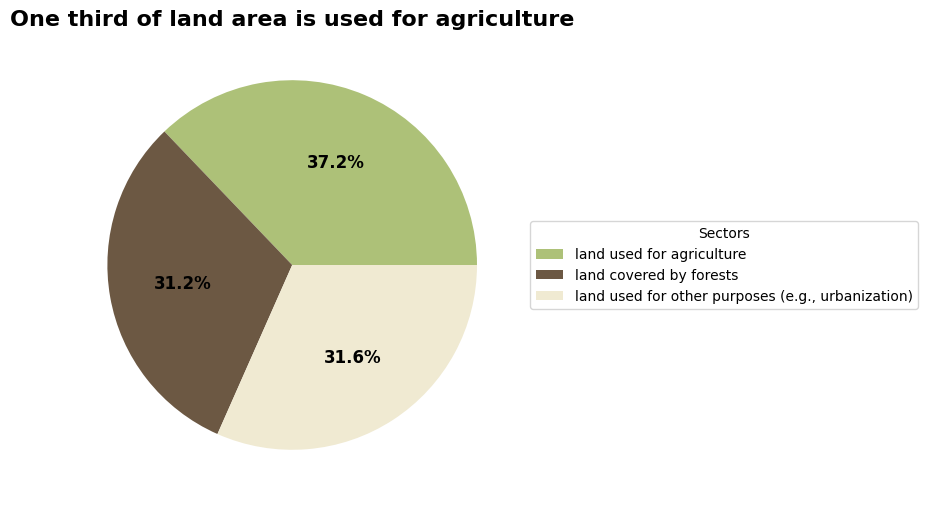

In [128]:
# Definitive pie chart for land use by sector in 2022
labels = ["land used for agriculture", "land covered by forests", "land used for other purposes (e.g., urbanization)"]
sizes = [agriculture_area, forest_land_area, other_land_area]
colors = ["#ADC178", "#6C5843", "#F0EAD2"]

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))

data = sizes

# Add autopct to display percentages inside the pie
wedges, texts, autotexts = ax.pie(
    data,
    colors=colors,
    autopct='%1.1f%%'  # This adds the percentage labels
)

ax.legend(wedges, labels,
          title="Sectors",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(texts, size=12, weight="bold")
plt.setp(autotexts, size=12, weight="bold")  # Style the percentage labels

ax.set_title("One third of land area is used for agriculture", fontsize=16, weight="bold")

### Ghg emissions?
To address this question, we aim to compare the greenhouse gas (GHG) emissions generated by different sectors, with a particular focus on the agrifood industry. In order to both contextualize the agrifood sector within the broader landscape and explore its internal composition, we adopt a two-tiered visualization strategy.

First, we present a vertical stacked bar chart that compares total GHG emissions across major sectors. Within this chart, the emissions attributable to the agrifood sector are represented as a single, aggregated bar composed of its main sub-processes. This provides an overview of how agriculture and food production contribute to global emissions relative to other industries.

To enhance granularity and improve readability, a second horizontal bar chart is included. This chart breaks down the emissions within the agrifood sector by sub-categories (e.g., livestock, transportation, processing), effectively serving as a “zoom-in” on the corresponding stacked bar in the first chart. On the webiste, an arrow visually connects the two charts to reinforce the conceptual link.

As with previous analyses, this visualization focuses exclusively on the relative contributions and is not concerned with temporal variation.

Categories: ['Energy', 'Agrifood System', 'IPPU', 'Waste', 'International bunkers', 'Other']


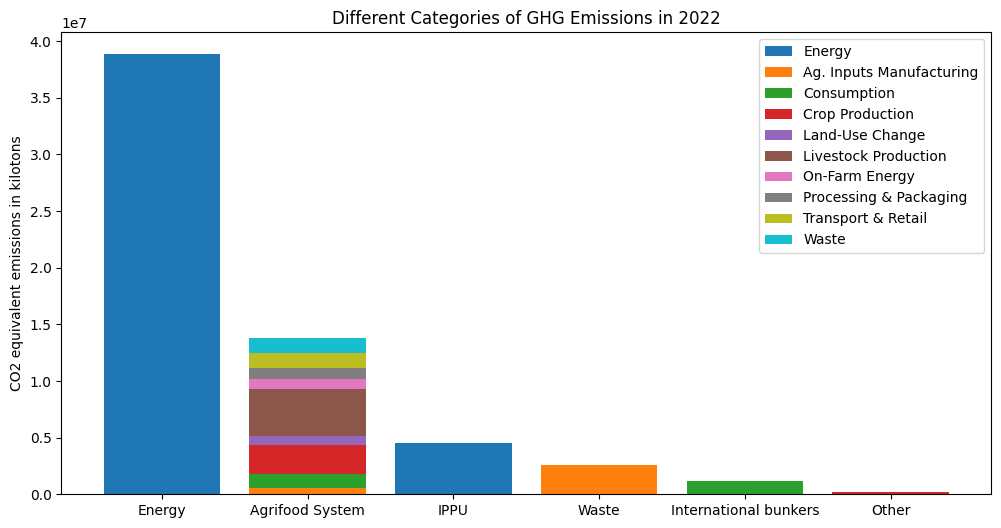

In [129]:
# List with all the categories
categories = []

for item in other_sectors_emissions_items:
    categories.append(item)

# Insert "Agrifood System" as the first item in the categories list
categories.insert(1, "Agrifood System")

print("Categories:", categories)
x = np.arange(len(categories))  # the label locations

fig, ax = plt.subplots(figsize=(12, 6))

# First bar for energy sector
ax.bar(x[0], other_sectors_emissions_values[0], label=other_sectors_emissions_items[0])

# Only stack for the agriculture sectors
i = 0
while i < len(agriculture_sectors_emissions_values):
    if i == 0:
        ax.bar(x[1], agriculture_sectors_emissions_values[i], label=agriculture_sectors_emissions_items[i])
        bottom = agriculture_sectors_emissions_values[i]
        i += 1
    else:
        ax.bar(x[1], agriculture_sectors_emissions_values[i], label=agriculture_sectors_emissions_items[i], bottom=bottom)
        bottom += agriculture_sectors_emissions_values[i]
        i += 1

k = 2  # Start from the second index for other sectors
j = 1
while j < len(other_sectors_emissions_values):
    ax.bar(x[k], other_sectors_emissions_values[j], label=None)
    k += 1
    j += 1

plt.xticks(x, categories)
plt.ylabel('CO2 equivalent emissions in kilotons')
plt.title("Different Categories of GHG Emissions in 2022")
plt.legend()
plt.show()

To help users focus on the agrifood system, all bars representing other sectors are displayed in a neutral color, while the agrifood bar is highlighted using a distinctive hue. This same color palette is then applied to the second chart, which shows a detailed breakdown of the agrifood sector: each sub-process within the sector is represented using the same colors used in the stacked agrifood bar. This visual coherence reinforces the connection between the two charts and improves the user's understanding. Additionally, values on the y-axis are displayed in standard numeric format rather than scientific notation, in order to enhance readability and eliminate the need for users to mentally convert the values.

Categories: ['Energy', 'Agrifood System', 'IPPU', 'Waste', 'International bunkers', 'Other']


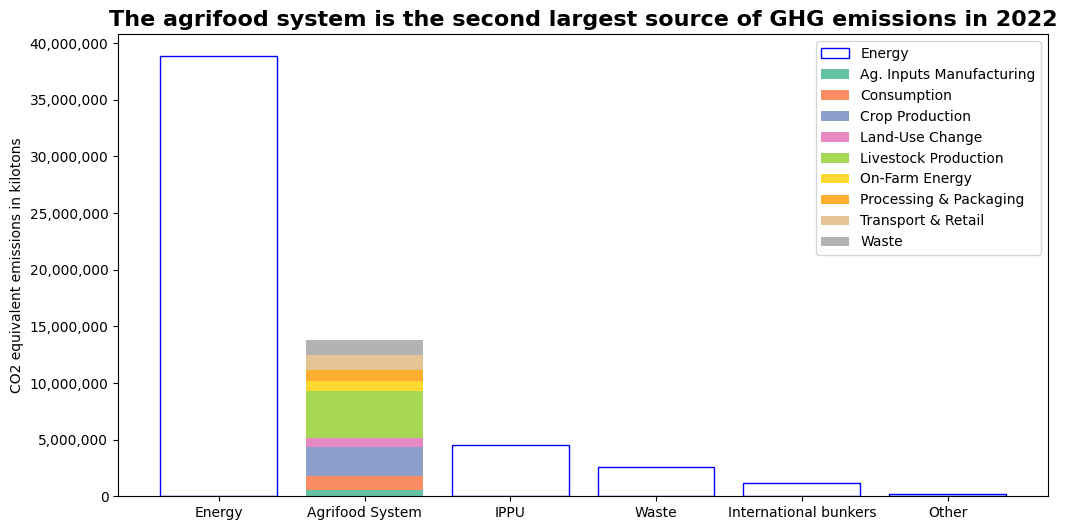

In [ ]:
import matplotlib.ticker as mticker
# List with all the categories
categories = []

for item in other_sectors_emissions_items:
    categories.append(item)

# Insert "Agrifood System" as the first item in the categories list
categories.insert(1, "Agrifood System")

print("Categories:", categories)
x = np.arange(len(categories))  # the label locations

fig, ax = plt.subplots(figsize=(12, 6))

single_bar_color = "b"
face_color = "white"
list_colors_agrifood = ["#66C2A5", "#FC8D62", "#8DA0CB", "#E78AC3", "#A6D854", "#FFD92F", "#FFAF2F", "#E5C494", "#B3B3B3"]

# First bar for energy sector
ax.bar(x[0], other_sectors_emissions_values[0], label=other_sectors_emissions_items[0], color=face_color, edgecolor=single_bar_color)

# Only stack for the agriculture sectors
i = 0
while i < len(agriculture_sectors_emissions_values):
    if i == 0:
        ax.bar(x[1], agriculture_sectors_emissions_values[i], label=agriculture_sectors_emissions_items[i], color=list_colors_agrifood[i])
        bottom = agriculture_sectors_emissions_values[i]
        i += 1
    else:
        ax.bar(x[1], agriculture_sectors_emissions_values[i], label=agriculture_sectors_emissions_items[i], bottom=bottom, color=list_colors_agrifood[i])
        bottom += agriculture_sectors_emissions_values[i]
        i += 1

k = 2  # Start from the second index for other sectors
j = 1
while j < len(other_sectors_emissions_values):
    ax.bar(x[k], other_sectors_emissions_values[j], label=None, color=face_color, edgecolor=single_bar_color)
    k += 1
    j += 1

ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

plt.xticks(x, categories)
plt.ylabel('CO2 equivalent emissions in kilotons')
plt.title("The agrifood system is the second largest source of GHG emissions globally", fontsize=16, weight="bold")
plt.legend()
plt.show()

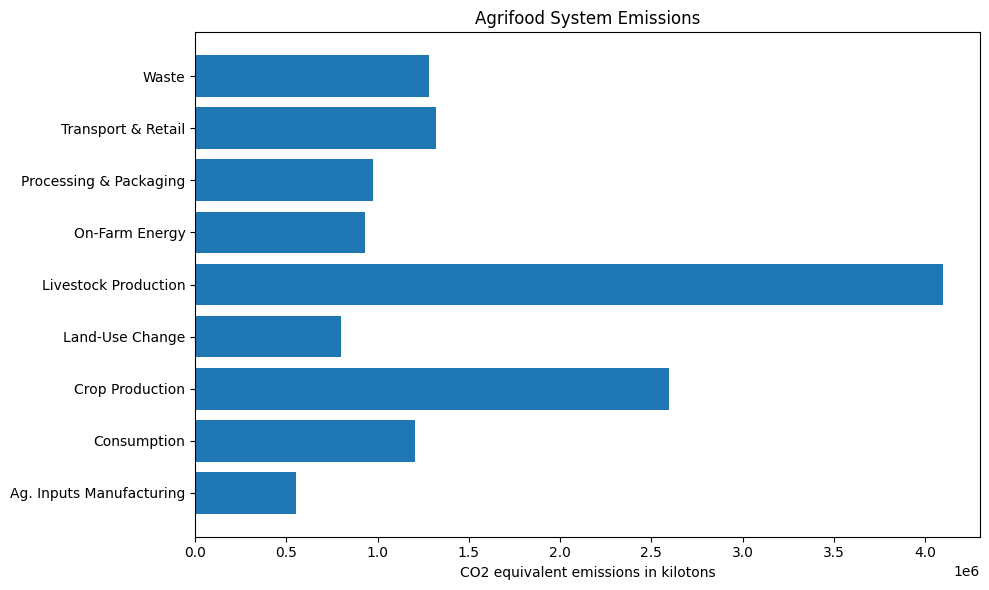

In [131]:
# Plot an horizontal bar chart for the agrifood system emissions
items = agriculture_sectors_emissions_values
labels = agriculture_sectors_emissions_items
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(labels, items)
ax.set_xlabel("CO2 equivalent emissions in kilotons")
ax.set_title("Agrifood System Emissions")
plt.tight_layout()
plt.show()

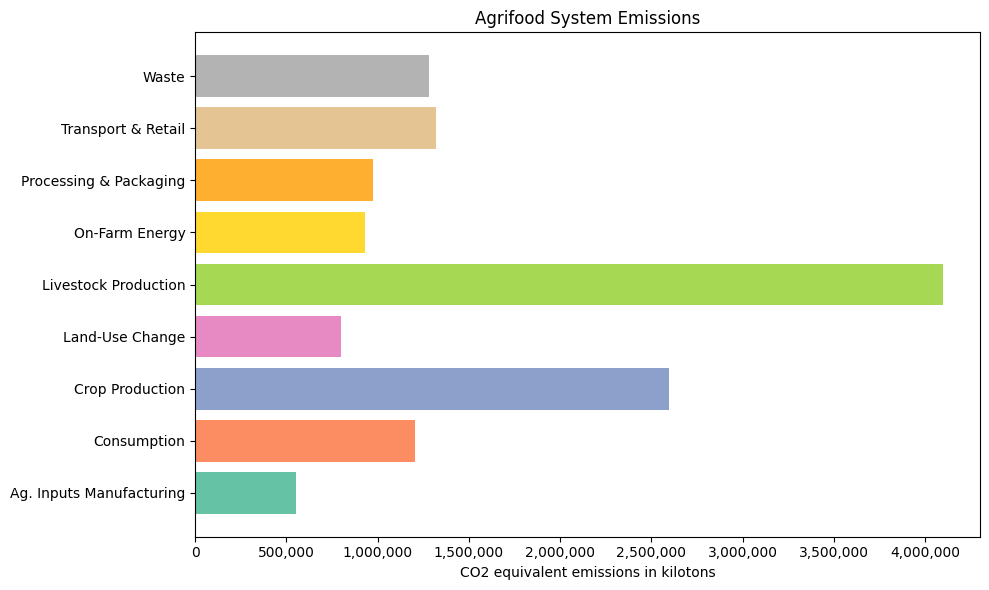

In [137]:
# Refine the horizontal bar chart wrt colors 
items = agriculture_sectors_emissions_values
labels = agriculture_sectors_emissions_items
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(labels, items, color=list_colors_agrifood)
ax.set_xlabel("CO2 equivalent emissions in kilotons")
ax.set_title("Agrifood System Emissions")
ax.xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.show()

### Most consumed products in Italy?

In the second part of the storytelling, we focus on identifying the most commonly consumed food products in Italy and examining their associated environmental impacts. Specifically, we present data on both the water footprint and the carbon footprint of these items. The objective is to highlight the extent to which the dietary habits of the Italian population contribute to environmental degradation, thereby raising awareness of the ecological cost of everyday food choices.

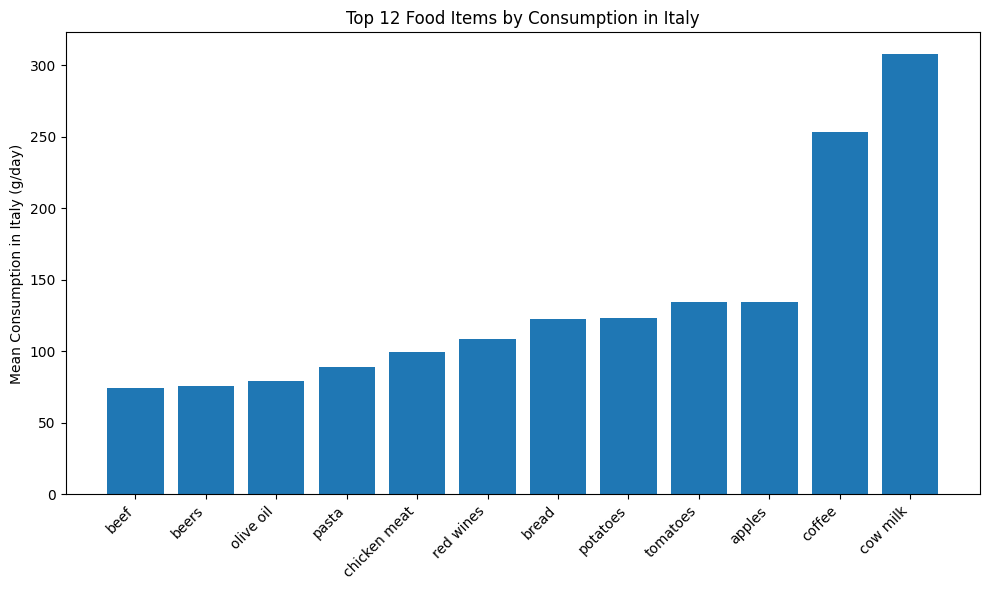

In [ ]:
# Create an vertical bar chart for the top consumed food items in Italy
# Sort the DataFrame by Mean_consumption_italy_(g/day) in ascending order
top_food_items = definitive_df.sort_values(by="Mean_consumption_italy_(g/day)", ascending=True).tail(12)
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(top_food_items["AGROVOC_label"], top_food_items["Mean_consumption_italy_(g/day)"])
ax.set_ylabel("Mean Consumption in Italy (g/day)")
ax.set_title("Top 12 Food Items by Consumption in Italy")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

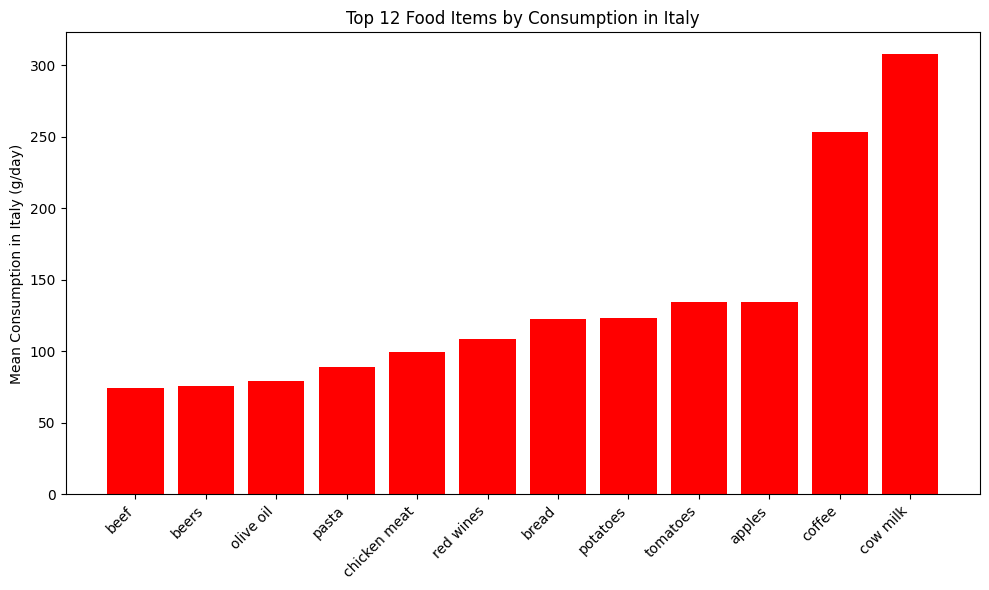

In [166]:
# Change colors, select good title
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(top_food_items["AGROVOC_label"], top_food_items["Mean_consumption_italy_(g/day)"], color="red")
ax.set_ylabel("Mean Consumption in Italy (g/day)")
ax.set_title("Top 12 Food Items by Consumption in Italy")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

### What is the water footprints of these food items?

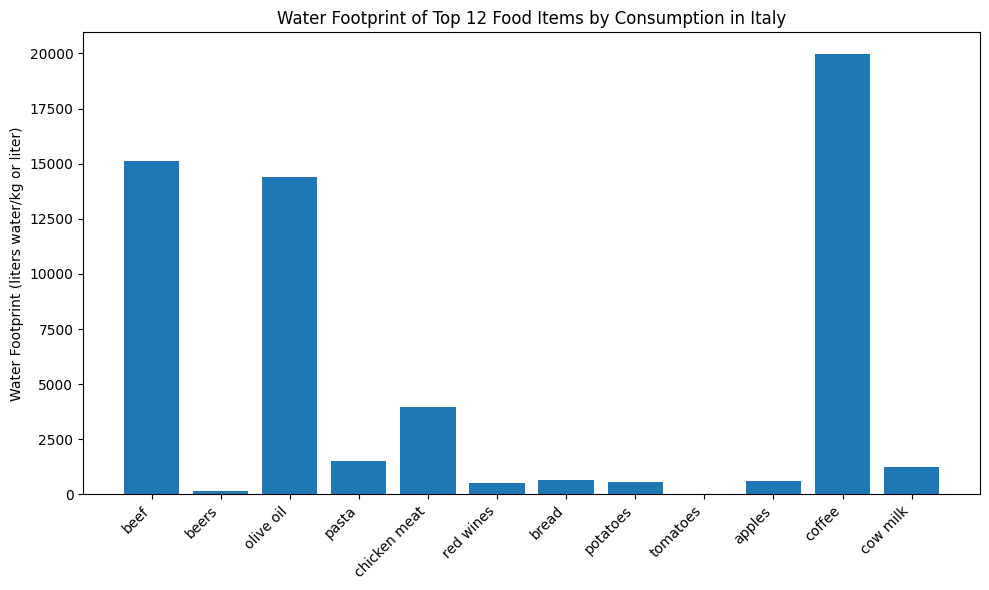

In [ ]:
# Create a vertical bar chart for the water footprint of the top 12 food items by consumption in Italy
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(top_food_items["AGROVOC_label"], top_food_items["Water Footprint liters (water/kg o liter)"])
ax.set_ylabel("Water Footprint (liters water/kg or liter)")
ax.set_title("Water Footprint of Top 12 Food Items by Consumption in Italy")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

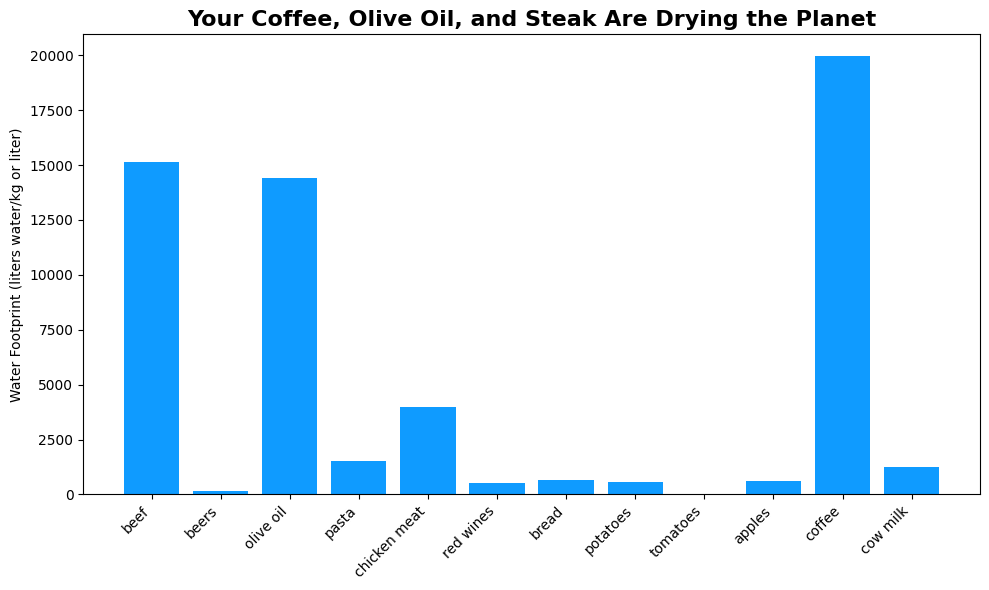

In [ ]:
# Tweak the chart (title, colors, etc.)
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(top_food_items["AGROVOC_label"], top_food_items["Water Footprint liters (water/kg o liter)"], color="#0F9BFF")
ax.set_ylabel("Water Footprint (liters water/kg or liter)")
ax.set_title("Your Coffee, Olive Oil, and Steak Are Drying the Planet", fontsize=16, weight="bold")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

### What is the carbon footprints of these food items?

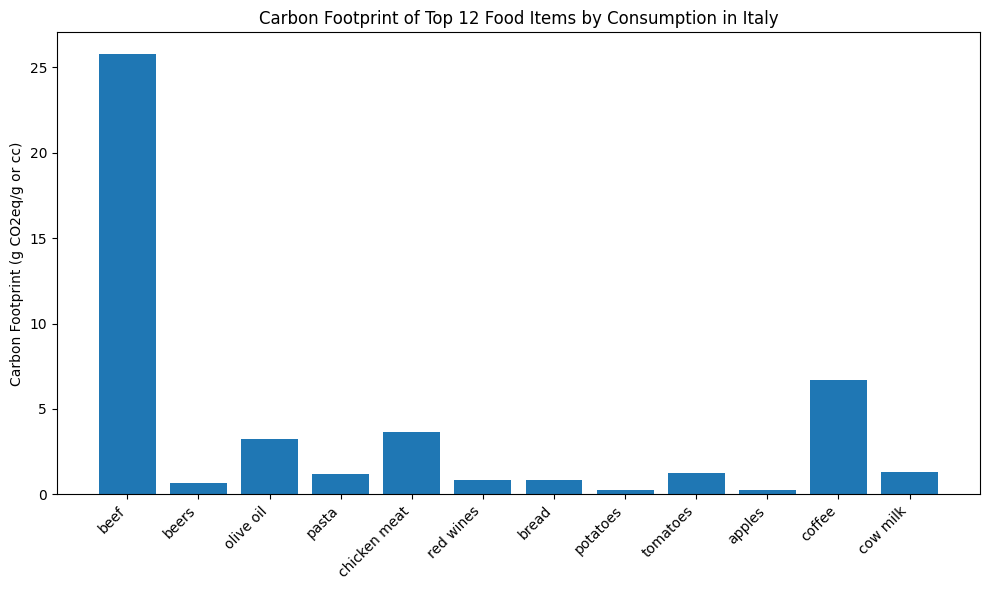

In [ ]:
# Create a vertical bar chart for the carbon footprint of the top 12 food items by consumption in Italy
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(top_food_items["AGROVOC_label"], top_food_items["Carbon Footprint (g CO2eq/g o cc)"])
ax.set_ylabel("Carbon Footprint (g CO2eq/g or cc)")
ax.set_title("Carbon Footprint of Top 12 Food Items by Consumption in Italy")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

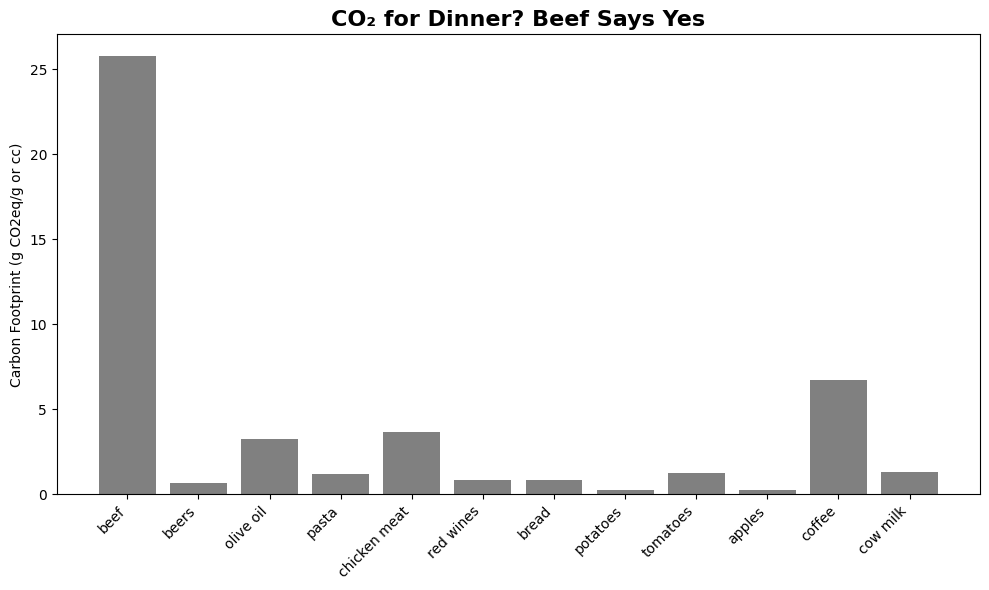

In [156]:
# Refine the chart (title, colors, etc.)
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(top_food_items["AGROVOC_label"], top_food_items["Carbon Footprint (g CO2eq/g o cc)"], color="grey")
ax.set_ylabel("Carbon Footprint (g CO2eq/g or cc)")
ax.set_title("CO₂ for Dinner? Beef Says Yes", fontsize=16, weight="bold")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

### Possible alternatives?

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def compare_products(product1, product2, csv_file= r'site/final_data/game_data.csv'):

    
    # Read the CSV file
    df = pd.read_csv(csv_file)
    
    # Filter for the specified products
    product_data = df[df['AGROVOC_label'].isin([product1, product2])].copy()
    
    # Check if both products exist in the dataset
    if len(product_data) != 2:
        available_products = df['AGROVOC_label'].tolist()
        print(f"Error: One or both products not found in dataset.")
        print(f"Available products: {available_products}")
        return
    
    # Extract data
    products = product_data['AGROVOC_label'].tolist()
    water_footprint = product_data['Water Footprint liters (water/kg o liter)'].tolist()
    co2_footprint = product_data['Carbon Footprint (g CO2eq/g o cc)'].tolist()
    
    # Check for missing data
    if any(pd.isna(water_footprint)) or any(pd.isna(co2_footprint)):
        print("Warning: Some data is missing for the selected products.")
        print(f"Water footprint data: {water_footprint}")
        print(f"CO2 footprint data: {co2_footprint}")
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Colors for consistency
    colors = ["#FF9999", "#90EE90"]
    
    # Water Usage Comparison
    bars1 = ax1.bar(products, water_footprint, color=colors, alpha=0.8)
    ax1.set_title(f'Water Footprint Comparison:\n{product1} vs {product2}', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Product', fontsize=12)
    ax1.set_ylabel('Water Footprint (liters per kg/liter)', fontsize=12)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on water chart
    for bar, value in zip(bars1, water_footprint):
        if not pd.isna(value):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(water_footprint)*0.02, 
                     f'{value:,.0f}L', ha='center', va='bottom', fontweight='bold')
    
    # CO2 Production Comparison
    bars2 = ax2.bar(products, co2_footprint, color=colors, alpha=0.8)
    ax2.set_title(f'Carbon Footprint Comparison:\n{product1} vs {product2}', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Product', fontsize=12)
    ax2.set_ylabel('Carbon Footprint (g CO2eq/g)', fontsize=12)
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels on CO2 chart
    for bar, value in zip(bars2, co2_footprint):
        if not pd.isna(value):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(co2_footprint)*0.02, 
                     f'{value:.3f}g', ha='center', va='bottom', fontweight='bold')
    
    # Improve layout
    plt.tight_layout()
    plt.show()
    

# To see all available products:
def show_available_products(csv_file='game_data.csv'):
    """Display all available products in the dataset."""
    df = pd.read_csv(csv_file)
    products = sorted(df['AGROVOC_label'].tolist())
    print("Available products for comparison:")
    for i, product in enumerate(products, 1):
        print(f"{i:2d}. {product}")

# Uncomment the line below to see all available products:
# show_available_products()

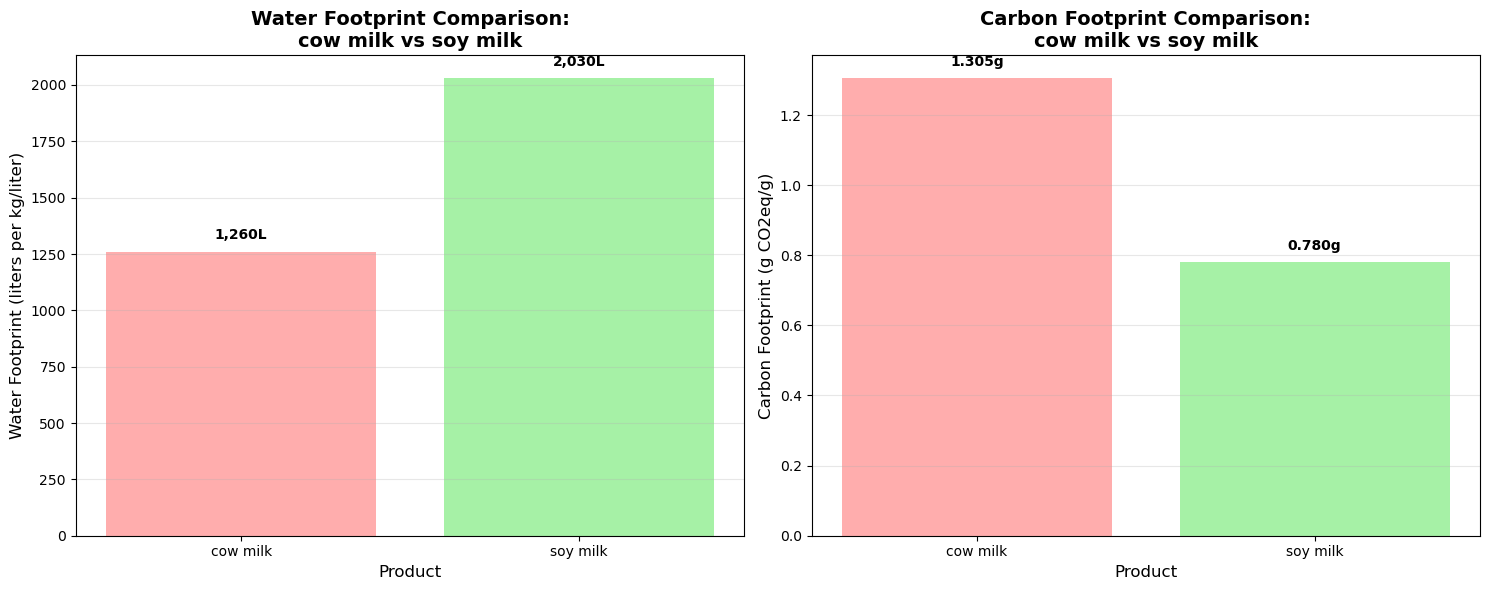

In [ ]:
compare_products('cow milk', 'soy milk')

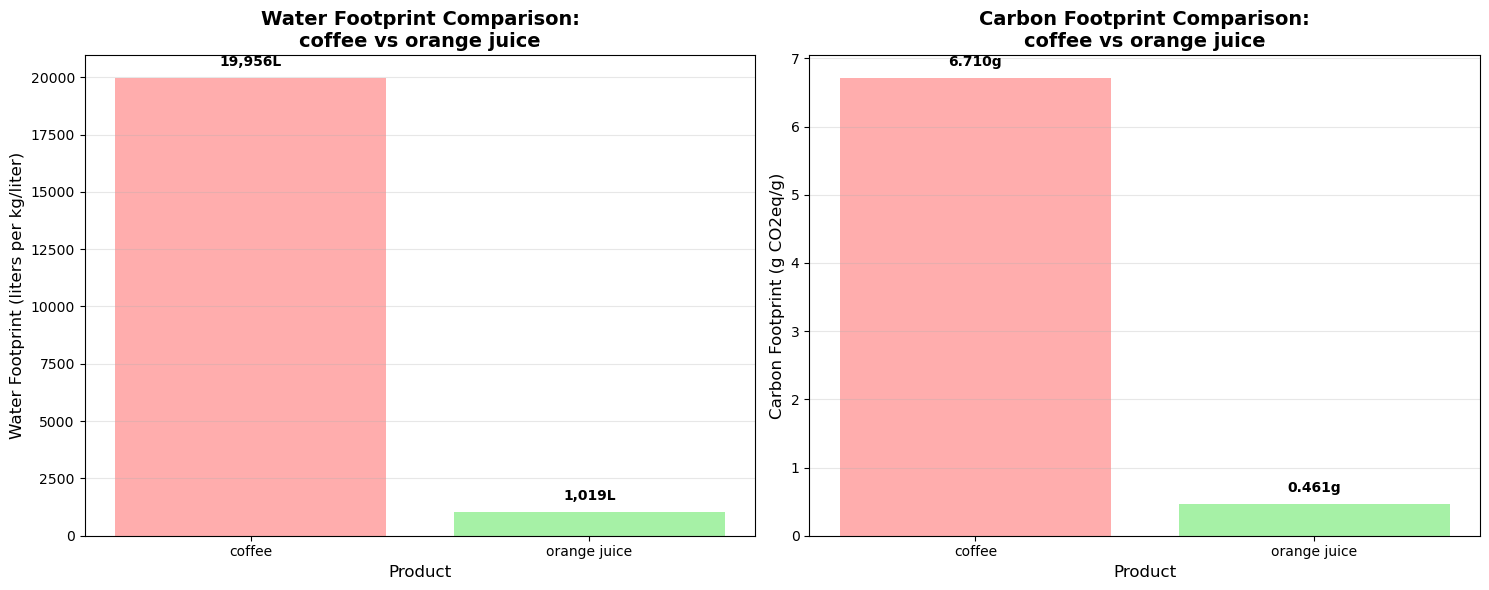

In [ ]:
compare_products('coffee', 'orange juice')

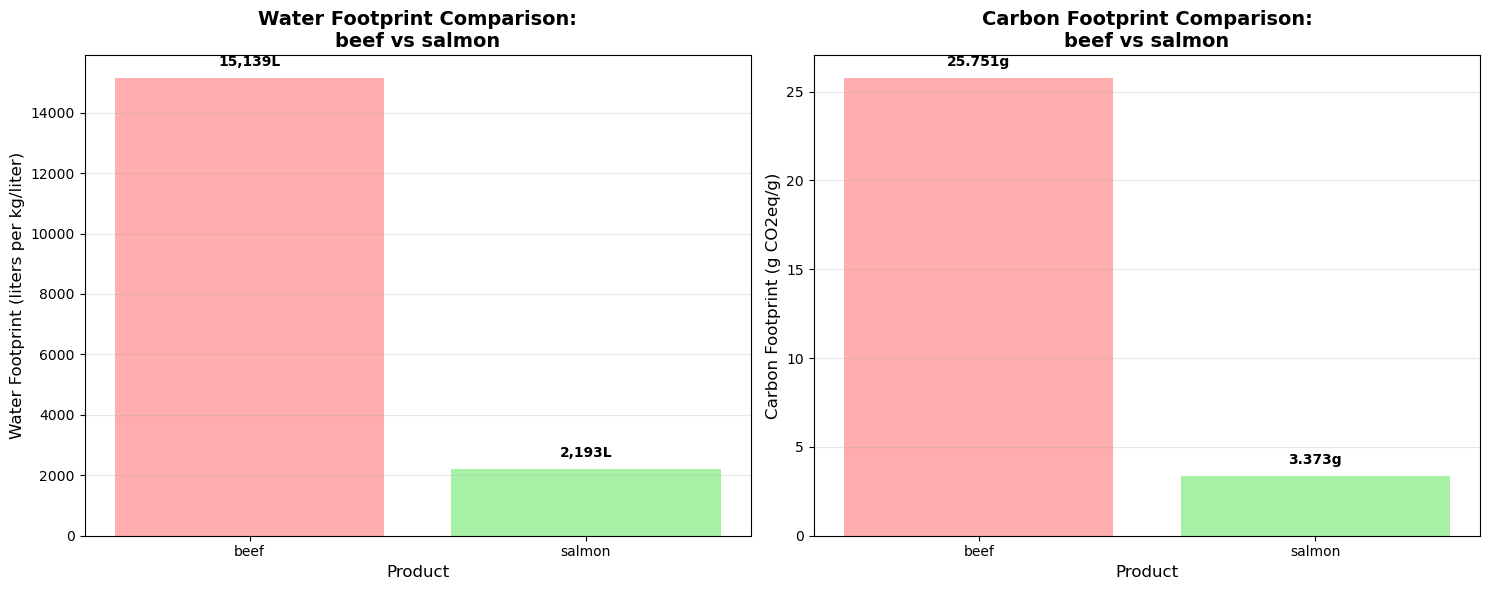

In [ ]:
compare_products("beef", "salmon")

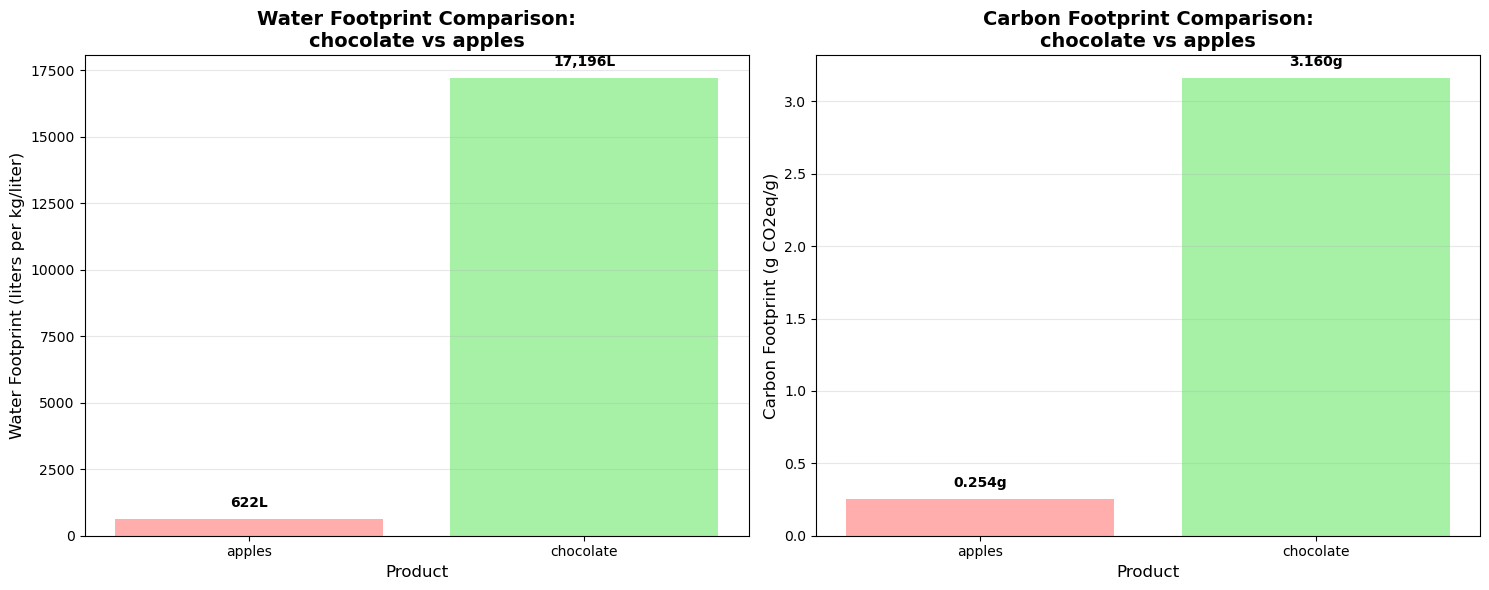

In [ ]:
compare_products("chocolate", "apples")

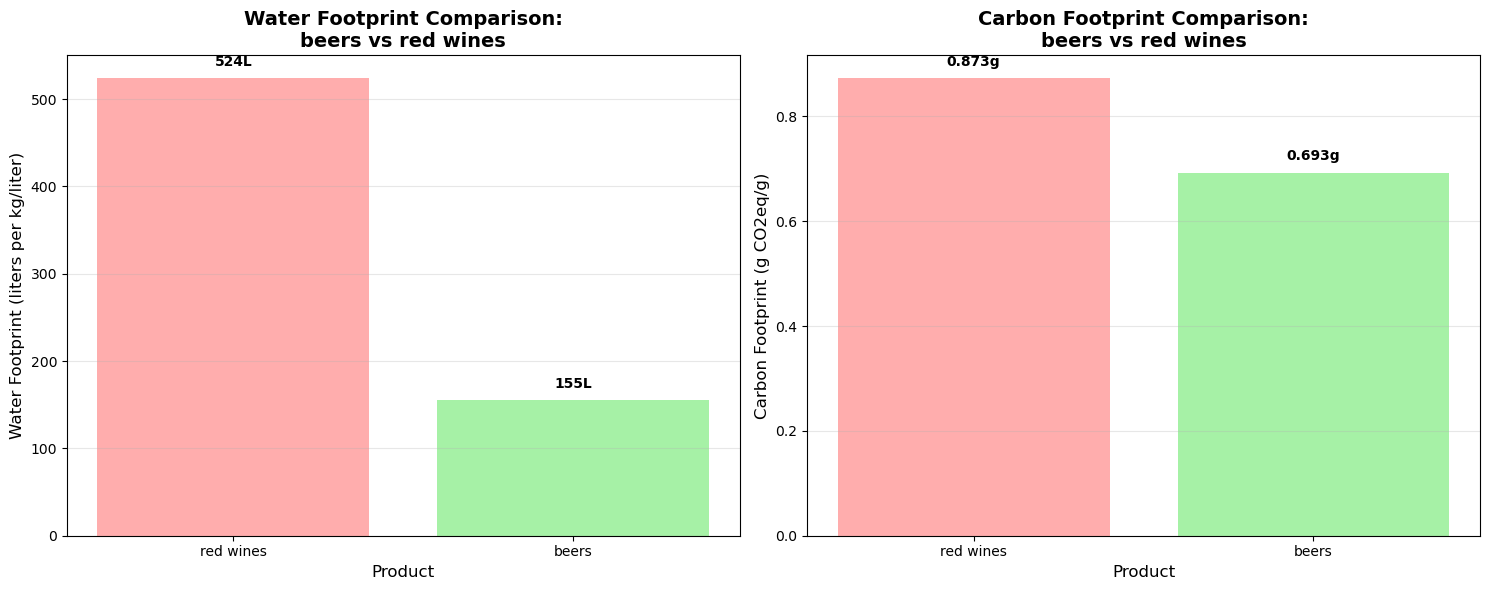

In [ ]:
compare_products("beers", "red wines")

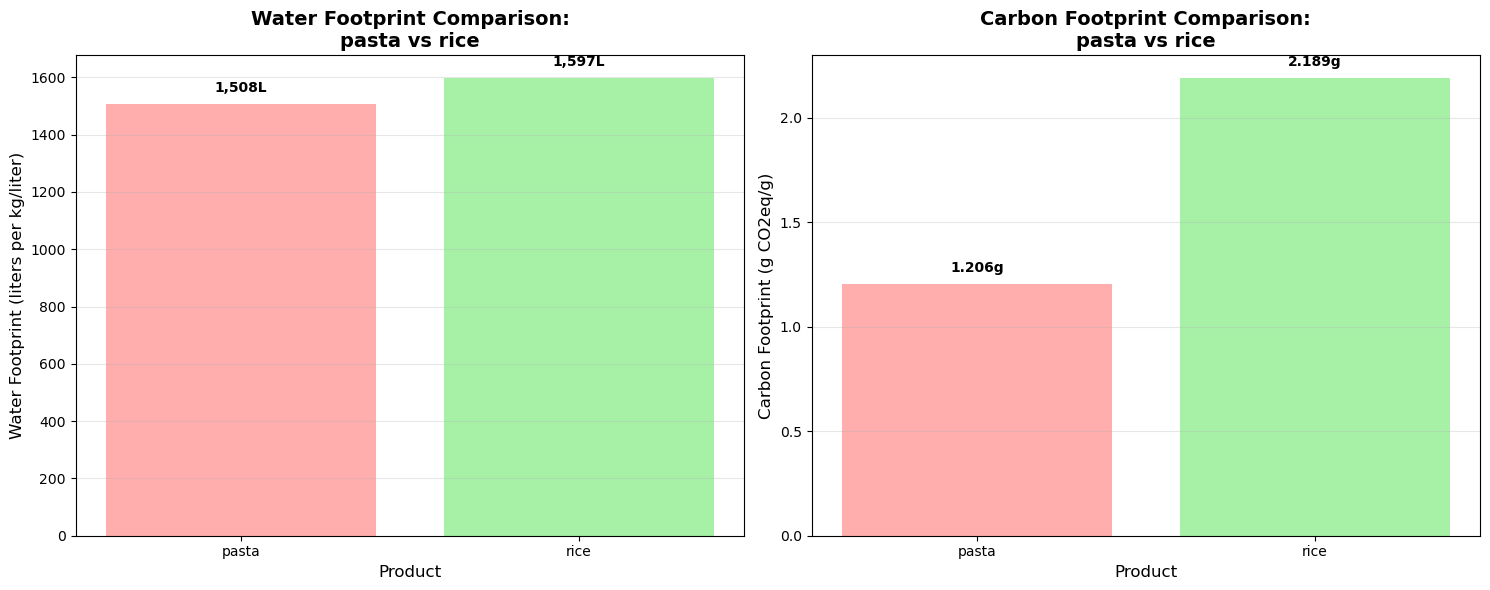

In [ ]:
compare_products("pasta", "rice")

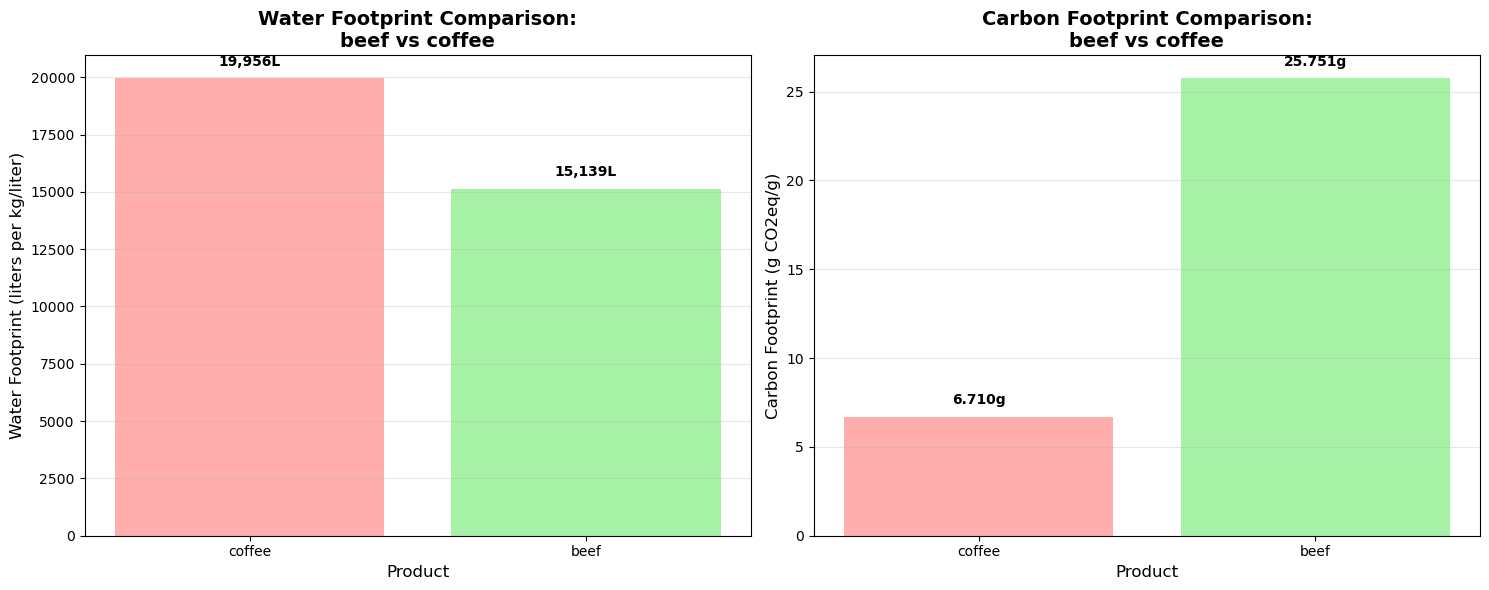

In [ ]:
compare_products("beef", "coffee")

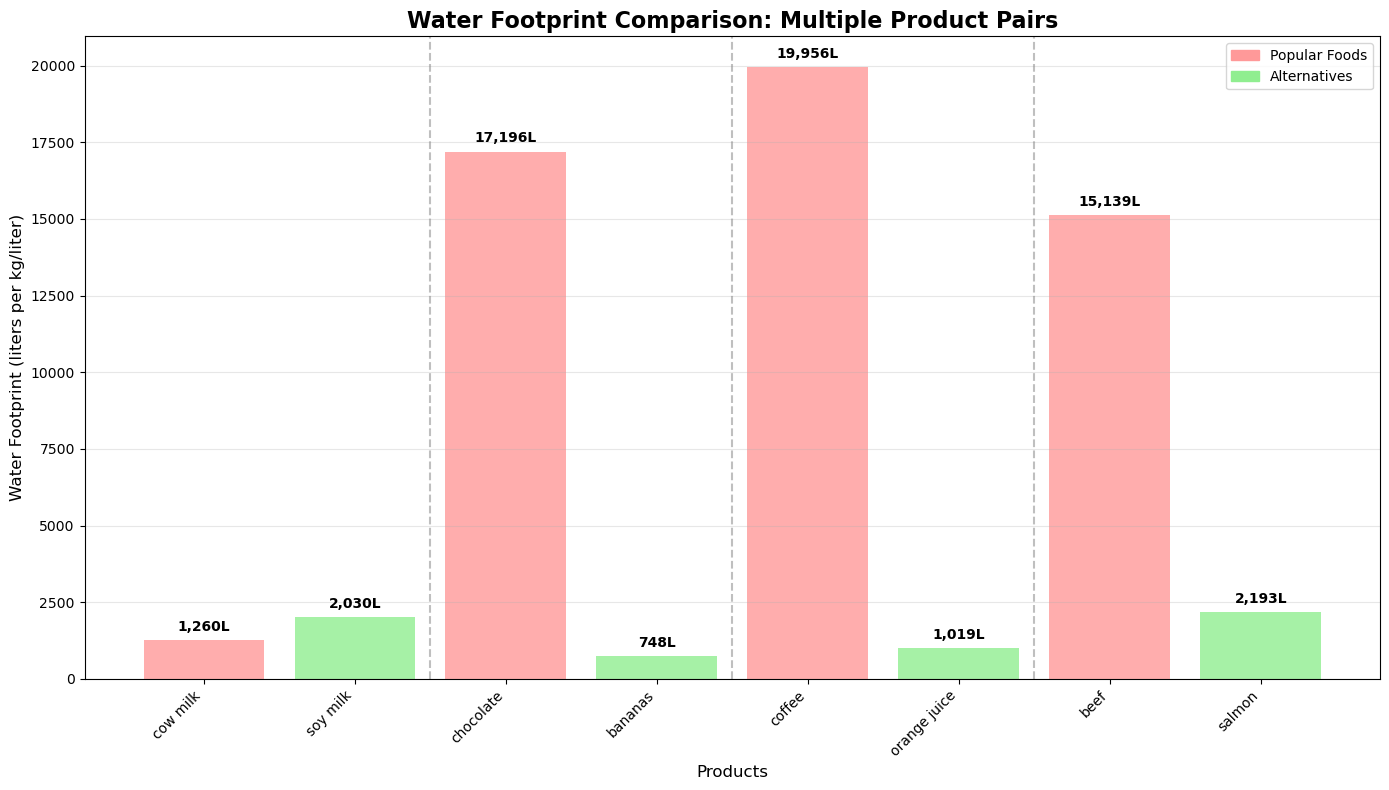

In [ ]:
products = ['cow milk', 'soy milk', 'chocolate', 'bananas', 'coffee', 'orange juice', 'beef', 'salmon']

# Filter for the specified products
product_data = df[df['AGROVOC_label'].isin(products)].copy()

# Sort the data to match the order we want
product_data = product_data.set_index('AGROVOC_label').reindex(products).reset_index()

# Extract data
product_names = product_data['AGROVOC_label'].tolist()
water_footprint = product_data['Water Footprint liters (water/kg o liter)'].tolist()

# Create the bar chart
plt.figure(figsize=(14, 8))

# Define colors: light red for traditional foods, light green for alternatives
colors = ['#FF9999', '#90EE90',  # cow milk (red) vs soy milk (green)
          '#FF9999', '#90EE90',  # chocolate (red) vs bananas (green)
          '#FF9999', '#90EE90',  # coffee (red) vs orange juice (green)
          '#FF9999', '#90EE90']  # beef (red) vs salmon (green)</anueml:parameter>


bars = plt.bar(product_names, water_footprint, color=colors, alpha=0.8)

# Customize the chart
plt.title('Water Footprint Comparison: Multiple Product Pairs', fontsize=16, fontweight='bold')
plt.xlabel('Products', fontsize=12)
plt.ylabel('Water Footprint (liters per kg/liter)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels on top of bars
for bar, value in zip(bars, water_footprint):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(water_footprint)*0.01, 
             f'{value:,.0f}L', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Add vertical lines to separate comparison pairs
for i in range(1, 4):
    plt.axvline(x=i*2 - 0.5, color='gray', linestyle='--', alpha=0.5)

# Add legend
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='#FF9999', label='Popular Foods')
green_patch = mpatches.Patch(color='#90EE90', label='Alternatives')
plt.legend(handles=[red_patch, green_patch], loc='upper right')

# Improve layout
plt.tight_layout()

# Display the chart
plt.show()

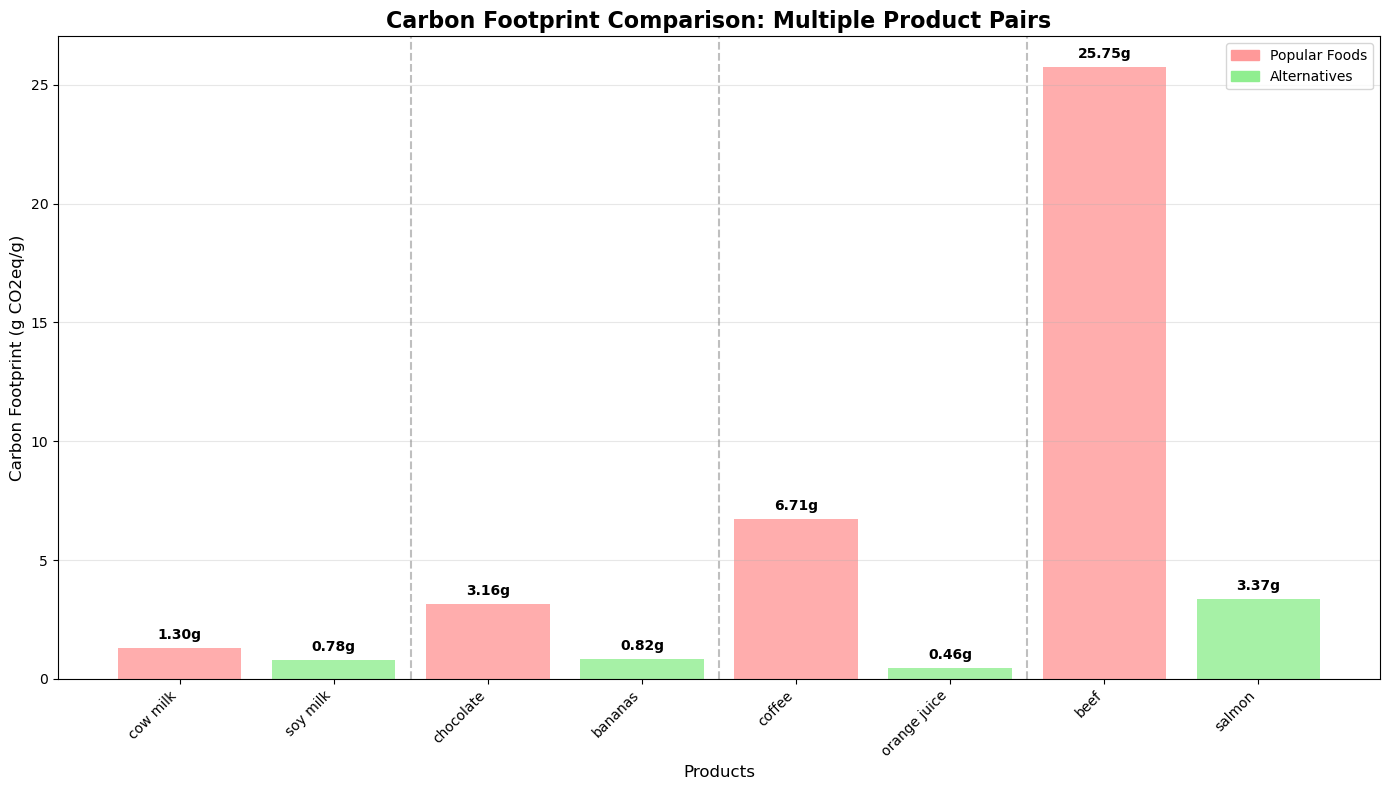

In [ ]:
products = ['cow milk', 'soy milk', 'chocolate', 'bananas', 'coffee', 'orange juice', 'beef', 'salmon']

# Filter for the specified products
product_data = df[df['AGROVOC_label'].isin(products)].copy()

# Sort the data to match the order we want
product_data = product_data.set_index('AGROVOC_label').reindex(products).reset_index()

# Extract data
product_names = product_data['AGROVOC_label'].tolist()
co2_footprint = product_data['Carbon Footprint (g CO2eq/g o cc)'].tolist()

# Create the bar chart
plt.figure(figsize=(14, 8))

# Define colors: light red for traditional foods, light green for alternatives
colors = ['#FF9999', '#90EE90',  # cow milk (red) vs soy milk (green)
          '#FF9999', '#90EE90',  # chocolate (red) vs bananas (green)
          '#FF9999', '#90EE90',  # coffee (red) vs orange juice (green)
          '#FF9999', '#90EE90']  # beef (red) vs salmon (green)

bars = plt.bar(product_names, co2_footprint, color=colors, alpha=0.8)

# Customize the chart
plt.title('Carbon Footprint Comparison: Multiple Product Pairs', fontsize=16, fontweight='bold')
plt.xlabel('Products', fontsize=12)
plt.ylabel('Carbon Footprint (g CO2eq/g)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels on top of bars
for bar, value in zip(bars, co2_footprint):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(co2_footprint)*0.01, 
             f'{value:.2f}g', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Add vertical lines to separate comparison pairs
for i in range(1, 4):
    plt.axvline(x=i*2 - 0.5, color='gray', linestyle='--', alpha=0.5)

# Add legend
red_patch = mpatches.Patch(color='#FF9999', label='Popular Foods')
green_patch = mpatches.Patch(color='#90EE90', label='Alternatives')
plt.legend(handles=[red_patch, green_patch], loc='upper right')

# Improve layout
plt.tight_layout()

# Display the chart
plt.show()

### Correlation between Carbon Footprint and Price

In the final chart, we aim to illustrate the correlation between the carbon footprints and the prices of food items. This visualization intends to demonstrate that selecting foods with a lower environmental impact is often associated with reduced economic costs. To effectively convey this relationship, a scatter plot has been chosen. 

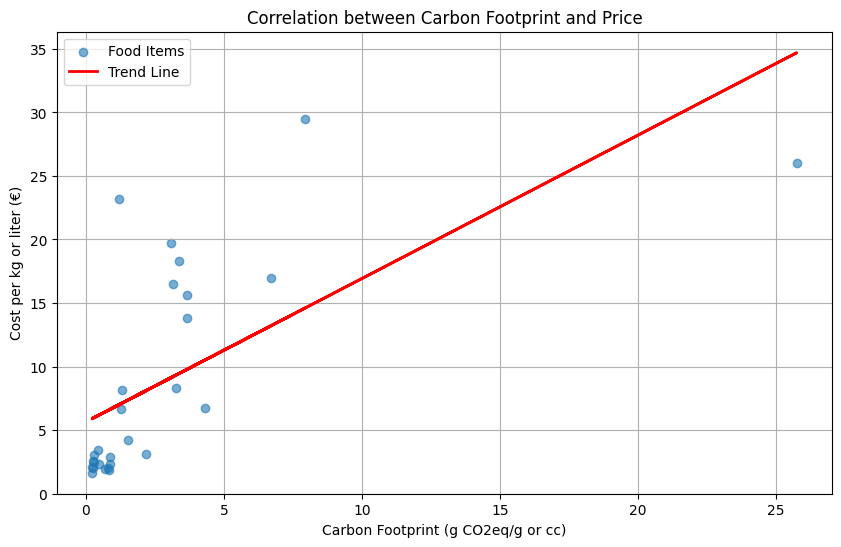

In [ ]:
# Drop rows with NaN values in the relevant columns for calculating the trend line
df_cleaned = final_definitive_df.dropna(subset=["Carbon Footprint (g CO2eq/g o cc)", "cost_per_kg_or_l"])

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(final_definitive_df["Carbon Footprint (g CO2eq/g o cc)"], final_definitive_df["cost_per_kg_or_l"], alpha=0.6, label='Food Items')

# Calculate the line of best fit
m, b = np.polyfit(df_cleaned["Carbon Footprint (g CO2eq/g o cc)"], df_cleaned["cost_per_kg_or_l"], 1)

# Plot the line of best fit
plt.plot(df_cleaned["Carbon Footprint (g CO2eq/g o cc)"], m * df_cleaned["Carbon Footprint (g CO2eq/g o cc)"] + b, color='red', linewidth=2, label='Trend Line')

# Add titles and labels
plt.title('High impact food items tend to be more expensive', fontsize=16, weight='bold')
plt.xlabel('Carbon Footprint (g CO2eq/g or cc)')
plt.ylabel('Cost per kg or liter (€)')
plt.grid(True)
plt.legend()
plt.show()

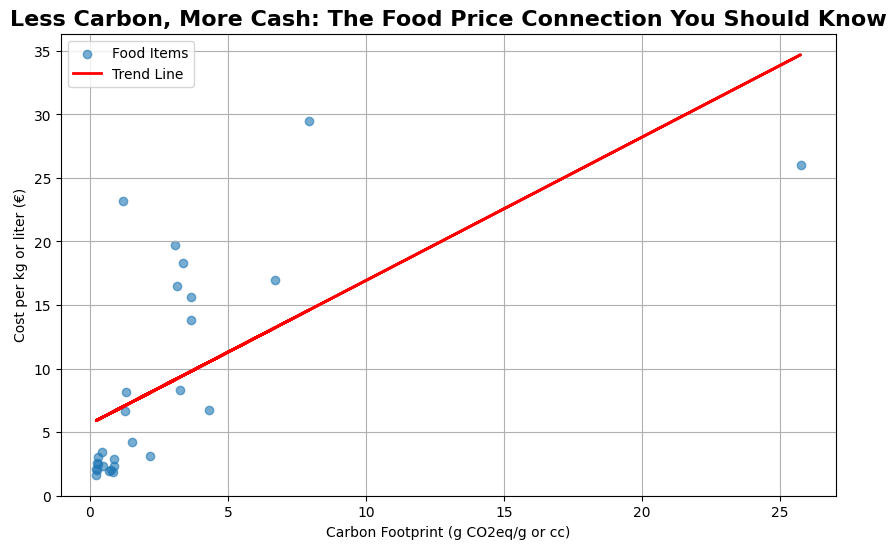

In [ ]:
# Drop rows with NaN values in the relevant columns for calculating the trend line
df_cleaned = final_definitive_df.dropna(subset=["Carbon Footprint (g CO2eq/g o cc)", "cost_per_kg_or_l"])

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(final_definitive_df["Carbon Footprint (g CO2eq/g o cc)"], final_definitive_df["cost_per_kg_or_l"], alpha=0.6, label='Food Items')

# Calculate the line of best fit
m, b = np.polyfit(df_cleaned["Carbon Footprint (g CO2eq/g o cc)"], df_cleaned["cost_per_kg_or_l"], 1)

# Plot the line of best fit
plt.plot(df_cleaned["Carbon Footprint (g CO2eq/g o cc)"], m * df_cleaned["Carbon Footprint (g CO2eq/g o cc)"] + b, color='red', linewidth=2, label='Trend Line')

# Add titles and labels
plt.title("Less Carbon, More Cash: The Food Price Connection You Should Know" , fontsize=16, weight="bold")
plt.xlabel('Carbon Footprint (g CO2eq/g or cc)')
plt.ylabel('Cost per kg or liter (€)')
plt.grid(True)
plt.legend()
plt.show()